## Introducción 

### Contexto
El presente cuaderno desarrolla un **Análisis Exploratorio de Datos (EDA)** sobre un conjunto de datos **anonimizado** que recoge información **académica y demográfica de estudiantes universitarios**. Esta base de datos se enmarca en el proyecto de una **plataforma integral de apoyo académico**, cuyo fin es mejorar la toma de decisiones de los estudiantes y de la institución a través de la **predicción de riesgos, recomendación de cursos y personalización de recursos de estudio**.

### Objetivo General

Desarrollar una plataforma integral de apoyo académico para estudiantes de Ciencia de la Computación de la UTEC, que, a partir de datos académicos y demográficos recopilados mediante encuestas, utilice modelos de inteligencia artificial para recomendar matrículas óptimas, predecir riesgos de desaprobación y ofrecer recursos de aprendizaje personalizados.

### Objetivos Específicos

1. **Recolectar y sistematizar datos académicos y demográficos** de los estudiantes de Ciencia de la Computación de UTEC, incluyendo historial de cursos y calificaciones.
2. **Diseñar e implementar un modelo de predicción de notas** Predica la Nota aproximada según el rendimiento previo, carga académica y datos demográficos.
3. **Desarrollar un modelo predictivo de desaprobación** que identifique los cursos con mayor probabilidad de riesgo académico, generando alertas preventivas para los estudiantes y el área de tutorías.
4. **Diseñar un sistema de recomendación de recursos de aprendizaje** adaptados al estilo de aprendizaje y al nivel de dificultad de cada curso.
5. **Evaluar el impacto de la plataforma en la toma de decisiones académicas de los estudiantes**, midiendo indicadores como reducción de sobrecarga académica, mejora en la tasa de aprobación y satisfacción estudiantil.

# Importación de Librerías

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.cluster import DBSCAN
import gc
import subprocess
import sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])
import openpyxl
from unidecode import unidecode
import unicodedata
from thefuzz import process
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


# EDA (Exploracion Inicial)

## Carga y Muestra Inicial

### Carga de datos

In [103]:
# Ruta del dataset
file_path = 'datasets/data_2.csv'
df = pd.read_csv(file_path)

### Descripción básica del dataset

#### Dimensiones

In [104]:
total_records = df.shape[0]
total_features = df.shape[1]
print('Total de registros:', total_records)
print('Total de features:', total_features)

Total de registros: 64963
Total de features: 33


####  Información

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64963 entries, 0 to 64962
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   COD_PERSONA              64963 non-null  int64  
 1   COD_ALUMNO               64963 non-null  int64  
 2   SEXO                     64963 non-null  object 
 3   FECHA_NACIMIENTO         63218 non-null  float64
 4   PER_INGRESO              64963 non-null  object 
 5   ESTADO_CIVIL             64963 non-null  object 
 6   TIPO_COLEGIO             60019 non-null  object 
 7   PTJE_INGRESO             39975 non-null  float64
 8   CARRERA                  64963 non-null  object 
 9   ESTADO                   64963 non-null  object 
 10  SEM_ALUMNO               64963 non-null  int64  
 11  SEM_CURSADOS             64963 non-null  int64  
 12  CANT_RESERVAS            64963 non-null  int64  
 13  PER_MATRICULA            64963 non-null  object 
 14  COD_CURSO             

#### Primeros 5 registros

In [106]:
df.head()

COD_PERSONA  COD_ALUMNO SEXO  FECHA_NACIMIENTO PER_INGRESO ESTADO_CIVIL  \
0          577         547    M        19841004.0     2002-01            S   
1          577         547    M        19841004.0     2002-01            S   
2          577         547    M        19841004.0     2002-01            S   
3          577         547    M        19841004.0     2002-01            S   
4          577         547    M        19841004.0     2002-01            S   

         TIPO_COLEGIO  PTJE_INGRESO                     CARRERA    ESTADO  \
0  Privada Particular           NaN  CIENCIA  DE LA COMPUTACIÓN  Separado   
1  Privada Particular           NaN  CIENCIA  DE LA COMPUTACIÓN  Separado   
2  Privada Particular           NaN  CIENCIA  DE LA COMPUTACIÓN  Separado   
3  Privada Particular           NaN  CIENCIA  DE LA COMPUTACIÓN  Separado   
4  Privada Particular           NaN  CIENCIA  DE LA COMPUTACIÓN  Separado   

   ...  HRS_INASISTENCIA  HRS_CURSO  PRCTJE_INASISTENCIA PONDERADO  \
0  ...                 0         80                   30    7.2136   
1  ...                 0         48                   30    7.2136   
2  ...                 0         64                   30    7.2136   
3  ...                 0         96                   30    7.2136   
4  ...                 0         48                   30    7.2136   

   CRED_GRADUACION BECA_VIGENTE  NOTA_ENCUESTA_DOC NOTA_ENCUESTA_DOC_GRUPO  \
0              217            0                  0                     NaN   
1              217            0                  0                     NaN   
2              217            0                  0                     NaN   
3              217            0                  0                     NaN   
4              217            0                  0                     NaN   

   POBREZA_RES  POBREZA_PRO  
0     0.715245     0.715245  
1     0.715245     0.715245  
2     0.715245     0.715245  
3     0.715245     0.715245  
4     0.715245     0.715245  

[5 rows x 33 columns]

#### Valores unicos de las variables categoricas

In [107]:
# funcion para sacar los valores unicos de todos los objects columns 
def valores_unicos_object_columns(df):
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        uniq_vals = df[col].unique()
        print(f'Valores unicos en {col}: {uniq_vals}')
        print(f'Cantidad de valores unicos en {col}: {len(uniq_vals)}\n')
        
valores_unicos_object_columns(df)

Valores unicos en SEXO: ['M' 'F']
Cantidad de valores unicos en SEXO: 2

Valores unicos en PER_INGRESO: ['2002-01' '1999-01' '2001-02' '2001-01' '2006-02' '2007-01' '2008-01'
 '2008-02' '2009-01' '2007-02' '2003-01' '2006-01' '2009-02' '2004-01'
 '2005-01' '2010-01' '2005-02' '2004-02' '2003-02' '2002-02' '1999-02'
 '2000-01' '2000-02' '2010-02' '2012-01' '2012-02' '2013-02' '2013-01'
 '2016-01' '2016-02' '2019-02' '2020-01' '2020-02' '2017-01' '2011-01'
 '2011-02' '2014-01' '2014-02' '2015-01' '2017-02' '2015-02' '2018-01'
 '2018-02' '2019-01']
Cantidad de valores unicos en PER_INGRESO: 44

Valores unicos en ESTADO_CIVIL: ['S' 'C']
Cantidad de valores unicos en ESTADO_CIVIL: 2

Valores unicos en TIPO_COLEGIO: ['Privada Particular' 'Privada Parroquial' 'Pública otro Sector Público'
 nan 'Pública en Convenio' 'Pública Sector Educación'
 'Privada Instituciones Benéficas' 'Privada Fiscalizada' 'Fuera del Perú']
Cantidad de valores unicos en TIPO_COLEGIO: 9

Valores unicos en CARRERA: ['CI

#### Resumen estadistico de variables numericas

In [108]:
# funcion para sacar el summary de todas las numeric columns 
def summary_numeric_columns(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        print(f'Summary de {col}:')
        print(df[col].describe())
        print('\n')
        
summary_numeric_columns(df)

Summary de COD_PERSONA:
count    64963.000000
mean     13065.687915
std      11947.263240
min          6.000000
25%       1822.000000
50%       9413.000000
75%      22033.000000
max      44114.000000
Name: COD_PERSONA, dtype: float64


Summary de COD_ALUMNO:
count    64963.000000
mean     14126.804889
std      12330.871343
min          4.000000
25%       2408.000000
50%      10738.000000
75%      23861.000000
max      43662.000000
Name: COD_ALUMNO, dtype: float64


Summary de FECHA_NACIMIENTO:
count    6.321800e+04
mean     1.990339e+07
std      6.517154e+04
min      1.966031e+07
25%      1.985113e+07
50%      1.990091e+07
75%      1.996011e+07
max      2.004031e+07
Name: FECHA_NACIMIENTO, dtype: float64


Summary de PTJE_INGRESO:
count    39975.000000
mean       132.680851
std         45.440981
min          0.000000
25%        113.000000
50%        127.000000
75%        135.000000
max        428.000000
Name: PTJE_INGRESO, dtype: float64


Summary de SEM_ALUMNO:
count    64963.000000
m

### Diccionario
Se genera el diccionario de variables inicial (Dataset de Data Estudiantil) en funcion del analisis generales de la data:

Este diccionario refleja el estado inicial de la data, excluyendo las columnas PROCEDENCIA y RESIDENCIA ya que se quizo anonimizar la data, pero incluyendo las variables de contexto socioeconómico (POBREZA_RES y POBREZA_PRO).

| # | Columna | Tipo | Cardinalidad Inicial | Descripción |
| :-: | :--- | :--- | :--- | :--- |
| 0 | **COD_PERSONA** | Numérica (Entero) | Alto | Código único de identificación de la persona (ID). |
| 1 | **COD_ALUMNO** | Numérica (Entero) | Alto | Código único de identificación del estudiante (ID). |
| 2 | **SEXO** | Categórica (Objeto) | 2 (M, F) | Género del estudiante. |
| 3 | **FECHA_NACIMIENTO** | Numérica (Flotante) | ~63,218 no-nulos | Fecha de nacimiento (requiere transformación a fecha). |
| 4 | **PER_INGRESO** | Categórica (Objeto) | 44 | Período de ingreso (ej.: “2002-02”). |
| 5 | **ESTADO_CIVIL** | Categórica (Objeto) | 2 (S, C) | Estado civil del estudiante. |
| 6 | **TIPO_COLEGIO** | Categórica (Objeto) | 9 (incluye nan) | Tipo de colegio o institución anterior. |
| 7 | **PTJE_INGRESO** | Numérica (Flotante) | ~39,975 no-nulos | Puntaje de ingreso (alto porcentaje de nulos). |
| 8 | **CARRERA** | Categórica (Objeto) | 2 | Carrera o programa académico (requiere limpieza). |
| 9 | **ESTADO** | Categórica (Objeto) | 8 | Estado del estudiante (activo, egresado, retirado). |
| 10 | **SEM_ALUMNO** | Numérica (Entero) | 10 | Último semestre del registro. |
| 11 | **SEM_CURSADOS** | Numérica (Entero) | Max: 29 | Cantidad de semestres cursados. |
| 12 | **CANT_RESERVAS** | Numérica (Entero) | Max: 17 | Reservas o licencias académicas. |
| 13 | **PER_MATRICULA** | Categórica (Objeto) | 77 | Período de matrícula del curso. |
| 14 | **COD_CURSO** | Numérica (Entero) | Alto | Código único del curso. |
| 15 | **CURSO** | Categórica (Objeto) | 177 | Nombre del curso (alta cardinalidad). |
| 16 | **CREDITOS** | Numérica (Entero) | 2 a 6 | Créditos del curso. |
| 17 | **TIPO_CURSO** | Categórica (Objeto) | 4 | Tipo de curso (Obligatorio, Electivo, etc.). |
| 18 | **COD_PLAN** | Numérica (Entero) | Alto | Código del plan de estudios. |
| 19 | **COD_GRUPO** | Numérica (Entero) | Alto | Código del grupo o sección. |
| 20 | **GRUPO** | Categórica (Objeto) | 1100 | Identificador del grupo (muy alta cardinalidad). |
| 21 | **NOTA** | Numérica (Flotante) | 0.0 a 20.0 | Nota final obtenida en el curso. |
| 22 | **APROBO** | Categórica (Objeto) | 2 (S, N) | Indica si aprobó el curso. |
| 23 | **HRS_INASISTENCIA** | Numérica (Entero) | Max: 104 | Horas de inasistencia. |
| 24 | **HRS_CURSO** | Numérica (Entero) | Max: 180 | Total de horas del curso. |
| 25 | **PRCTJE_INASISTENCIA** | Numérica (Entero) | promedio : 29.91 | Porcentaje de inasistencia (baja varianza). |
| 26 | **PONDERADO** | Numérica (Flotante) | 0.0 a 20.0 | Promedio ponderado (GPA). |
| 27 | **CRED_GRADUACION** | Numérica (Entero) | 217 a 220 | Créditos requeridos para graduación. |
| 28 | **BECA_VIGENTE** | Numérica (Entero) | 0,1,2 | Indicador de beca (valor 2 es anómalo). |
| 29 | **NOTA_ENCUESTA_DOC** | Numérica (Entero) | Todos 0.0 | Encuesta al docente (sin información). |
| 30 | **NOTA_ENCUESTA_DOC_GRUPO** | Numérica (Flotante) | ~12,484 no-nulos | Encuesta al docente por grupo (muchos nulos). |
| 31 | **POBREZA_RES** | Numérica (Flotante) | Alto | Porcentaje de pobreza de residencia. |
| 32 | **POBREZA_PRO** | Numérica (Flotante) | Alto | Porcentaje de pobreza de procedencia. |


## Análisis Univariado y Limpieza personalizada 

### COD_PERSONA 

In [109]:
# Ya que es un tipo int64, se puede realizar un describe estadístico
df['COD_PERSONA'].describe()

count    64963.000000
mean     13065.687915
std      11947.263240
min          6.000000
25%       1822.000000
50%       9413.000000
75%      22033.000000
max      44114.000000
Name: COD_PERSONA, dtype: float64


A pesar que el *feature* **'COD\_PERSONA'** es un entero, el comando ```.describe()``` no nos ayuda mucho ya que la data es una tabla de las matrículas hechas. La razón principal es que **'COD\_PERSONA' es una variable nominal (un identificador)**, no una variable cuantitativa (medida).

Por lo cual:
- El **count** (64,963) nos dice el número total de registros (matrículas) en la tabla. 
- El **mean | std | min | max | cuartiles** son irrelevantes


 El valor real de un código ID reside en su **frecuencia** y en su capacidad de **agrupar** los datos; dado que cada fila representa un evento (una matrícula), la estadística verdaderamente útil que debemos obtener de `COD_PERSONA` es el **Número de Personas** y **conteo de ocurrencias** de cada código, es decir, el **número de matrículas por estudiante**.



In [110]:
# cantidad de valores unicos
print('Cantidad de estudiantes únicos:', df['COD_PERSONA'].nunique())

Cantidad de estudiantes únicos: 2411


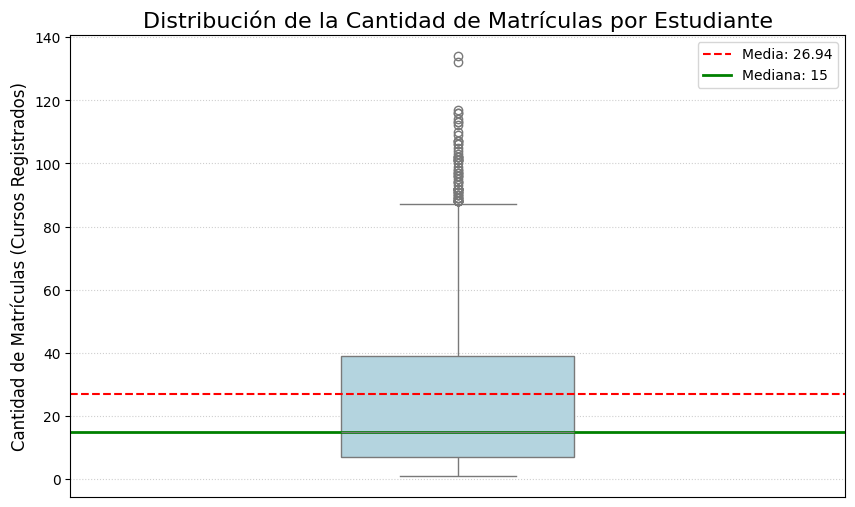

In [111]:
# 1. Calcular la cantidad de matrículas por estudiante
conteo_matriculas = df['COD_PERSONA'].value_counts()

# 2. Obtener las estadísticas clave para la leyenda del gráfico
estadisticas = conteo_matriculas.describe()

# 3. Generar el gráfico de cajas (Box Plot)
plt.figure(figsize=(10, 6))

# Dibujar el boxplot
sns.boxplot(y=conteo_matriculas, color='lightblue', width=0.3)

# Añadir la media y la mediana como líneas de referencia
plt.axhline(estadisticas['mean'], color='red', linestyle='--', linewidth=1.5, label=f'Media: {estadisticas["mean"]:.2f}')
plt.axhline(estadisticas['50%'], color='green', linestyle='-', linewidth=2, label=f'Mediana: {estadisticas["50%"]:.0f}')

# Títulos y etiquetas
plt.title('Distribución de la Cantidad de Matrículas por Estudiante', fontsize=16)
plt.ylabel('Cantidad de Matrículas (Cursos Registrados)', fontsize=12)
plt.xticks([]) # Eliminar etiquetas del eje x ya que solo hay una variable
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='dotted', alpha=0.6)

plt.show()

### COD_ALUMNO
Para la columna `COD_ALUMNO`, que también es un código identificador (`int64`), **debo aplicar el mismo tratamiento** que a `COD_PERSONA`, ya que en el contexto de un análisis de matrículas, su valor numérico es irrelevante, pero su **frecuencia** y **unicidad** son cruciales.

Por lo tanto, verificaré si `COD_ALUMNO` y `COD_PERSONA` son esencialmente la misma columna de identificación. Si el número de valores únicos (`nunique()`) es el mismo para ambos, o si hay una correspondencia uno a uno (una `PERSONA` es siempre un único `ALUMNO`), entonces la distinción entre ellas sería mínima para los cálculos de matriculación.

In [112]:
# cantidad de nulos
print('Cantidad de valores nulos en COD_PERSONA:', df['COD_PERSONA'].isnull().sum())

Cantidad de valores nulos en COD_PERSONA: 0


In [113]:
# Contar el número de valores únicos en cada columna
n_personas_unicas = df['COD_PERSONA'].nunique()
n_alumnos_unicos = df['COD_ALUMNO'].nunique()

print(f"Número de COD_PERSONA únicos: {n_personas_unicas}")
print(f"Número de COD_ALUMNO únicos: {n_alumnos_unicos}")

# Comprobar si las cuentas son idénticas
if n_personas_unicas == n_alumnos_unicos:
    print("\n✅ Las columnas tienen la MISMA cantidad de valores únicos.")
else:
    print("\n❌ Las columnas tienen DIFERENTE cantidad de valores únicos.")

Número de COD_PERSONA únicos: 2411
Número de COD_ALUMNO únicos: 2992

❌ Las columnas tienen DIFERENTE cantidad de valores únicos.



La diferencia en la cantidad de valores únicos **(COD_ALUMNO > COD_PERSONA)** me indica que, en el contexto de tu base de datos:

Una persona **(COD_PERSONA)** puede estar asociada con múltiples códigos de alumno **(COD_ALUMNO)**. Esto es la implicación directa de tener menos personas que alumnos.

**(COD_PERSONA)**  parece ser el identificador de la entidad biográfica/legal (la persona).

**(COD_ALUMNO)** parece ser el identificador de la entidad académica/matriculable (la relación activa del individuo con la institución en un momento dado, un enrollment ID o ID de expediente académico).

Hipótesis sobre la Relación 1:N

- Reingreso/Doble Matrícula: La persona pudo haber estudiado una carrera, desertado/graduado, y luego reingresado a otra carrera o programa bajo un nuevo COD_ALUMNO (un nuevo expediente académico).

- Múltiples Programas Simultáneos: La persona podría estar matriculada en dos programas diferentes al mismo tiempo, cada uno manejado con un COD_ALUMNO distinto.




In [114]:
# por cada codigo alumno cuantos cod_persona distintos hay
codigos_distintos = df.groupby('COD_ALUMNO')['COD_PERSONA'].nunique()
frecuencia_codigos = codigos_distintos.value_counts().sort_index()
frecuencia_codigos

COD_PERSONA
1    2992
Name: count, dtype: int64

In [115]:
# por cada codigo persona cuantos cod_alumno distintos hay
codigos_distintos = df.groupby('COD_PERSONA')['COD_ALUMNO'].nunique()
frecuencia_codigos = codigos_distintos.value_counts().sort_index()
frecuencia_codigos

COD_ALUMNO
1    1958
2     354
3      76
4      18
5       4
6       1
Name: count, dtype: int64

In [116]:
# NUEVA DATA CON COD PERSONA CON MULTIPLES COD ALUMNO
nueva_data = df[df['COD_PERSONA'].isin(codigos_distintos[codigos_distintos > 1].index)]
nueva_data

COD_PERSONA  COD_ALUMNO SEXO  FECHA_NACIMIENTO PER_INGRESO  \
23             821         558    M        19780905.0     2002-01   
24             821         558    M        19780905.0     2002-01   
25             821         558    M        19780905.0     2002-01   
26             821         558    M        19780905.0     2002-01   
27             821         558    M        19780905.0     2002-01   
...            ...         ...  ...               ...         ...   
64949        12604       18760    M        19921225.0     2012-02   
64950        12604       18760    M        19921225.0     2012-02   
64954         7068       15362    M        19900312.0     2011-01   
64960        25949       33948    M        19971101.0     2017-02   
64962        25949       33948    M        19971101.0     2017-02   

      ESTADO_CIVIL              TIPO_COLEGIO  PTJE_INGRESO  \
23               S        Privada Particular           NaN   
24               S        Privada Particular           NaN   
25               S        Privada Particular           NaN   
26               S        Privada Particular           NaN   
27               S        Privada Particular           NaN   
...            ...                       ...           ...   
64949            S  Pública Sector Educación          98.0   
64950            S  Pública Sector Educación          98.0   
64954            S  Pública Sector Educación           NaN   
64960            S        Privada Particular         293.0   
64962            S        Privada Particular         293.0   

                          CARRERA    ESTADO  ...  HRS_INASISTENCIA  HRS_CURSO  \
23     CIENCIA  DE LA COMPUTACIÓN  Separado  ...                 0         96   
24     CIENCIA  DE LA COMPUTACIÓN  Separado  ...                 0         80   
25     CIENCIA  DE LA COMPUTACIÓN  Separado  ...                 0         48   
26     CIENCIA  DE LA COMPUTACIÓN  Separado  ...                 0         64   
27     CIENCIA  DE LA COMPUTACIÓN  Separado  ...                 0         96   
...                           ...       ...  ...               ...        ...   
64949   CIENCIA DE LA COMPUTACIÓN   Reserva  ...                12        102   
64950   CIENCIA DE LA COMPUTACIÓN   Reserva  ...                 6         85   
64954   CIENCIA DE LA COMPUTACIÓN  Abandono  ...                24         85   
64960   CIENCIA DE LA COMPUTACIÓN   Regular  ...                 6         51   
64962   CIENCIA DE LA COMPUTACIÓN   Regular  ...                12        102   

       PRCTJE_INASISTENCIA PONDERADO  CRED_GRADUACION BECA_VIGENTE  \
23                      30    0.4568              217            0   
24                      30    0.4568              217            0   
25                      30    0.4568              217            0   
26                      30    0.4568              217            0   
27                      30    0.4568              217            0   
...                    ...       ...              ...          ...   
64949                   30   10.6325              220            0   
64950                   30   10.6325              220            0   
64954                   30   13.8967              220            0   
64960                   30   13.2491              219            1   
64962                   30   13.2491              219            1   

       NOTA_ENCUESTA_DOC NOTA_ENCUESTA_DOC_GRUPO  POBREZA_RES  POBREZA_PRO  
23                     0                     NaN     0.715245     0.715245  
24                     0                     NaN     0.715245     0.715245  
25                     0                     NaN     0.715245     0.715245  
26                     0                     NaN     0.715245     0.715245  
27                     0                     NaN     0.715245     0.715245  
...                  ...                     ...          ...          ...  
64949                  0               19.099293     6.153251    11.922520  
649

**Relación entre Personas y Expedientes:**

La relación es **Uno a Muchos (1:N)**, donde:
- Una persona (`COD_PERSONA`) puede tener muchos expedientes (`COD_ALUMNO`)
- Cada expediente pertenece a **una sola persona**


| Estadística | Valor |
|-------------|-------|
| Total de Personas Únicas | 2,411 |
| Personas con Múltiples Expedientes | 453 |
| **Porcentaje de Reingreso/Doble Matrícula** | **18.5%** |


El **18.5%** de tu población estudiantil total (454 personas) ha generado más de un expediente académico, lo cual es una cifra significativa que requiere investigación para determinar si se debe a:

- **Reingresos secuenciales**
- **Doble matrícula simultánea**

In [117]:
# 1. Agrupar por Persona y Período, contando cuántos expedientes (COD_ALUMNO) se usaron a la vez
# Esto se hace sobre la 'nueva_data', que ya está prefiltrada por personas 'multiexpediente'.
conteo_simultaneo = nueva_data.groupby(['COD_PERSONA', 'PER_MATRICULA'])['COD_ALUMNO'].nunique()

# 2. Filtrar para identificar las combinaciones Persona-Período donde el conteo es > 1
# Estas son las instancias de doble matrícula simultánea.
casos_doble_matricula = conteo_simultaneo[conteo_simultaneo > 1]

# 3. Presentar los resultados
if casos_doble_matricula.empty:
    print("✅ No se detectaron casos de doble matrícula simultánea en la 'nueva_data'.")
    print("    El 18.5% de los expedientes múltiples son probablemente REINGRESOS SECUENCIALES.")

✅ No se detectaron casos de doble matrícula simultánea en la 'nueva_data'.
    El 18.5% de los expedientes múltiples son probablemente REINGRESOS SECUENCIALES.


Las principales razones operacionales y académicas detrás de un reingreso secuencial (abrir un nuevo `COD_ALUMNO` en un período posterior) suelen ser:

- **Cambio de Carrera:** La persona estudió la Carrera A, la abandonó o se retiró formalmente, y luego regresó años más tarde para estudiar la Carrera B (o la misma carrera, pero en un plan de estudios diferente), lo que obligó al sistema a generar un nuevo expediente (`COD_ALUMNO`).

- **Reingreso Tardo (Reincorporación):** El estudiante interrumpió sus estudios por un período prolongado y, al reincorporarse, la normativa institucional exigió la apertura de un nuevo expediente en lugar de reactivar el anterior.

- **Postgrado/Segunda Especialidad:** Aunque menos común, algunos sistemas de información académica asignan un `COD_ALUMNO` distinto para estudios de postgrado o segunda especialidad, aunque la persona ya tenga un `COD_PERSONA` activo.

### SEXO

Sexo, es una variable categorica, de solo 2 valores

Valores unicos en SEXO: ['M' 'F']
Cantidad de valores nulos en SEXO: 0


/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_83302/802756720.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sexo_por_persona.index, y=sexo_por_persona.values, palette='pastel')


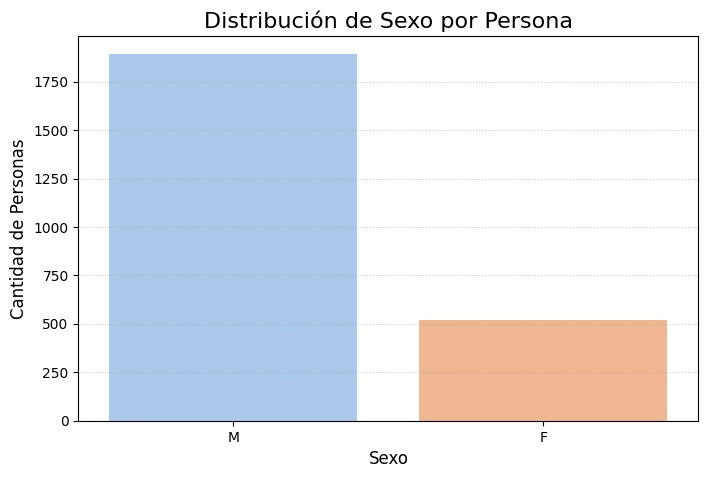

In [118]:
# valores unicos de sexo
print('Valores unicos en SEXO:', df['SEXO'].unique())

# Cantidad de nulos en sexo
print('Cantidad de valores nulos en SEXO:', df['SEXO'].isnull().sum())

#agrupar
sexo_por_persona = df.groupby('COD_PERSONA')['SEXO'].first().value_counts()

# barplot de sexo por cod_persona (agrupar por cod_persona y contar sexo)
plt.figure(figsize=(8, 5))
sns.barplot(x=sexo_por_persona.index, y=sexo_por_persona.values, palette='pastel')
plt.title('Distribución de Sexo por Persona', fontsize=16)
plt.xlabel('Sexo', fontsize=12)
plt.ylabel('Cantidad de Personas', fontsize=12)
plt.grid(axis='y', linestyle='dotted', alpha=0.6)
plt.show()

### FECHA_NACIMIENTO

Es una variable tipo temporal 

In [119]:
# cantidad de nulos en fecha nacimiento
print('Cantidad de valores nulos en FECHA_NACIMIENTO:', df['FECHA_NACIMIENTO'].isnull().sum())
# porcentaje de datos nulos
print('Porcentaje de valores nulos en FECHA_NACIMIENTO:', df['FECHA_NACIMIENTO'].isnull().mean() * 100)


# agrupemos cod_persona y fecha nacimiento para ver si hay personas con distintas fechas de nacimiento
print("Agrupando por COD_PERSONA y contando fechas de nacimiento únicas:")
fecha_nacimiento_por_persona = df.groupby('COD_PERSONA')['FECHA_NACIMIENTO'].nunique()
frecuencia_fechas = fecha_nacimiento_por_persona.value_counts().sort_index()
print(frecuencia_fechas)


# evaluar cuando ingresaron los estudiantes que no tienen fecha de nacimiento
sin_fecha_nacimiento = df[df['FECHA_NACIMIENTO'].isnull()]
print(f"\nNúmero de registros sin fecha de nacimiento: {sin_fecha_nacimiento.shape[0]}")
print("Algunos ejemplos de registros sin fecha de nacimiento:")
print(sin_fecha_nacimiento['PER_INGRESO'].value_counts().sort_index())


# contabilizar por periodo de ingreso cuatas personas(COD_PERSONA) no tienen fecha de nacimiento



Cantidad de valores nulos en FECHA_NACIMIENTO: 1745
Porcentaje de valores nulos en FECHA_NACIMIENTO: 2.6861444206702276
Agrupando por COD_PERSONA y contando fechas de nacimiento únicas:
FECHA_NACIMIENTO
0     121
1    2290
Name: count, dtype: int64

Número de registros sin fecha de nacimiento: 1745
Algunos ejemplos de registros sin fecha de nacimiento:
PER_INGRESO
1999-01    528
1999-02    180
2000-01    464
2000-02    134
2001-02      6
2002-01    380
2002-02     47
2004-01      6
Name: count, dtype: int64


In [120]:
# cantidad de nulos en fecha nacimiento
print('Cantidad de valores nulos en FECHA_NACIMIENTO:', df['FECHA_NACIMIENTO'].isnull().sum())
# porcentaje de datos nulos
print('Porcentaje de valores nulos en FECHA_NACIMIENTO:', df['FECHA_NACIMIENTO'].isnull().mean() * 100)

# agrupemos cod_persona y fecha nacimiento para ver si hay personas con distintas fechas de nacimiento
print("\nAgrupando por COD_PERSONA y contando fechas de nacimiento únicas:")
fecha_nacimiento_por_persona = df.groupby('COD_PERSONA')['FECHA_NACIMIENTO'].nunique()
frecuencia_fechas = fecha_nacimiento_por_persona.value_counts().sort_index()
print(frecuencia_fechas)

print("\nREGISTROS SIN FECHA DE NACIMIENTO POR PERIODO DE INGRESO:")
# evaluar cuando ingresaron los estudiantes que no tienen fecha de nacimiento
sin_fecha_nacimiento = df[df['FECHA_NACIMIENTO'].isnull()]
print(f"\nNúmero de registros sin fecha de nacimiento: {sin_fecha_nacimiento.shape[0]}")
print("Algunos ejemplos de registros sin fecha de nacimiento:")
print(sin_fecha_nacimiento['PER_INGRESO'].value_counts().sort_index())

# contabilizar por periodo de ingreso cuantas personas(COD_PERSONA) no tienen fecha de nacimiento
print("\nPERSONAS SIN FECHA DE NACIMIENTO POR PERIODO DE INGRESO:")

# Método 1: Contar personas únicas sin fecha de nacimiento por periodo
personas_sin_fecha = df[df['FECHA_NACIMIENTO'].isnull()].groupby('PER_INGRESO')['COD_PERSONA'].nunique()
print("Número de PERSONAS únicas sin fecha de nacimiento por periodo:")
print(personas_sin_fecha.sort_index())

Cantidad de valores nulos en FECHA_NACIMIENTO: 1745
Porcentaje de valores nulos en FECHA_NACIMIENTO: 2.6861444206702276

Agrupando por COD_PERSONA y contando fechas de nacimiento únicas:
FECHA_NACIMIENTO
0     121
1    2290
Name: count, dtype: int64

REGISTROS SIN FECHA DE NACIMIENTO POR PERIODO DE INGRESO:

Número de registros sin fecha de nacimiento: 1745
Algunos ejemplos de registros sin fecha de nacimiento:
PER_INGRESO
1999-01    528
1999-02    180
2000-01    464
2000-02    134
2001-02      6
2002-01    380
2002-02     47
2004-01      6
Name: count, dtype: int64

PERSONAS SIN FECHA DE NACIMIENTO POR PERIODO DE INGRESO:
Número de PERSONAS únicas sin fecha de nacimiento por periodo:
PER_INGRESO
1999-01    29
1999-02    12
2000-01    33
2000-02    13
2001-02     1
2002-01    36
2002-02     7
2004-01     1
Name: COD_PERSONA, dtype: int64


In [121]:
# cuantos cod_persona tienen  el 2002-01
personas_2002_01 = df[df['PER_INGRESO'] == '2002-01']['COD_PERSONA'].nunique()
print(f"Número de PERSONAS en 2002-01: {personas_2002_01}")

Número de PERSONAS en 2002-01: 96


debido a la presencia predominante de nulos en periodos de ingreso particulares, a pesar que el porcentaje de nulos sea 2.81% se realizara la imputacion.

El metodo de imputacion por fechas es complicado, por ello nos apoyaremos en el periodo de ingreso, calcularemos la edad promedio con la que un estudiante promedio ingresa a la universidad, y luego restaremos dicha edad al periodo de ingreso, obteniendo una imputacion de la fecha de nacimiento 

**Lógica**
- Agrupar por persona (COD_PERSONA), ya que puede tener varios COD_ALUMNO.
- Obtener la primera ocurrencia de ingreso (el periodo más antiguo, porque representa su ingreso inicial).
- Mantener la fecha de nacimiento si existe, y si no, se imputará luego.
- Calcular la edad promedio de ingreso entre quienes sí tienen fecha válida.
- Imputar las fechas faltantes restando esa edad promedio (en años) al periodo de ingreso.



   COD_PERSONA FECHA_NACIMIENTO PER_INGRESO
0          577       1984-10-04     2002-01
1          577       1984-10-04     2002-01
2          577       1984-10-04     2002-01
3          577       1984-10-04     2002-01
4          577       1984-10-04     2002-01
   COD_PERSONA FECHA_NACIMIENTO PER_INGRESO
0          577       1984-10-04     2002-01
1          577       1984-10-04     2002-01
2          577       1984-10-04     2002-01
3          577       1984-10-04     2002-01
4          577       1984-10-04     2002-01
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411 entries, 0 to 2410
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   COD_PERSONA        2411 non-null   int64         
 1   FECHA_NACIMIENTO   2290 non-null   datetime64[ns]
 2   PER_INGRESO_FECHA  2411 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 56.6 KB
Edad promedio de ingreso: 18 años

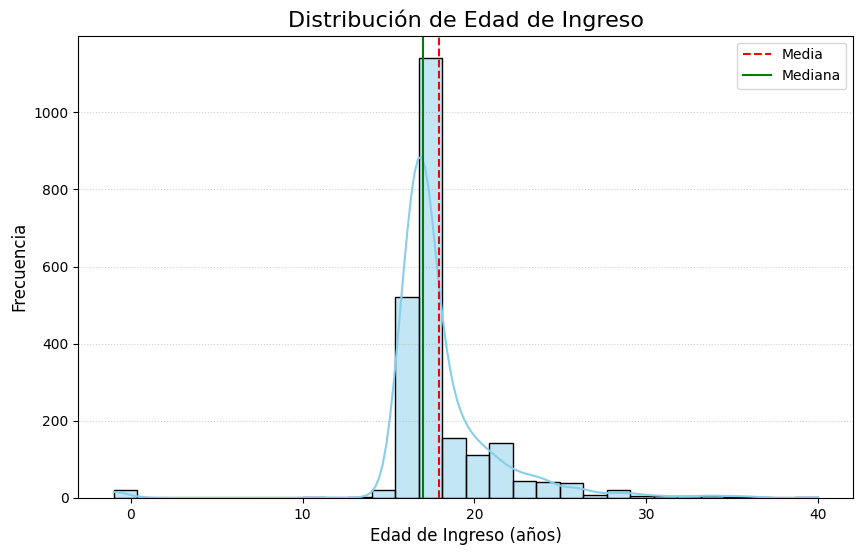

EDAD_INGRESO
-1      19
 0       2
 11      1
 14      1
 15     19
 16    522
 17    844
 18    298
 19    156
 20    112
 21     86
 22     56
 23     43
 24     41
 25     16
 26     23
 27      8
 28      8
 29     11
 30      4
 31      4
 32      1
 33      4
 34      4
 35      3
 36      3
 40      1
Name: count, dtype: int64


In [122]:
# 1️⃣ Convertir la fecha de nacimiento a string, eliminando decimales y nulos
df['FECHA_NACIMIENTO'] = (
    df['FECHA_NACIMIENTO']
    .dropna()
    .astype(int)
    .astype(str)
)

# 2️⃣ Convertir al tipo datetime con formato AAAAMMDD
df['FECHA_NACIMIENTO'] = pd.to_datetime(df['FECHA_NACIMIENTO'], format='%Y%m%d', errors='coerce')

# 1️⃣ Subconjunto relevante
df_sub = df[['COD_PERSONA', 'FECHA_NACIMIENTO', 'PER_INGRESO']].copy()
print(df_sub.head())

# 2️⃣ Convertir fecha de nacimiento
df_sub['FECHA_NACIMIENTO'] = pd.to_datetime(df_sub['FECHA_NACIMIENTO'], errors='coerce')
print(df_sub.head())
# 3️⃣ Convertir PER_INGRESO a fecha estimada según semestre
def periodo_a_fecha(periodo):
    try:
        anio, sem = periodo.split('-')
        anio = int(anio)
        sem = int(sem)
        if sem == 1:
            return pd.Timestamp(f"{anio}-03-01")  # primer semestre → marzo
        elif sem == 2:
            return pd.Timestamp(f"{anio}-08-01")  # segundo semestre → agosto
    except:
        return pd.NaT

df_sub['PER_INGRESO_FECHA'] = df_sub['PER_INGRESO'].apply(periodo_a_fecha)

# 4️⃣ Tomar el primer periodo de ingreso por persona
df_min = df_sub.groupby('COD_PERSONA', as_index=False).agg({
    'FECHA_NACIMIENTO': 'first',
    'PER_INGRESO_FECHA': 'min'
})

df_min.info()
df_min.head()

# 5️⃣ Calcular edad en años completos
df_valid = df_min.dropna(subset=['FECHA_NACIMIENTO']).copy()
df_valid['EDAD_INGRESO'] = df_valid.apply(
    lambda x: x['PER_INGRESO_FECHA'].year - x['FECHA_NACIMIENTO'].year -
    ((x['PER_INGRESO_FECHA'].month, x['PER_INGRESO_FECHA'].day) <
     (x['FECHA_NACIMIENTO'].month, x['FECHA_NACIMIENTO'].day)),
    axis=1
)

# 6️⃣ Calcular edad promedio
edad_promedio = round(df_valid['EDAD_INGRESO'].mean())

print(f"Edad promedio de ingreso: {edad_promedio} años")
# df_valid cuando la edad es menor a 15 años
print(df_valid['EDAD_INGRESO'].describe())
print(df_valid[df_valid['EDAD_INGRESO'] < 15])
print (df_valid['EDAD_INGRESO'].describe())
# barplot de edad ingreso
plt.figure(figsize=(10, 6))
sns.histplot(df_valid['EDAD_INGRESO'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de Edad de Ingreso', fontsize=16)
plt.xlabel('Edad de Ingreso (años)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(df_valid['EDAD_INGRESO'].mean(), color='red', linestyle='--', label='Media')
plt.axvline(df_valid['EDAD_INGRESO'].median(), color='green', linestyle='-', label='Mediana')
plt.legend()
plt.grid(axis='y', linestyle='dotted', alpha=0.6)
plt.show()
print(df_valid['EDAD_INGRESO'].value_counts().sort_index())



In [123]:
# 7️⃣ Imputar fechas faltantes o edades irreales (<10 años)
df_min['FECHA_NACIMIENTO_IMPUTADA'] = df_min['FECHA_NACIMIENTO']

# Personas con edad < 10
cod_menores_10 = df_valid.loc[df_valid['EDAD_INGRESO'] < 10, 'COD_PERSONA']

# Máscara combinada: nulos o menores de 10
mask = df_min['FECHA_NACIMIENTO'].isna() | df_min['COD_PERSONA'].isin(cod_menores_10)

# Imputar usando la edad promedio
df_min.loc[mask, 'FECHA_NACIMIENTO_IMPUTADA'] = df_min.loc[mask, 'PER_INGRESO_FECHA'] - pd.DateOffset(years=edad_promedio)

# 🔚 Resultado final
df_final = df_min[['COD_PERSONA', 'PER_INGRESO_FECHA', 'FECHA_NACIMIENTO_IMPUTADA']]


In [124]:
# Se logro eliminar los nulos
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411 entries, 0 to 2410
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   COD_PERSONA                2411 non-null   int64         
 1   PER_INGRESO_FECHA          2411 non-null   datetime64[ns]
 2   FECHA_NACIMIENTO_IMPUTADA  2411 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 56.6 KB


In [125]:
# Se procede a rellenar df con las fechas imputadas
df = df.merge(df_final[['COD_PERSONA', 'FECHA_NACIMIENTO_IMPUTADA']], on='COD_PERSONA', how='left')
df = df.drop(columns=['FECHA_NACIMIENTO'])
df = df.rename(columns={'FECHA_NACIMIENTO_IMPUTADA': 'FECHA_NACIMIENTO'})

# cantidad de nulos en fecha nacimiento
print('Cantidad de valores nulos en FECHA_NACIMIENTO:', df['FECHA_NACIMIENTO'].isnull().sum())


Cantidad de valores nulos en FECHA_NACIMIENTO: 0


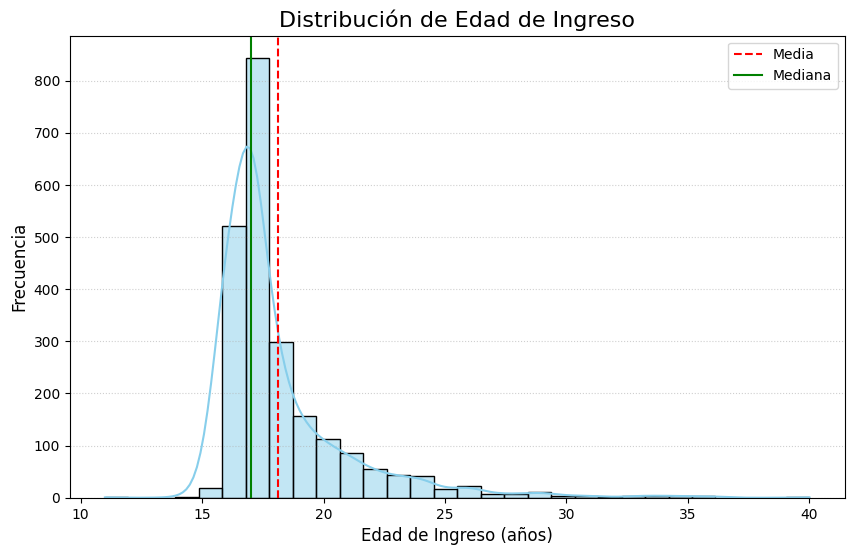

In [126]:
# eliminar filas con edad menor a 10 años
df_valid = df_valid[df_valid['EDAD_INGRESO'] >= 10]
plt.figure(figsize=(10, 6))
sns.histplot(df_valid['EDAD_INGRESO'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de Edad de Ingreso', fontsize=16)
plt.xlabel('Edad de Ingreso (años)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.axvline(df_valid['EDAD_INGRESO'].mean(), color='red', linestyle='--', label='Media')
plt.axvline(df_valid['EDAD_INGRESO'].median(), color='green', linestyle='-', label='Mediana')
plt.legend()
plt.grid(axis='y', linestyle='dotted', alpha=0.6)
plt.show()


Con ello tenemos las fechas, que nos llevaran a las edades, correctamente imputadas, finalizando con 0 nulos

### POBREZA (PROCEDENCIA Y RESIDENCIA)

Se tuvo una variable categorica que se compone de 3 componentes: Departamente / Provincia / Distrito (tanto para procedencia y residencia). Sin embargo con el fin de anonimizar los datos ya que es una data sencible, se hizo con antelacion a este eda un feature engineering para conseguir ambas pobrezas. A continuacion se brinda un resumen breve:

La variable `PROCEDENCIA` presenta **158 valores únicos**, lo cual la hace poco conveniente para ser usada directamente en un modelo, pues su alta cardinalidad podría afectar su desempeño. Además, considerando que a nivel nacional hay más de **1,800 distritos**, esta cifra podría seguir creciendo con nuevos datos, lo que la haría aún menos práctica.

Por ello, se propone **extraer nuevas características** a partir de la dirección de procedencia y residencia, haciendo uso de fuentes estadísticas oficiales del Perú:

- **Porcentaje de pobreza total por distrito**: se obtendrá del Mapa de Pobreza del INEI. [(INEI – Mapa de Pobreza)](https://www.gob.pe/institucion/inei/colecciones/6608-mapa-de-pobreza)  

Con esta nueva variable se podrá capturar la dimensión socioeconómica del lugar de procedencia, reduciendo la cardinalidad del feature `PROCEDENCIA` y `RESIDENCIA` y agregando información útil al modelo.

Para ello, se uso `DEPARTAMENTO_PRO`,`PROVINCIA_PRO`, `DISTRITO_PRO` y `DEPARTAMENTO_RES`,`PROVINCIA_RES`, `DISTRITO_RES`.



### PER_INGRESO


In [127]:
df_final = df.copy()

Total de personas únicas: 2,992

Ejemplo de valores únicos en PER_INGRESO:
['1999-01' '1999-02' '2000-01' '2000-02' '2001-01' '2001-02' '2002-01'
 '2002-02' '2003-01' '2003-02' '2004-01' '2004-02' '2005-01' '2005-02'
 '2006-01' '2006-02' '2007-01' '2007-02' '2008-01' '2008-02' '2009-01'
 '2009-02' '2010-01' '2010-02' '2011-01' '2011-02' '2012-01' '2012-02'
 '2013-01' '2013-02' '2014-01' '2014-02' '2015-01' '2015-02' '2016-01'
 '2016-02' '2017-01' '2017-02' '2018-01' '2018-02' '2019-01' '2019-02'
 '2020-01' '2020-02']

Distribución de ingresos por año:
AÑO_INGRESO
1999     70
2000     94
2001    109
2002    126
2003    131
2004    131
2005    136
2006    187
2007    118
2008    171
2009    193
2010    181
2011    163
2012    110
2013    123
2014    155
2015    133
2016    128
2017    129
2018    129
2019    136
2020    139
Name: count, dtype: int64

Estadísticas descriptivas del año de ingreso:
count    2992.000000
mean     2009.878008
std         5.947516
min      1999.000000
25%      

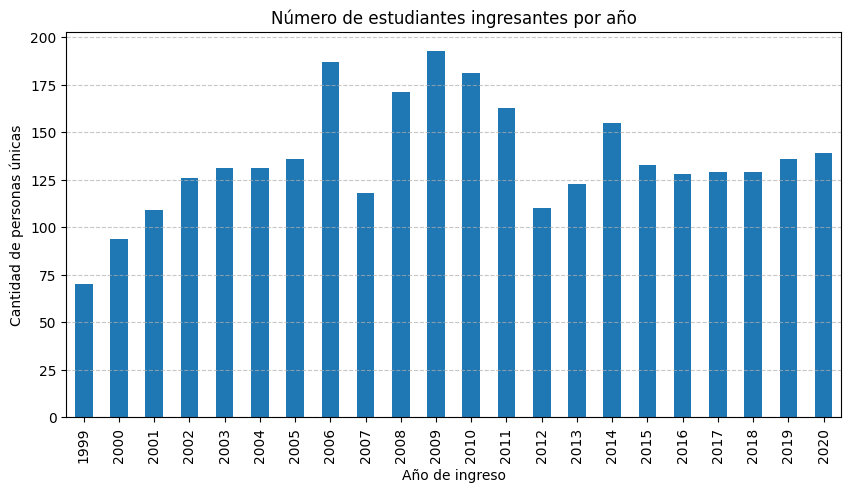

<Figure size 1000x500 with 0 Axes>

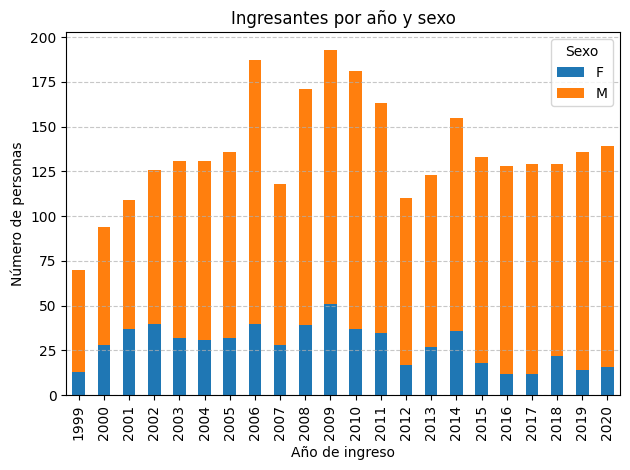

Cantidad de COD_ALUMNO con múltiples PER_INGRESO: 0


In [128]:
# --- 1. Crear tabla única de personas con su periodo de ingreso ---
df_ingreso = df_final[['COD_PERSONA', 'COD_ALUMNO' ,  'PER_INGRESO', 'SEXO', 'CARRERA']].drop_duplicates(subset='COD_ALUMNO')

print(f"Total de personas únicas: {len(df_ingreso):,}")
print("\nEjemplo de valores únicos en PER_INGRESO:")

# valores unicos de PER_INGRESO ordenados
print(np.sort(df_ingreso['PER_INGRESO'].unique()))
# --- 2. Limpieza (si PER_INGRESO tiene espacios o formato inconsistente) ---
df_ingreso['PER_INGRESO'] = df_ingreso['PER_INGRESO'].astype(str).str.strip()

# --- 3. Extraer el año (si el formato es '2019-1' o '2020-2') ---
df_ingreso['AÑO_INGRESO'] = df_ingreso['PER_INGRESO'].str.extract(r'(\d{4})').astype(int)

# --- 4. Distribución de ingresos por año ---
ingresos_por_año = df_ingreso['AÑO_INGRESO'].value_counts().sort_index()

print("\nDistribución de ingresos por año:")
print(ingresos_por_año)

# --- 5. Estadísticas descriptivas ---
print("\nEstadísticas descriptivas del año de ingreso:")
print(df_ingreso['AÑO_INGRESO'].describe())

# --- 6. Gráfico de barras (cantidad de ingresantes por año) ---
plt.figure(figsize=(10,5))
ingresos_por_año.plot(kind='bar')
plt.title("Número de estudiantes ingresantes por año")
plt.xlabel("Año de ingreso")
plt.ylabel("Cantidad de personas únicas")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 7. Análisis por sexo (opcional) ---
ingresos_por_año_sexo = df_ingreso.groupby(['AÑO_INGRESO', 'SEXO']).size().unstack(fill_value=0)

plt.figure(figsize=(10,5))
ingresos_por_año_sexo.plot(kind='bar', stacked=True)
plt.title("Ingresantes por año y sexo")
plt.xlabel("Año de ingreso")
plt.ylabel("Número de personas")
plt.legend(title='Sexo')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


df_personas = df_final[['COD_ALUMNO', 'PER_INGRESO']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples PER_INGRESO:", repetidos['COD_ALUMNO'].nunique())

### ESTADO_CIVIL



🔹 Distribución de ESTADO_CIVIL:
              Frecuencia  Porcentaje (%)
ESTADO_CIVIL                            
S                   2324           96.39
C                     87            3.61


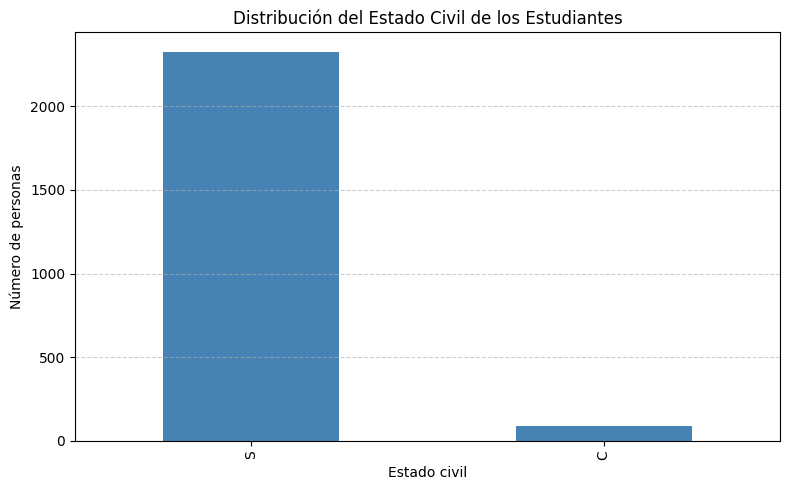

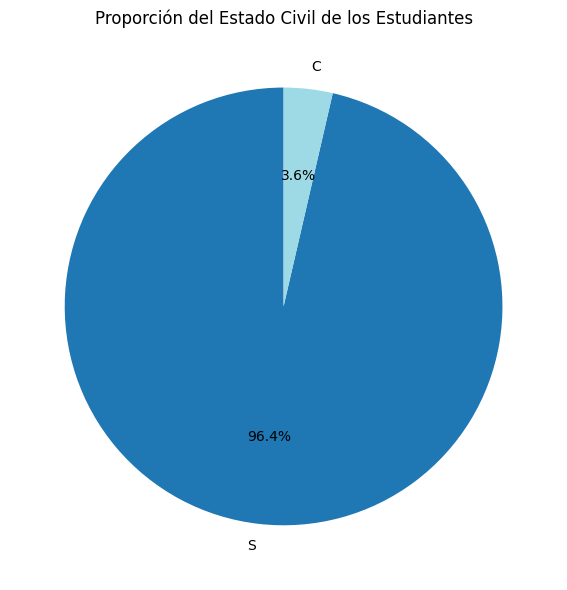

Cantidad de COD_ALUMNO con múltiples ESTADO_CIVIL: 0


In [129]:
# --- 1. Crear tabla única por persona (por si no la tienes cargada aún) ---
df_personas = df_final[['COD_PERSONA', 'SEXO', 'ESTADO_CIVIL', 
                        'POBREZA_RES', 'POBREZA_PRO', 'FECHA_NACIMIENTO']].drop_duplicates(subset='COD_PERSONA')

# Seleccionar columnas relevantes
df_personas = df_final[['COD_PERSONA', 'ESTADO_CIVIL']].drop_duplicates(subset='COD_PERSONA')

# Total de personas únicas
total_personas = df_personas.shape[0]

# Valores únicos
valores_unicos = df_personas['ESTADO_CIVIL'].unique()

# Conteo de valores
conteo = df_personas['ESTADO_CIVIL'].value_counts(dropna=False)

# Porcentaje de datos faltantes
faltantes = df_personas['ESTADO_CIVIL'].isna().sum()
porc_faltantes = (faltantes / total_personas) * 100



# --- 2. Limpieza de la variable ---
df_personas['ESTADO_CIVIL'] = (
    df_personas['ESTADO_CIVIL']
    .astype(str)
    .str.strip()
    .str.upper()  # para uniformizar (e.g. 'Soltero', 'SOLTERO', etc.)
)


# --- 3. Frecuencias absolutas y relativas ---
frecuencias = df_personas['ESTADO_CIVIL'].value_counts()
porcentajes = df_personas['ESTADO_CIVIL'].value_counts(normalize=True) * 100

print("🔹 Distribución de ESTADO_CIVIL:")
print(pd.DataFrame({'Frecuencia': frecuencias, 'Porcentaje (%)': porcentajes.round(2)}))

# --- 4. Gráfico de barras ---
plt.figure(figsize=(8,5))
frecuencias.plot(kind='bar', color='steelblue')
plt.title("Distribución del Estado Civil de los Estudiantes")
plt.xlabel("Estado civil")
plt.ylabel("Número de personas")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 5. Gráfico de pastel ---
plt.figure(figsize=(6,6))
porcentajes.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='tab20')
plt.title("Proporción del Estado Civil de los Estudiantes")
plt.ylabel("")
plt.tight_layout()
plt.show()

df_personas = df_final[['COD_ALUMNO', 'ESTADO_CIVIL']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples ESTADO_CIVIL:", repetidos['COD_ALUMNO'].nunique())



### TIPO_COLEGIO

In [130]:

df_personas = df_final[['COD_PERSONA', 'TIPO_COLEGIO']].drop_duplicates()
# Cuantos COD_PERSONA se repiten con diferentes TIPO_COLEGIO
repetidos = df_personas[df_personas.duplicated(subset=['COD_PERSONA'], keep=False)]
print("Cantidad de COD_PERSONA con múltiples TIPO_COLEGIO:", repetidos['COD_PERSONA'].nunique())
# Dimensiones del dataframe de personas
print("Dimensiones de df_personas:", df_personas.shape)
# valores unicos de TIPO_COLEGIO
print('Valores unicos en TIPO_COLEGIO:', df_personas['TIPO_COLEGIO'].unique())
# valores nulos de TIPO_COLEGIO
print('Cantidad de valores nulos en TIPO_COLEGIO:', df_personas['TIPO_COLEGIO'].isnull().sum())


Cantidad de COD_PERSONA con múltiples TIPO_COLEGIO: 0
Dimensiones de df_personas: (2411, 2)
Valores unicos en TIPO_COLEGIO: ['Privada Particular' 'Privada Parroquial' 'Pública otro Sector Público'
 nan 'Pública en Convenio' 'Pública Sector Educación'
 'Privada Instituciones Benéficas' 'Privada Fiscalizada' 'Fuera del Perú']
Cantidad de valores nulos en TIPO_COLEGIO: 246


Valores únicos en TIPO_COLEGIO (ignorando nulos): ['Privada Particular' 'Privada Parroquial' 'Pública otro Sector Público'
 'Pública en Convenio' 'Pública Sector Educación'
 'Privada Instituciones Benéficas' 'Privada Fiscalizada' 'Fuera del Perú']

Distribución de TIPO_COLEGIO:
                   TIPO_COLEGIO  Frecuencia  Porcentaje
             Privada Particular        1366   63.094688
       Pública Sector Educación         333   15.381062
             Privada Parroquial         225   10.392610
            Pública en Convenio         180    8.314088
    Pública otro Sector Público          50    2.309469
            Privada Fiscalizada           5    0.230947
                 Fuera del Perú           4    0.184758
Privada Instituciones Benéficas           2    0.092379


<Figure size 1000x500 with 0 Axes>

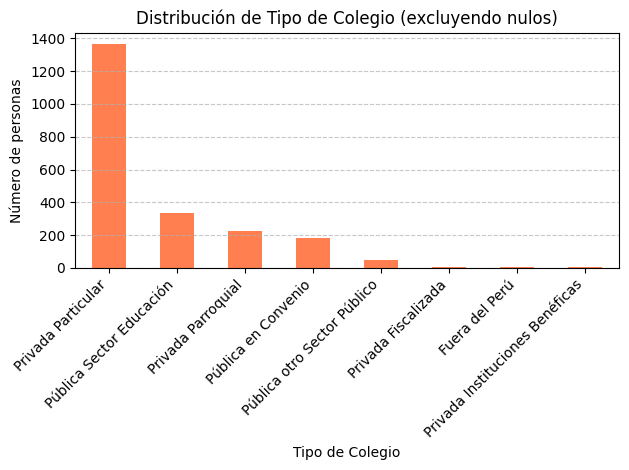

In [131]:
# Ignorar nulos
df_personas_no_null = df_personas.dropna(subset=['TIPO_COLEGIO'])

total_personas = len(df_personas_no_null)

# Valores únicos
valores_unicos = df_personas_no_null['TIPO_COLEGIO'].unique()
print(f"Valores únicos en TIPO_COLEGIO (ignorando nulos): {valores_unicos}")

# Conteo y porcentaje
dist_tipo = df_personas_no_null['TIPO_COLEGIO'].value_counts().reset_index()
dist_tipo.columns = ['TIPO_COLEGIO', 'Frecuencia']
dist_tipo['Porcentaje'] = (dist_tipo['Frecuencia'] / total_personas) * 100

print("\nDistribución de TIPO_COLEGIO:")
print(dist_tipo.to_string(index=False))

# Gráfico
plt.figure(figsize=(10,5))
dist_tipo.plot(kind='bar', x='TIPO_COLEGIO', y='Frecuencia', color='coral', legend=False)
plt.title('Distribución de Tipo de Colegio (excluyendo nulos)')
plt.xlabel('Tipo de Colegio')
plt.ylabel('Número de personas')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

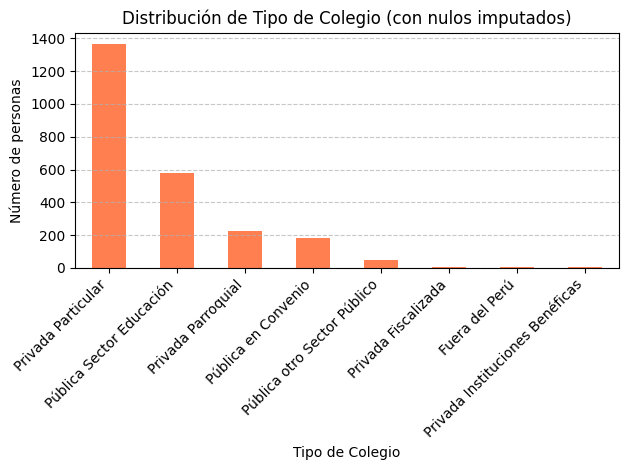

In [132]:
# imputa los datos faltantes de de TIPO_COLEGIO con Pública Sector Educación
df_final['TIPO_COLEGIO'] = df_final['TIPO_COLEGIO'].fillna('Pública Sector Educación')
df_personas['TIPO_COLEGIO'] = df_personas['TIPO_COLEGIO'].fillna('Pública Sector Educación')
# Gráfico
plt.figure(figsize=(10,5))
dist_tipo = df_personas['TIPO_COLEGIO'].value_counts().reset_index()
dist_tipo.columns = ['TIPO_COLEGIO', 'Frecuencia']
dist_tipo.plot(kind='bar', x='TIPO_COLEGIO', y='Frecuencia', color='coral', legend=False)
plt.title('Distribución de Tipo de Colegio (con nulos imputados)')
plt.xlabel('Tipo de Colegio')
plt.ylabel('Número de personas')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [133]:
df_personas = df_final[['COD_ALUMNO', 'TIPO_COLEGIO']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples TIPO_COLEGIO:", repetidos['COD_ALUMNO'].nunique())

Cantidad de COD_ALUMNO con múltiples TIPO_COLEGIO: 0


### PTJE_INGRESO

Cantidad de COD_ALUMNO con múltiples PTJE_INGRESO: 0
(2992, 3)
    COD_ALUMNO  PTJE_INGRESO PER_INGRESO
0          547           NaN     2002-01
5          548           NaN     2002-01
11         550           NaN     2002-01
17         553           NaN     2002-01
23         558           NaN     2002-01
Valores únicos en PTJE_INGRESO: [ nan 113. 120.  73. 107.  93. 127.  87. 133. 100.  80.  90. 105. 150.
 128. 135. 143.  98.  83.  40.  67.  53. 315. 405. 203. 221. 324. 293.
 383.  75. 154.  86. 137. 145. 162.  68. 428. 270.  60. 338. 248. 360.
   0. 163. 183. 167. 226. 161. 185. 220. 187. 160. 178. 169. 180. 181.
 215. 207. 158. 328. 357. 272. 172. 287. 232. 362. 210. 246. 297. 240.
 236. 196. 217. 262. 242. 245. 192. 157. 281. 255. 325. 335. 250. 186.
 199. 259. 176. 173. 279. 213. 188. 304. 211. 238. 233. 174. 170. 195.
 291. 263. 204. 147. 228. 231. 268. 223. 216. 314. 219. 218. 288. 235.
 298. 214. 198. 206. 153. 334. 194. 247. 252.   1. 230. 182. 165. 237.
 244. 164. 311. 197.

/Users/stewart/2025-2/ML/ML_P3/venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/stewart/2025-2/ML/ML_P3/venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/stewart/2025-2/ML/ML_P3/venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/stewart/2025-2/ML/ML_P3/venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/stewart/2025-2/ML/ML_P3/venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/stewart/2025-

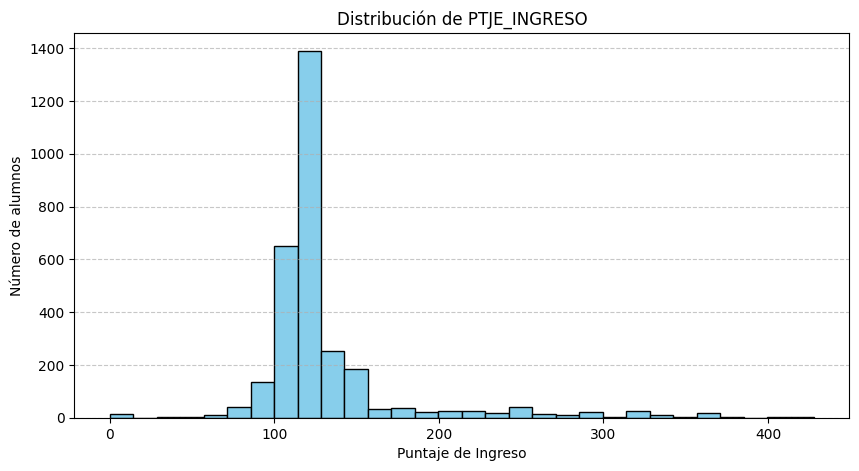

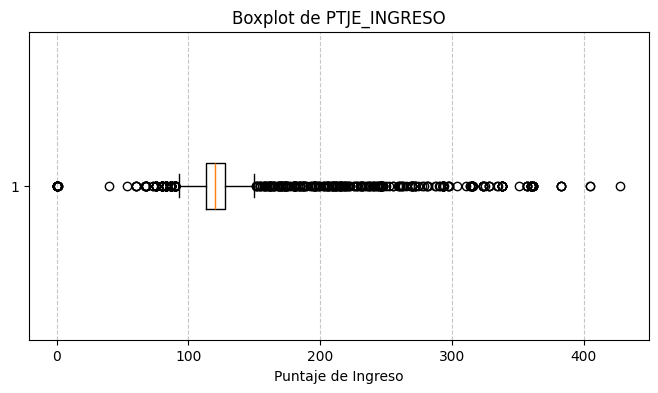


Distribución de PTJE_INGRESO por rangos:
                Frecuencia  Porcentaje
PTJE_INGRESO                          
(-0.428, 42.8]          15    0.501337
(42.8, 85.6]            53    1.771390
(85.6, 128.4]         2177   72.760695
(128.4, 171.2]         472   15.775401
(171.2, 214.0]          85    2.840909
(214.0, 256.8]          82    2.740642
(256.8, 299.6]          45    1.504011
(299.6, 342.4]          38    1.270053
(342.4, 385.2]          22    0.735294
(385.2, 428.0]           3    0.100267


In [134]:
### 
# --- 1. Crear tabla única por persona (por si no la tienes cargada aún) ---
df_personas = df_final[['COD_ALUMNO', 'PTJE_INGRESO', 'PER_INGRESO']].drop_duplicates()
# Cuantos COD_ALUMNO se repiten con diferentes PTJE_INGRESO
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples PTJE_INGRESO:", repetidos['COD_ALUMNO'].nunique())

# Dimensiones 
print(df_personas.shape)


total_alumnos = len(df_personas)
print(df_personas.head())
# Valores únicos
valores_unicos = df_personas['PTJE_INGRESO'].unique()
print(f"Valores únicos en PTJE_INGRESO: {valores_unicos}")

# Valores nulos
faltantes = df_personas['PTJE_INGRESO'].isnull().sum()
porc_faltantes = (faltantes / total_alumnos) * 100
print(f"Valores nulos: {faltantes} ({porc_faltantes:.2f}%)")

# Paso 1: imputación por periodo
df_personas['PTJE_INGRESO'] = df_personas.groupby('PER_INGRESO')['PTJE_INGRESO'] \
                                        .transform(lambda x: x.fillna(x.median()))

# Paso 2: imputación global para los que quedan NaN
df_personas['PTJE_INGRESO'].fillna(df_personas['PTJE_INGRESO'].median(), inplace=True)



# Valores nulos
print("\nDespués de la imputación:")
faltantes = df_personas['PTJE_INGRESO'].isnull().sum()
porc_faltantes = (faltantes / total_alumnos) * 100
print(f"Valores nulos despues de la imputacion: {faltantes} ({porc_faltantes:.2f}%)")

# Estadísticos descriptivos
estad_desc = df_personas['PTJE_INGRESO'].describe()
print("\nEstadísticos descriptivos de PTJE_INGRESO:")
print(estad_desc)

# Histograma
plt.figure(figsize=(10,5))
plt.hist(df_personas['PTJE_INGRESO'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de PTJE_INGRESO')
plt.xlabel('Puntaje de Ingreso')
plt.ylabel('Número de alumnos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Boxplot
plt.figure(figsize=(8,4))
plt.boxplot(df_personas['PTJE_INGRESO'].dropna(), vert=False)
plt.title('Boxplot de PTJE_INGRESO')
plt.xlabel('Puntaje de Ingreso')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# --- Distribución por rangos (opcional) ---
rangos = pd.cut(df_personas['PTJE_INGRESO'], bins=10)
frecuencia_rangos = rangos.value_counts().sort_index()
porcentaje_rangos = (frecuencia_rangos / total_alumnos) * 100
dist_rangos = pd.DataFrame({'Frecuencia': frecuencia_rangos, 'Porcentaje': porcentaje_rangos})
print("\nDistribución de PTJE_INGRESO por rangos:")
print(dist_rangos)



In [135]:
# --- Paso 1: unir df_final con los puntajes de df_personas ---
print("Columnas df_final antes del merge:", df_final.columns)
print("Columnas df_personas:", df_personas.columns)

df_final = df_final.merge(df_personas[['COD_ALUMNO', 'PTJE_INGRESO']], 
                          on='COD_ALUMNO', how='left', suffixes=('', '_imputado'))

# --- Usar la columna imputada y eliminar duplicados ---
df_final['PTJE_INGRESO'] = df_final['PTJE_INGRESO_imputado']
df_final = df_final.drop(columns=['PTJE_INGRESO_imputado'])

# --- Paso 2: eliminar filas con PTJE_INGRESO extremadamente bajo ---
df_final = df_final[~df_final['PTJE_INGRESO'].between(-0.428, 42.8, inclusive='right')]

# --- Verificación ---
print("Dimensiones después de limpieza:", df_final.shape)
print("Estadísticos de PTJE_INGRESO:")
print(df_final['PTJE_INGRESO'].describe())




df_personas = df_final[['COD_ALUMNO', 'PTJE_INGRESO']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples PTJE_INGRESO:", repetidos['COD_ALUMNO'].nunique())


Columnas df_final antes del merge: Index(['COD_PERSONA', 'COD_ALUMNO', 'SEXO', 'PER_INGRESO', 'ESTADO_CIVIL',
       'TIPO_COLEGIO', 'PTJE_INGRESO', 'CARRERA', 'ESTADO', 'SEM_ALUMNO',
       'SEM_CURSADOS', 'CANT_RESERVAS', 'PER_MATRICULA', 'COD_CURSO', 'CURSO',
       'CREDITOS', 'TIPO_CURSO', 'COD_PLAN', 'COD_GRUPO', 'GRUPO', 'NOTA',
       'APROBO', 'HRS_INASISTENCIA', 'HRS_CURSO', 'PRCTJE_INASISTENCIA',
       'PONDERADO', 'CRED_GRADUACION', 'BECA_VIGENTE', 'NOTA_ENCUESTA_DOC',
       'NOTA_ENCUESTA_DOC_GRUPO', 'POBREZA_RES', 'POBREZA_PRO',
       'FECHA_NACIMIENTO'],
      dtype='object')
Columnas df_personas: Index(['COD_ALUMNO', 'PTJE_INGRESO', 'PER_INGRESO'], dtype='object')
Dimensiones después de limpieza: (64763, 33)
Estadísticos de PTJE_INGRESO:
count    64763.000000
mean       127.815234
std         35.680941
min         53.000000
25%        113.000000
50%        120.000000
75%        128.000000
max        428.000000
Name: PTJE_INGRESO, dtype: float64
Cantidad de COD_ALUMNO

### CARRERA

In [136]:
# valores unicos de carrera
uniq_carreras = df_final['CARRERA'].unique()
print('Valores unicos en CARRERA:', uniq_carreras)
# valores nulos de carrera
print('Cantidad de valores nulos en CARRERA:', df_final['CARRERA'].isnull().sum())

Valores unicos en CARRERA: ['CIENCIA  DE LA COMPUTACIÓN' 'CIENCIA DE LA COMPUTACIÓN']
Cantidad de valores nulos en CARRERA: 0


In [137]:
# eliminar columna
df_final = df_final.drop(columns=['CARRERA'], errors='ignore')

### ESTADO

In [138]:
# valore unicos de ESTADO 
uniq_estados = df_final['ESTADO'].unique()
print('Valores unicos en ESTADO:', uniq_estados)
# valores nulos de ESTADO
print('Cantidad de valores nulos en ESTADO:', df_final['ESTADO'].isnull().sum())

Valores unicos en ESTADO: ['Separado' 'Egresado' 'Traslado' 'Retirado' 'Abandono' 'Regular'
 'Fallecido' 'Reserva']
Cantidad de valores nulos en ESTADO: 0


Cantidad de COD_ALUMNO con múltiples ESTADO: 0
Total de alumnos únicos: 2977
Valores nulos en ESTADO: 0
Valores únicos: ['Egresado' 'Retirado' 'Separado' 'Abandono' 'Traslado' 'Regular'
 'Fallecido' 'Reserva']
           Frecuencia  Porcentaje (%)
ESTADO                               
Separado         1159           38.93
Abandono          601           20.19
Retirado          352           11.82
Regular           305           10.25
Egresado          283            9.51
Traslado          252            8.46
Reserva            24            0.81
Fallecido           1            0.03


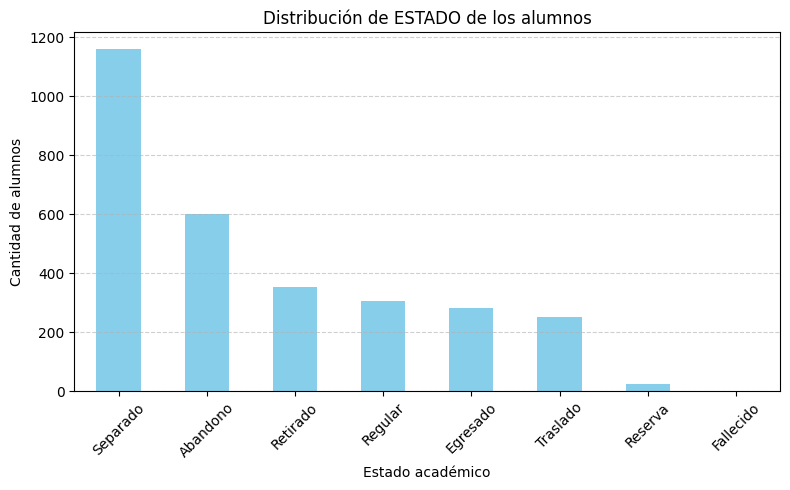

In [139]:
# Agrupar por alumno (para no repetir estados en cursos distintos)
df_estado = df_final.groupby('COD_ALUMNO', as_index=False).agg({'ESTADO': 'first'})


df_personas = df_final[['COD_ALUMNO', 'ESTADO']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples ESTADO:", repetidos['COD_ALUMNO'].nunique())


# Verificar
print('Total de alumnos únicos:', df_estado.shape[0])
print('Valores nulos en ESTADO:', df_estado['ESTADO'].isnull().sum())
print('Valores únicos:', df_estado['ESTADO'].unique())

# Conteo absoluto y relativo
conteo = df_estado['ESTADO'].value_counts(dropna=False)
porcentaje = df_estado['ESTADO'].value_counts(normalize=True, dropna=False) * 100

# Combinar ambos
tabla_estado = pd.DataFrame({'Frecuencia': conteo, 'Porcentaje (%)': porcentaje.round(2)})
print(tabla_estado)

plt.figure(figsize=(8,5))
tabla_estado['Frecuencia'].dropna().plot(kind='bar', color='skyblue')
plt.title('Distribución de ESTADO de los alumnos')
plt.ylabel('Cantidad de alumnos')
plt.xlabel('Estado académico')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



### SEM_ALUMNO

In [140]:
df_personas = df_final[['COD_ALUMNO', 'SEM_ALUMNO']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples SEM_ALUMNO:", repetidos['COD_ALUMNO'].nunique())

# Valores unicos de SEM_ALUMNO
uniq_sems = df_final['SEM_ALUMNO'].unique()
print('Valores unicos en SEM_ALUMNO:', uniq_sems)
# Valores nulos de SEM_ALUMNO
print('Cantidad de valores nulos en SEM_ALUMNO:', df_final['SEM_ALUMNO'].isnull().sum())

Cantidad de COD_ALUMNO con múltiples SEM_ALUMNO: 0
Valores unicos en SEM_ALUMNO: [ 7 10  4  1  2  3  6  9  5  8]
Cantidad de valores nulos en SEM_ALUMNO: 0


### SEM_CURSADOS

In [141]:
df_personas = df_final[['COD_ALUMNO', 'SEM_CURSADOS']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples SEM_CURSADOS:", repetidos['COD_ALUMNO'].nunique())

# Valores unicos de SEM_ALUMNO
uniq_sems = df_final['SEM_CURSADOS'].unique()
print('Valores unicos en SEM_CURSADOS:', uniq_sems)
# Valores nulos de SEM_CURSADOS ordenados
print('Cantidad de valores nulos en SEM_CURSADOS:', df_final['SEM_CURSADOS'].isnull().sum())

Cantidad de COD_ALUMNO con múltiples SEM_CURSADOS: 0
Valores unicos en SEM_CURSADOS: [16 17  5  1  4  2 21  6 12  8 14 11 28 18 10 15  3  9 13 19  7 20 25 26
 22 27 23 24 29]
Cantidad de valores nulos en SEM_CURSADOS: 0


### CANT_RESERVAS

In [142]:
df_personas = df_final[['COD_ALUMNO', 'CANT_RESERVAS']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples CANT_RESERVAS:", repetidos['COD_ALUMNO'].nunique())


# Valores unicos de CANT_RESERVAS
uniq_sems = df_final['CANT_RESERVAS'].unique()
print('Valores unicos en CANT_RESERVAS:', uniq_sems)
# Valores nulos de CANT_RESERVAS ordenados
print('Cantidad de valores nulos en CANT_RESERVAS:', df_final['CANT_RESERVAS'].isnull().sum())

Cantidad de COD_ALUMNO con múltiples CANT_RESERVAS: 0
Valores unicos en CANT_RESERVAS: [ 0  3  1  5  4  2  6 14  7  9 17  8 10]
Cantidad de valores nulos en CANT_RESERVAS: 0


### PER_MATRICULA

In [143]:
# Valores unicos de PER_MATRICULA
uniq_sems = df_final['PER_MATRICULA'].unique()
print('Valores unicos en PER_MATRICULA:', uniq_sems)
# Valores nulos de PER_MATRICULA ordenados
print('Cantidad de valores nulos en PER_MATRICULA:', df_final['PER_MATRICULA'].isnull().sum())

Valores unicos en PER_MATRICULA: ['2002-01' '2009-01' '2009-02' '2010-00' '2010-01' '2010-00A' '2010-02'
 '2008-02' '2008-01' '2009-00' '2010-00B' '2004-02' '2004-00' '2001-01'
 '2000-02' '2004-01' '2001-02' '2005-00' '2002-02' '1999-01' '2000-01'
 '2003-01' '2005-01' '1999-02' '2003-02' '2001-00' '2000-00' '2002-00'
 '2006-00' '2006-02' '2007-01' '2007-02' '2008-00' '2005-02' '2006-01'
 '2003-00' '2007-00' '2007-01-INV' '2011-02' '2012-01' '2012-02' '2013-00'
 '2013-02' '2013-01' '2014-01' '2014-00' '2014-02' '2015-02' '2015-01'
 '2015-R' '2018-02' '2018-01' '2018-R' '2019-01' '2011-01' '2016-01'
 '2019-02' '2020-01' '2011-00' '2012-00' '2014-03' '2020-02' '2016-02'
 '2015-03B' '2016-R' '2017-01' '2017-02' '2011-00B' '2017-R' '2012-00B'
 '2013-00B' '2017-00B' '2018-00B' '2014-03B' '2014-00B' '2020-R' '2019-R']
Cantidad de valores nulos en PER_MATRICULA: 0


### COD_CURSO

In [144]:
# Valores unicos de COD_CURSO
uniq_sems = df_final['COD_CURSO'].unique()
print('Valores unicos en COD_CURSO:', uniq_sems)
print('Cantidad de valores unicos en COD_CURSO:', df_final['COD_CURSO'].nunique())

# Valores nulos de COD_CURSO ordenados
print('Cantidad de valores nulos en COD_CURSO:', df_final['COD_CURSO'].isnull().sum())

Valores unicos en COD_CURSO: [ 164  165  166  167  168  163  174  170  173  178  176  179  198  200
  201  202  203  208  186  196  199  205  197  181  185  190  206  207
  169  171  172  180  204  188  191  175  177  184  187  219 1023 1033
 1022 1028 1016 1013 1009 1011 1015 1007 1010 1012 1008  230 1041 1044
 1050 1046 1048  220  236 1037 1017 1077 1021 1026 1038 1043 1049 1020
 1027 1014 1036 1035  194  211  213 1018  212  215  223 1019  222 1030
 1031 1039 1025 1024  189 1034 1047 1056 1055  217 1051 1054 1053  233
 1045 1040 1042 1029 1032 1052  182  226  209  192  195  210  234  227
  214  229 1057 1060  216 1058 1065 1062 1067 1068 1059 1074 1072 1284
  231 1283 1071 1073 1075 1070  224  225  183 1061 1066 1063 1064  232
  193 1069  218  221  235 1076 2370 2373 1287 1286 1285 1288 1290 1289
 1299 1306 1310 1312 1307 1320 1293 1295 1292 1309 1317 1314 1323 1308
 1301 1303 1305 1344 1304 1298 1296 1297 1294 1316 1291 1325 1322 1313
 1302 1315 1326 1324 1318 1319 1354 1328 1331 13

### CURSO

In [145]:
# Función para limpiar texto: minúsculas + sin acentos + sin espacios extra
def limpiar_texto(col):
    return col.str.upper().apply(lambda x: unidecode(x.strip()) if isinstance(x, str) else x)

# Aplicar limpieza a todas las nuevas columnas
cols_a_limpiar = [
    'CURSO'
 ]

df_final[cols_a_limpiar] = df_final[cols_a_limpiar].apply(limpiar_texto)

df_personas = df_final[['COD_CURSO', 'CURSO']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_CURSO'], keep=False)]
print("Cantidad de COD_CURSO con múltiples CURSO:", repetidos['COD_CURSO'].nunique())

# Valores unicos de CURSO
uniq_sems = df_final['CURSO'].unique()
print('Valores unicos en CURSO:', uniq_sems)
print('Cantidad de valores unicos en CURSO:', df_final['CURSO'].nunique())

# Valores nulos de CURSO ordenados
print('Cantidad de valores nulos en CURSO:', df_final['CURSO'].isnull().sum())

Cantidad de COD_CURSO con múltiples CURSO: 0
Valores unicos en CURSO: ['COMPUTACION BASICA' 'INTRODUCCION A LA VIDA UNIVERSITARIA' 'LENGUA'
 'MATEMATICA BASICA' 'METODOLOGIA DEL ESTUDIO' 'ALGEBRA Y GEOMETRIA'
 'TEORIA ADMINISTRATIVA' 'CALCULO EN UNA VARIABLE' 'MATEMATICA DISCRETA I'
 'HISTORIA DE LA CULTURA I' 'ANTROPOLOGIA FILOSOFICA'
 'LENGUAJE DE PROGRAMACION II' 'PROYECTO I' 'ARQUITECTURA DEL COMPUTADOR'
 'BASE DE DATOS II' 'COMPILADORES' 'DISENO DE SISTEMAS'
 'FORMACION CRISTIANA II' 'ANALISIS DE LA REALIDAD PERUANA'
 'ESTRUCTURA DE DATOS II' 'TEORIA DE LA COMPUTACION'
 'PROGRAMACION MATEMATICA' 'HISTORIA DE LA CULTURA II'
 'ESTRUCTURA DE DATOS I' 'SISTEMAS DE INFORMACION' 'LOGICA Y CONOCIMIENTO'
 'PROYECTO II' 'COMPUTACION GRAFICA I' 'ALGEBRA LINEAL'
 'INTRODUCCION A LA FILOSOFIA' 'LENGUAJE DE PROGRAMACION I'
 'MATEMATICA DISCRETA II' 'DOCTRINA SOCIAL DE LA IGLESIA'
 'ARTES PLASTICAS' 'MUSICA' 'ANALISIS DE PROCESOS'
 'CALCULO EN VARIAS VARIABLES' 'METODOS NUMERICOS'
 'ANALISIS Y 

### CREDITOS


In [146]:
df_personas = df_final[['COD_CURSO', 'CREDITOS']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_CURSO'], keep=False)]
print("Cantidad de COD_CURSO con múltiples CREDITOS:", repetidos['COD_CURSO'].nunique())

# Valores unicos de CREDITOS
uniq_sems = df_final['CREDITOS'].unique()
print('Valores unicos en CREDITOS:', uniq_sems)
print('Cantidad de valores unicos en CREDITOS:', df_final['CREDITOS'].nunique())

# Valores nulos de CREDITOS ordenados
print('Cantidad de valores nulos en CREDITOS:', df_final['CREDITOS'].isnull().sum())

Cantidad de COD_CURSO con múltiples CREDITOS: 0
Valores unicos en CREDITOS: [4 2 3 5 6]
Cantidad de valores unicos en CREDITOS: 5
Cantidad de valores nulos en CREDITOS: 0


### TIPO_CURSO

In [147]:
df_personas = df_final[['COD_CURSO', 'TIPO_CURSO']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_CURSO'], keep=False)]
print("Cantidad de COD_CURSO con múltiples TIPO_CURSO:", repetidos['COD_CURSO'].nunique())

# Valores unicos de CREDITOS
uniq_sems = df_final['TIPO_CURSO'].unique()
print('Valores unicos en TIPO_CURSO:', uniq_sems)
print('Cantidad de valores unicos en TIPO_CURSO:', df_final['TIPO_CURSO'].nunique())

# Valores nulos de CREDITOS ordenados
print('Cantidad de valores nulos en TIPO_CURSO:', df_final['TIPO_CURSO'].isnull().sum())

Cantidad de COD_CURSO con múltiples TIPO_CURSO: 0
Valores unicos en TIPO_CURSO: ['Obligatorio' 'Electivo de Humanidades' 'Electivo Profesional'
 'Electivo General']
Cantidad de valores unicos en TIPO_CURSO: 4
Cantidad de valores nulos en TIPO_CURSO: 0


### COD_PLAN

In [148]:
df_personas = df_final[['COD_ALUMNO', 'COD_PLAN']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples COD_PLAN:", repetidos['COD_ALUMNO'].nunique())

# Valores unicos de COD_PLAN
uniq_sems = df_final['COD_PLAN'].unique()
print('Valores unicos en COD_PLAN:', uniq_sems)
print('Cantidad de valores unicos en COD_PLAN:', df_final['COD_PLAN'].nunique())

# Valores nulos de COD_PLAN ordenados
print('Cantidad de valores nulos en COD_PLAN:', df_final['COD_PLAN'].isnull().sum())

Cantidad de COD_ALUMNO con múltiples COD_PLAN: 0
Valores unicos en COD_PLAN: [ 3 51 56 79]
Cantidad de valores unicos en COD_PLAN: 4
Cantidad de valores nulos en COD_PLAN: 0


### COD_GRUPO

In [149]:
# Valores unicos de COD_GRUPO
uniq_sems = df_final['COD_GRUPO'].unique()
print('Valores unicos en COD_GRUPO:', uniq_sems)
print('Cantidad de valores unicos en COD_GRUPO:', df_final['COD_GRUPO'].nunique())

# Valores nulos de COD_GRUPO ordenados
print('Cantidad de valores nulos en COD_GRUPO:', df_final['COD_GRUPO'].isnull().sum())

Valores unicos en COD_GRUPO: [ 1037  1042  1045 ... 50071 44585 46483]
Cantidad de valores unicos en COD_GRUPO: 6901
Cantidad de valores nulos en COD_GRUPO: 0


### GRUPO

In [150]:
# Valores unicos de COD_GRUPO
uniq_sems = df_final['GRUPO'].unique()
print('Valores unicos en GRUPO:', uniq_sems)
print('Cantidad de valores unicos en GRUPO:', df_final['GRUPO'].nunique())

# Valores nulos de GRUPO ordenados
print('Cantidad de valores nulos en GRUPO:', df_final['GRUPO'].isnull().sum())

Valores unicos en GRUPO: ['S1' 'S' 'T' ... 'VIRTCOM0-4' 'ADM0-9' 'CIV2-2.2']
Cantidad de valores unicos en GRUPO: 1100
Cantidad de valores nulos en GRUPO: 0


### NOTA

count    64763.000000
mean        11.461429
std          4.328261
min          0.000000
25%          9.600000
50%         12.390000
75%         14.400000
max         20.000000
Name: NOTA, dtype: float64
Cantidad de valores nulos en NOTA: 0


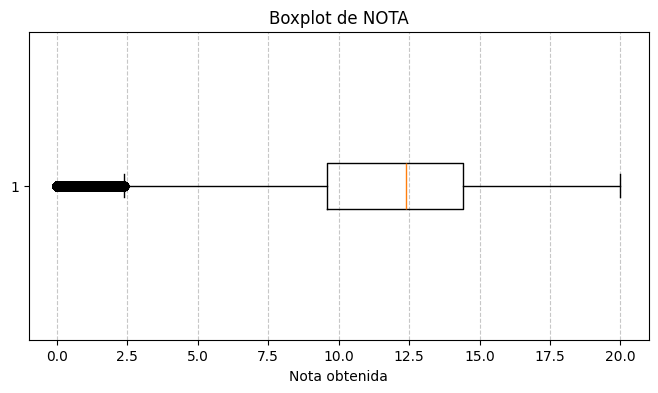

In [151]:
# Descripción de NOTA
print(df_final['NOTA'].describe())


# Valores nulos de NOTA ordenados
print('Cantidad de valores nulos en NOTA:', df_final['NOTA'].isnull().sum())

# boxplot de NOTA
plt.figure(figsize=(8,4))
plt.boxplot(df_final['NOTA'], vert=False)
plt.title('Boxplot de NOTA')
plt.xlabel('Nota obtenida')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### APROBO

In [152]:
# Valores unicos de APROBO
uniq_sems = df_final['APROBO'].unique()
print('Valores unicos en APROBO:', uniq_sems)
print('Cantidad de valores unicos en APROBO:', df_final['APROBO'].nunique())

# Valores nulos de APROBO ordenados
print('Cantidad de valores nulos en APROBO:', df_final['APROBO'].isnull().sum())

Valores unicos en APROBO: ['N' 'S']
Cantidad de valores unicos en APROBO: 2
Cantidad de valores nulos en APROBO: 0


### HRS_INASISTENCIA

Cantidad de COD_ALUMNO con múltiples HRS_INASISTENCIA: 2616
count    64763.000000
mean        10.207603
std         12.513608
min          0.000000
25%          0.000000
50%          6.000000
75%         15.000000
max        104.000000
Name: HRS_INASISTENCIA, dtype: float64
Cantidad de valores nulos en APRHRS_INASISTENCIAOBO: 0


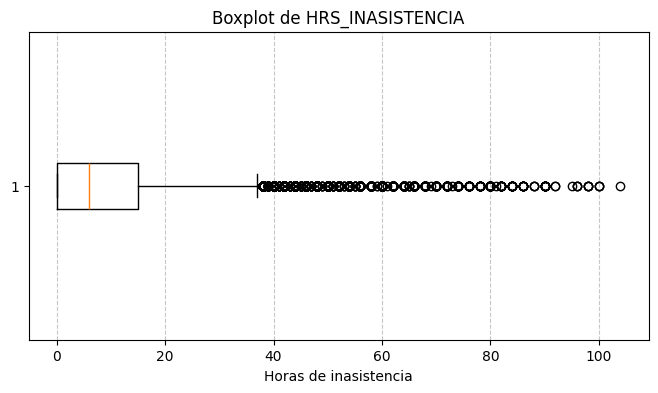

In [153]:
df_personas = df_final[['COD_ALUMNO', 'HRS_INASISTENCIA']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples HRS_INASISTENCIA:", repetidos['COD_ALUMNO'].nunique())

# Descripción de HRS_INASISTENCIA
print(df_final['HRS_INASISTENCIA'].describe())


# Valores nulos de HRS_INASISTENCIA ordenados
print('Cantidad de valores nulos en APRHRS_INASISTENCIAOBO:', df_final['HRS_INASISTENCIA'].isnull().sum())

# boxplot de HRS_INASISTENCIA
plt.figure(figsize=(8,4))
plt.boxplot(df_final['HRS_INASISTENCIA'], vert=False)
plt.title('Boxplot de HRS_INASISTENCIA')
plt.xlabel('Horas de inasistencia')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### HRS_CURSO

Cantidad de COD_ALUMNO con múltiples PRCTJE_INASISTENCIA: 852
count    64763.000000
mean        78.380850
std         25.533615
min          9.000000
25%         51.000000
50%         75.000000
75%        102.000000
max        180.000000
Name: HRS_CURSO, dtype: float64
Cantidad de valores nulos en HRS_CURSO: 0


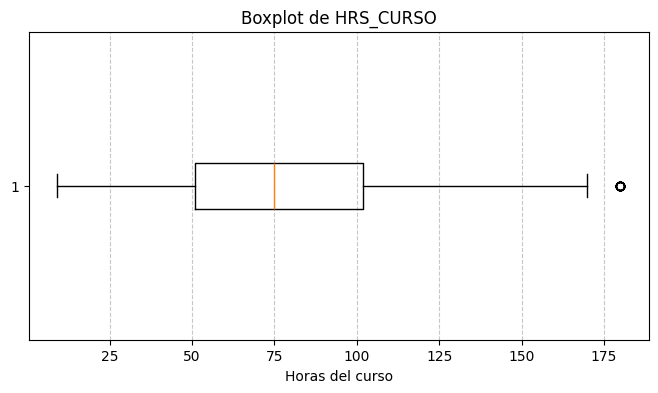

In [154]:
df_personas = df_final[['COD_ALUMNO', 'PRCTJE_INASISTENCIA']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples PRCTJE_INASISTENCIA:", repetidos['COD_ALUMNO'].nunique())

# Descripción de HRS_CURSO
print(df_final['HRS_CURSO'].describe())

# Valores nulos de HRS_CURSO ordenados
print('Cantidad de valores nulos en HRS_CURSO:', df_final['HRS_CURSO'].isnull().sum())

# boxplot de HRS_CURSO
plt.figure(figsize=(8,4))
plt.boxplot(df_final['HRS_CURSO'], vert=False)
plt.title('Boxplot de HRS_CURSO')
plt.xlabel('Horas del curso')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### PRCTJE_INASISTENCIA

count    64763.000000
mean        29.918657
std          1.303249
min          0.000000
25%         30.000000
50%         30.000000
75%         30.000000
max         32.000000
Name: PRCTJE_INASISTENCIA, dtype: float64
Cantidad de valores nulos en PRCTJE_INASISTENCIA: 0


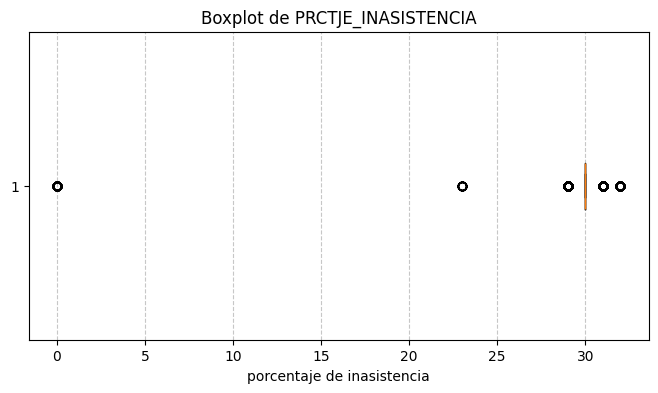

In [155]:
# Descripción de PRCTJE_INASISTENCIA
print(df_final['PRCTJE_INASISTENCIA'].describe())

# Valores nulos de PRCTJE_INASISTENCIA ordenados
print('Cantidad de valores nulos en PRCTJE_INASISTENCIA:', df_final['PRCTJE_INASISTENCIA'].isnull().sum())

# boxplot de PRCTJE_INASISTENCIA
plt.figure(figsize=(8,4))
plt.boxplot(df_final['PRCTJE_INASISTENCIA'], vert=False)
plt.title('Boxplot de PRCTJE_INASISTENCIA')
plt.xlabel('porcentaje de inasistencia')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### PONDERADO

Cantidad de COD_ALUMNO con múltiples PONDERADO: 2115
count    64763.000000
mean        11.241635
std          3.597368
min          0.000000
25%          9.531100
50%         11.910500
75%         13.663300
max         20.000000
Name: PONDERADO, dtype: float64
Cantidad de valores nulos en PONDERADO: 0


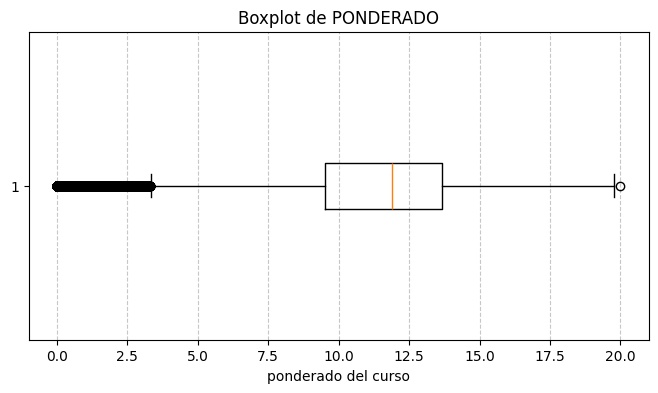

In [156]:
df_personas = df_final[['COD_ALUMNO', 'PONDERADO']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples PONDERADO:", repetidos['COD_ALUMNO'].nunique())

# Descripción de PONDERADO
print(df_final['PONDERADO'].describe())

# Valores nulos de PONDERADO ordenados
print('Cantidad de valores nulos en PONDERADO:', df_final['PONDERADO'].isnull().sum())

# boxplot de PONDERADO
plt.figure(figsize=(8,4))
plt.boxplot(df_final['PONDERADO'], vert=False)
plt.title('Boxplot de PONDERADO')
plt.xlabel('ponderado del curso')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### CRED_GRADUACION

Cantidad de COD_ALUMNO con múltiples CRED_GRADUACION: 0
Valores unicos en CRED_GRADUACION: [217 220 219]
Cantidad de valores unicos en CRED_GRADUACION: 3
Cantidad de valores nulos en CRED_GRADUACION: 0
count    64763.000000
mean       218.848092
std          1.332378
min        217.000000
25%        217.000000
50%        219.000000
75%        220.000000
max        220.000000
Name: CRED_GRADUACION, dtype: float64
Cantidad de valores nulos en CRED_GRADUACION: 0


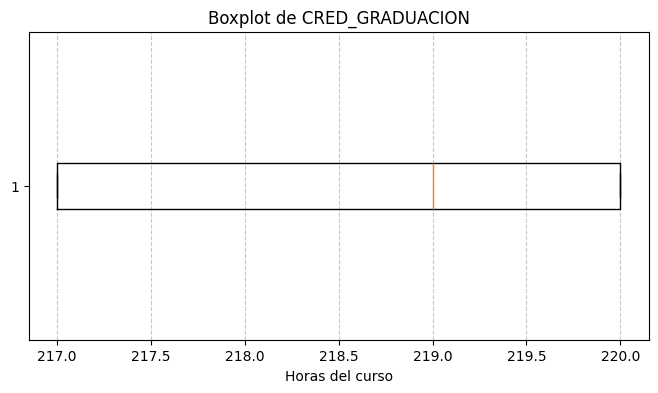

In [157]:
df_personas = df_final[['COD_ALUMNO', 'CRED_GRADUACION']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples CRED_GRADUACION:", repetidos['COD_ALUMNO'].nunique())


# Valores unicos de CRED_GRADUACION
uniq_sems = df_final['CRED_GRADUACION'].unique()
print('Valores unicos en CRED_GRADUACION:', uniq_sems)
print('Cantidad de valores unicos en CRED_GRADUACION:', df_final['CRED_GRADUACION'].nunique())

# Valores nulos de CRED_GRADUACION ordenados
print('Cantidad de valores nulos en CRED_GRADUACION:', df_final['CRED_GRADUACION'].isnull().sum())

# Descripción de CRED_GRADUACION
print(df_final['CRED_GRADUACION'].describe())

# Valores nulos de CRED_GRADUACION ordenados
print('Cantidad de valores nulos en CRED_GRADUACION:', df_final['CRED_GRADUACION'].isnull().sum())

# boxplot de CRED_GRADUACION
plt.figure(figsize=(8,4))
plt.boxplot(df_final['CRED_GRADUACION'], vert=False)
plt.title('Boxplot de CRED_GRADUACION')
plt.xlabel('Horas del curso')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### BECA_VIGENTE

Cantidad de COD_PERSONA con múltiples BECA_VIGENTE: 2
       COD_PERSONA  BECA_VIGENTE
1457          5840             1
16722         5840             0
42335        25949             0
42437        25949             1
Total de personas únicas: 2397
Valores únicos en BECA_VIGENTE: [0 1 2]
Cantidad de valores únicos en BECA_VIGENTE: 3
Cantidad de valores nulos en BECA_VIGENTE: 0


/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_83302/3114972907.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


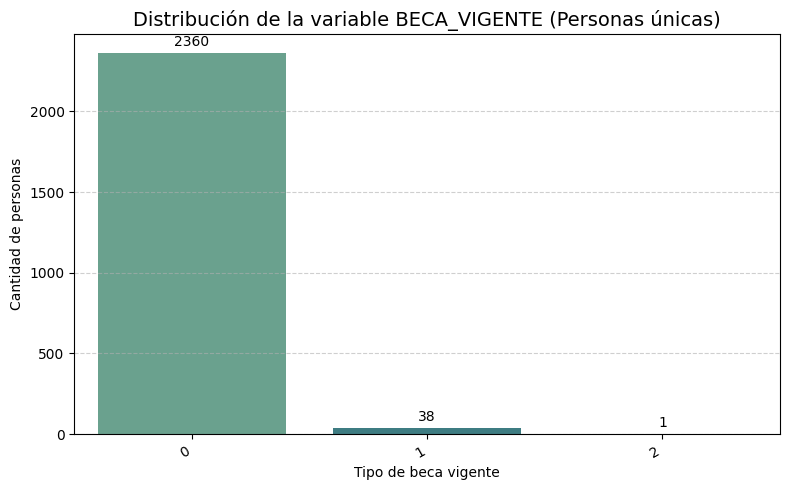

In [158]:
df_personas = df_final[['COD_PERSONA', 'BECA_VIGENTE']].drop_duplicates()

# existen personas con más de un tipo de BECA_VIGENTE?
repetidos = df_personas[df_personas.duplicated(subset=['COD_PERSONA'], keep=False)]
print("Cantidad de COD_PERSONA con múltiples BECA_VIGENTE:", repetidos['COD_PERSONA'].nunique())

print(repetidos)

# --- Análisis de BECA_VIGENTE en personas únicas ---
print('Total de personas únicas:', df_personas['COD_PERSONA'].nunique())
print('Valores únicos en BECA_VIGENTE:', df_personas['BECA_VIGENTE'].unique())
print('Cantidad de valores únicos en BECA_VIGENTE:', df_personas['BECA_VIGENTE'].nunique())
print('Cantidad de valores nulos en BECA_VIGENTE:', df_personas['BECA_VIGENTE'].isnull().sum())

# --- Gráfico ---
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df_personas,
    x='BECA_VIGENTE',
    order=df_personas['BECA_VIGENTE'].value_counts().index,
    palette='crest'
)

# Títulos y etiquetas
plt.title('Distribución de la variable BECA_VIGENTE (Personas únicas)', fontsize=14)
plt.xlabel('Tipo de beca vigente')
plt.ylabel('Cantidad de personas')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Etiquetas sobre las barras
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        f'{count}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, color='black',
        xytext=(0, 3), textcoords='offset points'
    )

plt.tight_layout()
plt.show()


In [159]:
# eliminar en df_final la columna BECA_VIGENTE == 2
df_final = df_final[df_final['BECA_VIGENTE'] != 2]
df_final['BECA_VIGENTE'].describe()

# eliminar en df_final la columna DOC_PERSONA == 25949 y 5840
df_final = df_final[~df_final['COD_PERSONA'].isin([25949, 5840])]
print("Dimensiones finales de df_final después de eliminar BECA_VIGENTE == 2 y COD_PERSONA específicos:", df_final.shape)



df_personas = df_final[['COD_ALUMNO', 'BECA_VIGENTE']].drop_duplicates()
repetidos = df_personas[df_personas.duplicated(subset=['COD_ALUMNO'], keep=False)]
print("Cantidad de COD_ALUMNO con múltiples BECA_VIGENTE:", repetidos['COD_ALUMNO'].nunique())


Dimensiones finales de df_final después de eliminar BECA_VIGENTE == 2 y COD_PERSONA específicos: (64596, 32)
Cantidad de COD_ALUMNO con múltiples BECA_VIGENTE: 0


### NOTA_ENCUESTA_DOC

Valores unicos en NOTA_ENCUESTA_DOC: [0]
Cantidad de valores unicos en NOTA_ENCUESTA_DOC: 1
Cantidad de valores nulos en NOTA_ENCUESTA_DOC: 0
count    64596.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: NOTA_ENCUESTA_DOC, dtype: float64
Cantidad de valores nulos en NOTA_ENCUESTA_DOC: 0


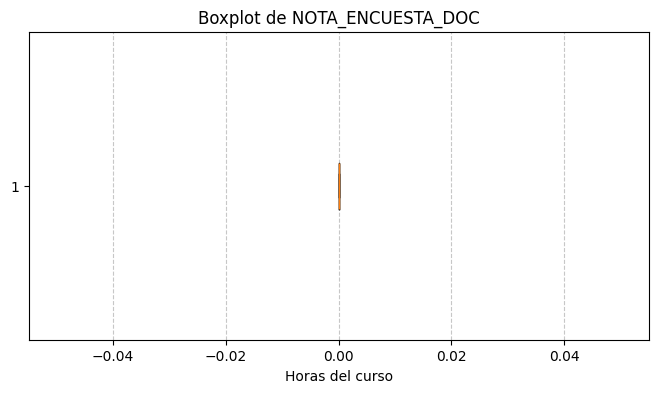

In [160]:
# Valores unicos de NOTA_ENCUESTA_DOC
uniq_sems = df_final['NOTA_ENCUESTA_DOC'].unique()
print('Valores unicos en NOTA_ENCUESTA_DOC:', uniq_sems)
print('Cantidad de valores unicos en NOTA_ENCUESTA_DOC:', df_final['NOTA_ENCUESTA_DOC'].nunique())

# Valores nulos de NOTA_ENCUESTA_DOC ordenados
print('Cantidad de valores nulos en NOTA_ENCUESTA_DOC:', df_final['NOTA_ENCUESTA_DOC'].isnull().sum())

# Descripción de NOTA_ENCUESTA_DOC
print(df_final['NOTA_ENCUESTA_DOC'].describe())

# Valores nulos de NOTA_ENCUESTA_DOC ordenados
print('Cantidad de valores nulos en NOTA_ENCUESTA_DOC:', df_final['NOTA_ENCUESTA_DOC'].isnull().sum())

# boxplot de NOTA_ENCUESTA_DOC
plt.figure(figsize=(8,4))
plt.boxplot(df_final['NOTA_ENCUESTA_DOC'], vert=False)
plt.title('Boxplot de NOTA_ENCUESTA_DOC')
plt.xlabel('Horas del curso')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [161]:
# eliminar columna NOTA_ENCUESTA_DOC
df_final = df_final.drop(columns=['NOTA_ENCUESTA_DOC'], errors='ignore')

### NOTA_ENCUESTA_DOC_GRUPO


Valores unicos en NOTA_ENCUESTA_DOC_GRUPO: [       nan 17.066035  17.126036  ... 16.1414332 16.3550742 14.7411226]
Cantidad de valores unicos en NOTA_ENCUESTA_DOC_GRUPO: 1559
Cantidad de valores nulos en NOTA_ENCUESTA_DOC_GRUPO: 52245
Porcentaje de valores nulos en NOTA_ENCUESTA_DOC_GRUPO: 80.87962102916589
count    12351.000000
mean        16.165423
std          1.815885
min          4.227744
25%         15.124366
50%         16.421325
75%         17.447504
max         19.999260
Name: NOTA_ENCUESTA_DOC_GRUPO, dtype: float64
Cantidad de valores nulos en NOTA_ENCUESTA_DOC_GRUPO: 52245


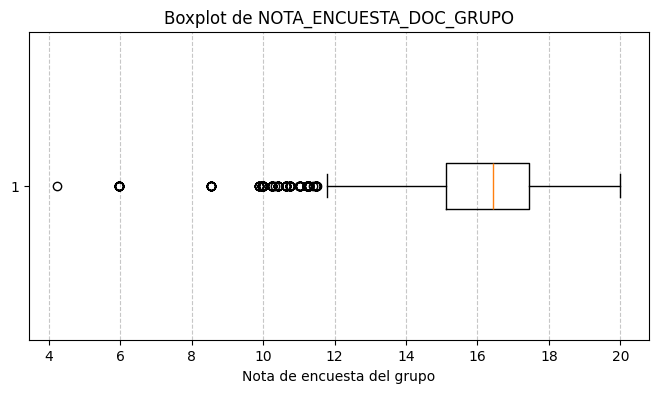

In [162]:
# Valores unicos de NOTA_ENCUESTA_DOC_GRUPO
uniq_sems = df_final['NOTA_ENCUESTA_DOC_GRUPO'].unique()
print('Valores unicos en NOTA_ENCUESTA_DOC_GRUPO:', uniq_sems)
print('Cantidad de valores unicos en NOTA_ENCUESTA_DOC_GRUPO:', df_final['NOTA_ENCUESTA_DOC_GRUPO'].nunique())

# Valores nulos de NOTA_ENCUESTA_DOC_GRUPO ordenados
print('Cantidad de valores nulos en NOTA_ENCUESTA_DOC_GRUPO:', df_final['NOTA_ENCUESTA_DOC_GRUPO'].isnull().sum())
print('Porcentaje de valores nulos en NOTA_ENCUESTA_DOC_GRUPO:', 
      (df_final['NOTA_ENCUESTA_DOC_GRUPO'].isnull().sum() / len(df_final)) * 100)

# Descripción de NOTA_ENCUESTA_DOC_GRUPO
print(df_final['NOTA_ENCUESTA_DOC_GRUPO'].describe())

# Valores nulos de NOTA_ENCUESTA_DOC_GRUPO ordenados
print('Cantidad de valores nulos en NOTA_ENCUESTA_DOC_GRUPO:', df_final['NOTA_ENCUESTA_DOC_GRUPO'].isnull().sum())

# boxplot de    NOTA_ENCUESTA_DOC_GRUPO
plt.figure(figsize=(8,4))
plt.boxplot(df_final['NOTA_ENCUESTA_DOC_GRUPO'].dropna(), vert=False)
plt.title('Boxplot de NOTA_ENCUESTA_DOC_GRUPO')
plt.xlabel('Nota de encuesta del grupo')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [163]:
# eliminar columna de NOTA_ENCUESTA_DOC_GRUPO
df_final = df_final.drop(columns=['NOTA_ENCUESTA_DOC_GRUPO'], errors='ignore')

### Data Resultante de la limpieza personalizada

In [164]:
cant_registros = df_final.shape[0]
cant_columnas = df_final.shape[1]
print(f"Dimensiones finales de df_final: {cant_registros} registros y {cant_columnas} columnas.")

Dimensiones finales de df_final: 64596 registros y 30 columnas.


# Preprocesamiento y Feature Engineering (PFE)

## Equivalencia de mallas

Usaremos la malla de 2016 para poder aumentar los features que describan propiamente a los cursos. Sin embargo ello limita sustancialmente la data optenida por lo que tambien realizaremos una convalidacion de la malla 2011 a 2016, para poder salvaguardar la data de los COD_PLAN.  56 y 79.

Valores unicos en COD_PLAN : 3, 51, 56 y 79 

- Malla 2016 -> 79
- Malla 2011 -> 56


In [165]:
# valores unicos de COD_PLAN
uniq_sems = df_final['COD_PLAN'].unique()
print('Valores unicos en COD_PLAN:', uniq_sems)
# eliminar todo cod_plan diferente a 79 y 56
df_final = df_final[(df_final['COD_PLAN'] == 79) | (df_final['COD_PLAN'] == 56)]
uniq_sems = df_final['COD_PLAN'].unique()
print('Valores unicos en COD_PLAN:', uniq_sems)

Valores unicos en COD_PLAN: [ 3 51 56 79]
Valores unicos en COD_PLAN: [56 79]


In [166]:
def normalizar_curso(texto):
    """
    Convierte a mayúsculas y elimina tildes/acentos.
    """
    if not isinstance(texto, str):
        return texto
    
    # 1. Poner en mayúsculas
    texto = texto.upper()
    
    # 2. Quitar tildes (normalizando a NFKD)
    nfkd_form = unicodedata.normalize('NFKD', texto)
    texto_sin_tildes = "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    
    return texto_sin_tildes

def convertir_prereq_a_lista(prereq_val):
    """
    Convierte un string de prerequisitos (separado por comas) en una lista.
    También normaliza los nombres de los cursos en la lista.
    """
    if pd.isna(prereq_val) or prereq_val is None:
        return []  # Retorna lista vacía si es None o NaN
    
    # Divide por la coma y quita espacios en blanco de cada elemento
    # Y aplica la misma normalización de mayúsculas/sin tildes
    lista_prereq = [normalizar_curso(item.strip()) for item in prereq_val.split(',')]
    return lista_prereq


### Malla 2011

In [ ]:
malla_2011 = [
    # Semestre I
    {'Semestre': 'I', 'Codigo': 'CB101', 'Curso': 'Álgebra y Geometría', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 5, 'Prerequisito': np.nan},
    {'Semestre': 'I', 'Codigo': 'FG101', 'Curso': 'Comunicación', 'Tipo': 'O', 'Total_Horas': 4, 'Creditos': 3, 'Prerequisito': np.nan},
    {'Semestre': 'I', 'Codigo': 'CS1D01', 'Curso': 'Estructuras Discretas I', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': np.nan},
    {'Semestre': 'I', 'Codigo': 'CS1I01F', 'Curso': 'Introducción a la Programación', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': np.nan},
    {'Semestre': 'I', 'Codigo': 'FG103', 'Curso': 'Introducción a la Vida Universitaria', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 3, 'Prerequisito': np.nan},
    {'Semestre': 'I', 'Codigo': 'FG102', 'Curso': 'Metodología del Círculo', 'Tipo': 'O', 'Total_Horas': 4, 'Creditos': 3, 'Prerequisito': np.nan},
    
    # Semestre II
    {'Semestre': 'II', 'Codigo': 'CB102', 'Curso': 'Análisis Matemático I', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 5, 'Prerequisito': 'Álgebra y Geometría'},
    {'Semestre': 'II', 'Codigo': 'FG105', 'Curso': 'Apreciación de la Música', 'Tipo': 'EH', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': np.nan},
    {'Semestre': 'II', 'Codigo': 'CS1D02', 'Curso': 'Estructuras Discretas II', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Introducción a la Programación, Estructuras Discretas I'},
    {'Semestre': 'II', 'Codigo': 'CS1I00', 'Curso': 'Introducción a la Ciencia de la Computación', 'Tipo': 'O', 'Total_Horas': 4, 'Creditos': 3, 'Prerequisito': np.nan},
    {'Semestre': 'II', 'Codigo': 'FG104', 'Curso': 'Introducción a la Filosofía', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 3, 'Prerequisito': np.nan},
    {'Semestre': 'II', 'Codigo': 'CS1O10', 'Curso': 'Introducción a la Programación Orientada a Objetos', 'Tipo': 'O', 'Total_Horas': 8, 'Creditos': 5, 'Prerequisito': 'Introducción a la Programación'},
    {'Semestre': 'II', 'Codigo': 'FG112', 'Curso': 'Matrimonio y Familia', 'Tipo': 'EH', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': np.nan},
    {'Semestre': 'II', 'Codigo': 'FG106', 'Curso': 'Teatro', 'Tipo': 'EH', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': np.nan},
    
    # Semestre III
    {'Semestre': 'III', 'Codigo': 'CB103', 'Curso': 'Análisis Matemático II', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 5, 'Prerequisito': 'Análisis Matemático I'},
    {'Semestre': 'III', 'Codigo': 'FG202', 'Curso': 'Apreciación Literaria', 'Tipo': 'EH', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': np.nan},
    {'Semestre': 'III', 'Codigo': 'CS220T', 'Curso': 'Arquitectura de Computadores', 'Tipo': 'O', 'Total_Horas': 4, 'Creditos': 3, 'Prerequisito': 'Estructuras Discretas II'},
    {'Semestre': 'III', 'Codigo': 'FG201', 'Curso': 'Artes Plásticas', 'Tipo': 'EH', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': np.nan},
    {'Semestre': 'III', 'Codigo': 'CS1D7', 'Curso': 'Estructuras Discretas III', 'Tipo': 'O', 'Total_Horas': 4, 'Creditos': 3, 'Prerequisito': 'Estructuras Discretas I, Introducción a la Programación Orientada a Objetos'},
    {'Semestre': 'III', 'Codigo': 'FG107', 'Curso': 'Fundamentos Antropológicos de la Ciencia', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 3, 'Prerequisito': 'Introducción a la Filosofía'},
    {'Semestre': 'III', 'Codigo': 'CS1I30', 'Curso': 'Introducción a Internet', 'Tipo': 'O', 'Total_Horas': 4, 'Creditos': 3, 'Prerequisito': 'Introducción a la Ciencia de la Computación, Introducción a la Programación Orientada a Objetos'},
    {'Semestre': 'III', 'Codigo': 'CS1O20', 'Curso': 'Objetos y Abstracción de Datos', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Introducción a la Programación Orientada a Objetos'},
    {'Semestre': 'III', 'Codigo': 'FG203', 'Curso': 'ORATORIA Y EXPRESION PERSONAL', 'Tipo': 'EH', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': np.nan},
    
    # Semestre IV
    {'Semestre': 'IV', 'Codigo': 'CS1D30', 'Curso': 'Algoritmos y Estructuras de Datos', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Objetos y Abstracción de Datos'},
    {'Semestre': 'IV', 'Codigo': 'CB201', 'Curso': 'Análisis Matemático III', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 5, 'Prerequisito': 'Análisis Matemático II'},
    {'Semestre': 'IV', 'Codigo': 'CS270T', 'Curso': 'Bases de Datos I', 'Tipo': 'O', 'Total_Horas': 8, 'Creditos': 5, 'Prerequisito': 'Estructuras Discretas III'},
    {'Semestre': 'IV', 'Codigo': 'CB203', 'Curso': 'Estadística y Probabilidades', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Análisis Matemático II'},
    {'Semestre': 'IV', 'Codigo': 'CS211T', 'Curso': 'Teoría de la Computación', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Estructuras Discretas II'},
    
    # Semestre V
    {'Semestre': 'V', 'Codigo': 'CB306', 'Curso': 'Análisis Numérico', 'Tipo': 'O', 'Total_Horas': 5, 'Creditos': 3, 'Prerequisito': 'Análisis Matemático III'},
    {'Semestre': 'V', 'Codigo': 'CS210T', 'Curso': 'Análisis y Diseño de Algoritmos', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Algoritmos y Estructuras de Datos, Estadística y Probabilidades'},
    {'Semestre': 'V', 'Codigo': 'CS272T', 'Curso': 'Base de Datos II', 'Tipo': 'O', 'Total_Horas': 5, 'Creditos': 3, 'Prerequisito': 'Bases de Datos I, Ranking de Inglés 300 puntos'},
    {'Semestre': 'V', 'Codigo': 'FG210', 'Curso': 'Ética', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 3, 'Prerequisito': 'Fundamentos Antropológicos de la Ciencia'},
    {'Semestre': 'V', 'Codigo': 'CB111', 'Curso': 'Física Computacional', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Análisis Matemático II'},
    {'Semestre': 'V', 'Codigo': 'CS290T', 'Curso': 'Ingeniería de Software I', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Bases de Datos I, Introducción a Internet, Objetos y Abstracción de Datos'},
    {'Semestre': 'V', 'Codigo': 'FG209', 'Curso': 'Psicología', 'Tipo': 'EH', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': np.nan},
    {'Semestre': 'V', 'Codigo': 'FG206', 'Curso': 'Sociología', 'Tipo': 'EH', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': np.nan},
    
    # Semestre VI
    {'Semestre': 'VI', 'Codigo': 'CS315', 'Curso': 'Estructuras de Datos Avanzadas', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Análisis y Diseño de Algoritmos'},
    {'Semestre': 'VI', 'Codigo': 'CS390', 'Curso': 'Ingeniería de Software II', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Ingeniería de Software I'},
    {'Semestre': 'VI', 'Codigo': 'CS281', 'Curso': 'Lógica Computacional', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Teoría de la Computación'},
    {'Semestre': 'VI', 'Codigo': 'CB207', 'Curso': 'Matemática Aplicada a la Computación', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Física Computacional'},
    {'Semestre': 'VI', 'Codigo': 'CS225T', 'Curso': 'Sistemas Operativos', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Arquitectura de Computadores'},
    {'Semestre': 'VI', 'Codigo': 'FG204', 'Curso': 'Teología I', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 3, 'Prerequisito': 'Fundamentos Antropológicos de la Ciencia'},
    
    # Semestre VII
    {'Semestre': 'VII', 'Codigo': 'CS314', 'Curso': 'Algoritmos Paralelos', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Análisis y Diseño de Algoritmos, Sistemas Operativos'},
    {'Semestre': 'VII', 'Codigo': 'CS261T', 'Curso': 'Inteligencia Artificial', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Estadística y Probabilidades, Lógica Computacional'},
    {'Semestre': 'VII', 'Codigo': 'CS2S0W', 'Curso': 'Interacción Humano Computador', 'Tipo': 'O', 'Total_Horas': 10, 'Creditos': 3, 'Prerequisito': 'Ingeniería de Software I, Ranking de Inglés 400 puntos'},
    {'Semestre': 'VII', 'Codigo': 'CS343', 'Curso': 'Lenguajes de Programación', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Teoría de la Computación, Análisis y Diseño de Algoritmos'},
    {'Semestre': 'VII', 'Codigo': 'CS401', 'Curso': 'Proyecto I', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': 'Ingeniería de Software I'},
    {'Semestre': 'VII', 'Codigo': 'CS336', 'Curso': 'Seguridad en Computación', 'Tipo': 'O', 'Total_Horas': 5, 'Creditos': 3, 'Prerequisito': 'Algoritmos y Estructuras de Datos'},
    {'Semestre': 'VII', 'Codigo': 'FG204A', 'Curso': 'Teología II', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 3, 'Prerequisito': 'Ética, Teología I'},
    
    # Semestre VIII
    {'Semestre': 'VIII', 'Codigo': 'CS280T', 'Curso': 'Aspectos Sociales y Profesionales de la Computación', 'Tipo': 'O', 'Total_Horas': 2, 'Creditos': 2, 'Prerequisito': 'Proyecto I'},
    {'Semestre': 'VIII', 'Codigo': 'CS392', 'Curso': 'Calidad de Software', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Ingeniería de Software II'},
    {'Semestre': 'VIII', 'Codigo': 'CS340S', 'Curso': 'Compiladores', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Lenguajes de Programación'},
    {'Semestre': 'VIII', 'Codigo': 'CS2SOW', 'Curso': 'Computación Centrada en Redes', 'Tipo': 'O', 'Total_Horas': 5, 'Creditos': 3, 'Prerequisito': 'Sistemas Operativos, Seguridad en Computación'},
    {'Semestre': 'VIII', 'Codigo': 'CS255', 'Curso': 'Computación Gráfica', 'Tipo': 'O', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Análisis Numérico, Estructuras de Datos Avanzadas, Matemática Aplicada a la Computación'},
    {'Semestre': 'VIII', 'Codigo': 'FG205', 'Curso': 'Historia de la Cultura', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 3, 'Prerequisito': np.nan},
    {'Semestre': 'VIII', 'Codigo': 'CS402', 'Curso': 'Proyecto II', 'Tipo': 'O', 'Total_Horas': 4, 'Creditos': 3, 'Prerequisito': 'Proyecto I'},
    
    # Semestre IX
    {'Semestre': 'IX', 'Codigo': 'CS360', 'Curso': 'Computación Bioinspirada', 'Tipo': 'EG', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Inteligencia Artificial'},
    {'Semestre': 'IX', 'Codigo': 'CB309', 'Curso': 'Computación Molecular Biológica', 'Tipo': 'EG', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Estructuras de Datos Avanzadas'},
    {'Semestre': 'IX', 'Codigo': 'FG301', 'Curso': 'Enseñanza Social de la Iglesia', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 3, 'Prerequisito': 'Teología II'},
    {'Semestre': 'IX', 'Codigo': 'EI101', 'Curso': 'Formación de Empresas de Base Tecnológica I', 'Tipo': 'O', 'Total_Horas': 4, 'Creditos': 3, 'Prerequisito': 'Proyecto I'},
    {'Semestre': 'IX', 'Codigo': 'FG221', 'Curso': 'Historia de la Ciencia y Tecnología', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': 'Historia de la Cultura'},
    {'Semestre': 'IX', 'Codigo': 'CS393', 'Curso': 'Métodos Formales', 'Tipo': 'EG', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Lógica Computacional'},
    {'Semestre': 'IX', 'Codigo': 'CS400', 'Curso': 'Proyecto de Tesis', 'Tipo': 'O', 'Total_Horas': 4, 'Creditos': 3, 'Prerequisito': 'Proyecto II'},
    {'Semestre': 'IX', 'Codigo': 'CS370', 'Curso': 'Tópicos en Bases de Datos', 'Tipo': 'EG', 'Total_Horas': 5, 'Creditos': 3, 'Prerequisito': 'Base de Datos II'},
    {'Semestre': 'IX', 'Codigo': 'CS355', 'Curso': 'Tópicos en Computación Gráfica', 'Tipo': 'EG', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Computación Gráfica'},
    {'Semestre': 'IX', 'Codigo': 'CS361', 'Curso': 'Tópicos en Inteligencia Artificial', 'Tipo': 'EG', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Inteligencia Artificial'},
    
    # Semestre X
    {'Semestre': 'X', 'Codigo': 'FG220', 'Curso': 'Análisis de la Realidad Peruana', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': 'Historia de la Ciencia y Tecnología'},
    {'Semestre': 'X', 'Codigo': 'CS331', 'Curso': 'Cloud Computing', 'Tipo': 'O', 'Total_Horas': 5, 'Creditos': 3, 'Prerequisito': 'Algoritmos Paralelos, Computación Centrada en Redes'},
    {'Semestre': 'X', 'Codigo': 'FG211', 'Curso': 'Ética Profesional', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': 'Teología II'},
    {'Semestre': 'X', 'Codigo': 'EI102', 'Curso': 'Formación de Empresas de Base Tecnológica II', 'Tipo': 'O', 'Total_Horas': 4, 'Creditos': 3, 'Prerequisito': 'Formación de Empresas de Base Tecnológica I'},
    {'Semestre': 'X', 'Codigo': 'FG230', 'Curso': 'Liderazgo y Desempeño', 'Tipo': 'O', 'Total_Horas': 3, 'Creditos': 2, 'Prerequisito': np.nan},
    {'Semestre': 'X', 'Codigo': 'CS232W', 'Curso': 'Programación de Dispositivos Móviles', 'Tipo': 'O', 'Total_Horas': 5, 'Creditos': 3, 'Prerequisito': 'Computación Centrada en Redes'},
    {'Semestre': 'X', 'Codigo': 'CS356', 'Curso': 'Programación de Video Juegos', 'Tipo': 'EG', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Inteligencia Artificial, Tópicos en Computación Gráfica, Interacción Humano Computador'},
    {'Semestre': 'X', 'Codigo': 'CS367', 'Curso': 'Robótica', 'Tipo': 'EG', 'Total_Horas': 6, 'Creditos': 4, 'Prerequisito': 'Tópicos en Inteligencia Artificial'},
    {'Semestre': 'X', 'Codigo': 'CS404', 'Curso': 'Seminario de Tesis', 'Tipo': 'O', 'Total_Horas': 4, 'Creditos': 3, 'Prerequisito': 'Aspectos Sociales y Profesionales de la Computación, Proyecto de Tesis'}
]

# Crear el DataFrame
df_malla_curricular_2011 = pd.DataFrame(malla_2011)

# renombrar columnas por sus mayusculas
df_malla_curricular_2011.rename(columns={
    'Codigo': 'CODIGO',
    'Curso': 'CURSO',
    'Tipo': 'TIPO',
    'Total_Horas': 'TOTAL_HORAS',
    'Creditos': 'CREDITOS',
    'Prerequisito': 'PREREQUISITO'
}, inplace=True)

# --- 3. Aplicación de las reglas de formato ---
# Aplicar normalización a la columna CURSO
df_malla_curricular_2011['CURSO'] = df_malla_curricular_2011['CURSO'].apply(normalizar_curso)
# Aplicar conversión a lista en la columna PREREQUISITO
df_malla_curricular_2011['PREREQUISITO'] = df_malla_curricular_2011['PREREQUISITO'].apply(convertir_prereq_a_lista)


# --- 4. Verificación del Resultado ---
print("DataFrame creado con cursos de la malla 2011:")
print(df_malla_curricular_2011.info())
print(df_malla_curricular_2011.head(10))

DataFrame creado con cursos de la malla 2011:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Semestre      75 non-null     object
 1   CODIGO        75 non-null     object
 2   CURSO         75 non-null     object
 3   TIPO          75 non-null     object
 4   TOTAL_HORAS   75 non-null     int64 
 5   CREDITOS      75 non-null     int64 
 6   PREREQUISITO  75 non-null     object
dtypes: int64(2), object(5)
memory usage: 4.2+ KB
None
  Semestre   CODIGO                                        CURSO TIPO  \
0        I    CB101                          ALGEBRA Y GEOMETRIA    O   
1        I    FG101                                 COMUNICACION    O   
2        I   CS1D01                      ESTRUCTURAS DISCRETAS I    O   
3        I  CS1I01F               INTRODUCCION A LA PROGRAMACION    O   
4        I    FG103         INTRODUCCION A LA VIDA UNI

In [168]:
# verificar valores unicos de PER_INGRESO ordenadas
uniq_sems = df_final['PER_INGRESO'].unique()
uniq_sems.sort()
print('Valores unicos en PER_INGRESO despues de la limpieza:', uniq_sems)

Valores unicos en PER_INGRESO despues de la limpieza: ['2011-01' '2011-02' '2012-01' '2012-02' '2013-01' '2013-02' '2014-01'
 '2014-02' '2015-01' '2015-02' '2016-01' '2016-02' '2017-01' '2017-02'
 '2018-01' '2018-02' '2019-01' '2019-02' '2020-01' '2020-02']


In [169]:
# valores unicos de per_matricula
uniq_sems = df_final['PER_MATRICULA'].unique()
uniq_sems.sort()
print('Valores unicos en PER_MATRICULA despues de la limpieza:', uniq_sems)

Valores unicos en PER_MATRICULA despues de la limpieza: ['2011-00' '2011-00B' '2011-01' '2011-02' '2012-00' '2012-00B' '2012-01'
 '2012-02' '2013-00' '2013-00B' '2013-01' '2013-02' '2014-00' '2014-00B'
 '2014-01' '2014-02' '2014-03' '2014-03B' '2015-01' '2015-02' '2015-03B'
 '2015-R' '2016-01' '2016-02' '2016-R' '2017-00B' '2017-01' '2017-02'
 '2017-R' '2018-00B' '2018-01' '2018-02' '2018-R' '2019-01' '2019-02'
 '2019-R' '2020-01' '2020-02' '2020-R']


In [170]:
# eliminar registros con PER_MATRICULA  '2015-R' , '2011-00 , '2011-00B'
df_final = df_final[df_final['PER_MATRICULA'] != '2015-R']
df_final = df_final[df_final['PER_MATRICULA'] != '2011-00']
df_final = df_final[df_final['PER_MATRICULA'] != '2011-00B']
# verificar valores unicos de PER_MATRICULA ordenadas
uniq_sems = df_final['PER_MATRICULA'].unique()
uniq_sems.sort()
print('Valores unicos en PER_MATRICULA despues de la limpieza:', uniq_sems)


# cambiar los per_matricula 2014-03 a 2015-00
df_final['PER_MATRICULA'] = df_final['PER_MATRICULA'].replace({'2014-03': '2015-00'})

Valores unicos en PER_MATRICULA despues de la limpieza: ['2011-01' '2011-02' '2012-00' '2012-00B' '2012-01' '2012-02' '2013-00'
 '2013-00B' '2013-01' '2013-02' '2014-00' '2014-00B' '2014-01' '2014-02'
 '2014-03' '2014-03B' '2015-01' '2015-02' '2015-03B' '2016-01' '2016-02'
 '2016-R' '2017-00B' '2017-01' '2017-02' '2017-R' '2018-00B' '2018-01'
 '2018-02' '2018-R' '2019-01' '2019-02' '2019-R' '2020-01' '2020-02'
 '2020-R']


In [171]:
# cambiar valores de PER_MATRICULA de 'XXXX-R' a '(XXXX+1)-00'
df_final['PER_MATRICULA'] = df_final['PER_MATRICULA'].apply(
    lambda x: f"{int(x.split('-')[0]) + 1}-00" if isinstance(x, str) and x.endswith('-R') else x
)
# verificar valores unicos de PER_MATRICULA ordenadas
uniq_sems = df_final['PER_MATRICULA'].unique()
uniq_sems.sort()
print('Valores unicos en PER_MATRICULA despues de la limpieza:', uniq_sems)


# extraer tipo de ciclo de PER_MATRICULA y crear nueva columna TIPO_CICLO
# Si el sufijo es '01' o '02' es Regular, si es '00' es Verano
# Si es otro valor, asignar 'Cero'

def determinar_tipo_ciclo(per_matricula):
    if isinstance(per_matricula, str):
        sufijo = per_matricula.split('-')[1]
        if sufijo in ['01', '02']:
            return 'Regular'
        elif sufijo == '00':
            return 'Verano'
    return 'Cero'

df_final['TIPO_CICLO'] = df_final['PER_MATRICULA'].apply(determinar_tipo_ciclo)


# verificar valores unicos de TIPO_CICLO
uniq_sems = df_final['TIPO_CICLO'].unique()
print('Valores unicos en TIPO_CICLO despues de la limpieza:', uniq_sems
)

Valores unicos en PER_MATRICULA despues de la limpieza: ['2011-01' '2011-02' '2012-00' '2012-00B' '2012-01' '2012-02' '2013-00'
 '2013-00B' '2013-01' '2013-02' '2014-00' '2014-00B' '2014-01' '2014-02'
 '2014-03B' '2015-00' '2015-01' '2015-02' '2015-03B' '2016-01' '2016-02'
 '2017-00' '2017-00B' '2017-01' '2017-02' '2018-00' '2018-00B' '2018-01'
 '2018-02' '2019-00' '2019-01' '2019-02' '2020-00' '2020-01' '2020-02'
 '2021-00']
Valores unicos en TIPO_CICLO despues de la limpieza: ['Regular' 'Verano' 'Cero']


In [172]:
# Eliminar todo registro con TIPO_CICLO igual a 'Cero'
df_final = df_final[df_final['TIPO_CICLO'] != 'Cero']

# verificar valores unicos de TIPO_CICLO
uniq_sems = df_final['TIPO_CICLO'].unique()
print('Valores unicos en TIPO_CICLO despues de eliminar Cero:', uniq_sems)

# verificar valores unicos de PER_MATRICULA ordenadas
uniq_sems = df_final['PER_MATRICULA'].unique()
uniq_sems.sort()
print('Valores unicos en PER_MATRICULA despues de la limpieza:', uniq_sems)

# valores unicos de PER_INGRESO
uniq_sems = df_final['PER_INGRESO'].unique()
uniq_sems.sort()
print('Valores unicos en PER_INGRESO despues de la limpieza:', uniq_sems)

Valores unicos en TIPO_CICLO despues de eliminar Cero: ['Regular' 'Verano']
Valores unicos en PER_MATRICULA despues de la limpieza: ['2011-01' '2011-02' '2012-00' '2012-01' '2012-02' '2013-00' '2013-01'
 '2013-02' '2014-00' '2014-01' '2014-02' '2015-00' '2015-01' '2015-02'
 '2016-01' '2016-02' '2017-00' '2017-01' '2017-02' '2018-00' '2018-01'
 '2018-02' '2019-00' '2019-01' '2019-02' '2020-00' '2020-01' '2020-02'
 '2021-00']
Valores unicos en PER_INGRESO despues de la limpieza: ['2011-01' '2011-02' '2012-01' '2012-02' '2013-01' '2013-02' '2014-01'
 '2014-02' '2015-01' '2015-02' '2016-01' '2016-02' '2017-01' '2017-02'
 '2018-01' '2018-02' '2019-01' '2019-02' '2020-01' '2020-02']


### Limitar a malla 2016

In [173]:
# # valores unicos de COD_PLAN
# uniq_sems = df_final['COD_PLAN'].unique()
# print('Valores unicos en COD_PLAN:', uniq_sems)
# # eliminar todo cod_plan diferente a 79
# df_final = df_final[df_final['COD_PLAN'] == 79]
# uniq_sems = df_final['COD_PLAN'].unique()
# print('Valores unicos en COD_PLAN:', uniq_sems)

In [174]:
# # # eliminar todo con periodo de ingreso menor a 2016-1
# # df_final = df_final[~df_final['PER_INGRESO'].isin(['1999-01', '1999-02', '2000-01', '2000-02', '2001-01', '2001-02', '2002-01',
# #  '2002-02', '2003-01', '2003-02', '2004-01', '2004-02', '2005-01', '2005-02',
# #  '2006-01', '2006-02', '2007-01', '2007-02', '2008-01', '2008-02', '2009-01',
# #  '2009-02', '2010-01', '2010-02', '2011-01', '2011-02', '2012-01', '2012-02',
# #  '2013-01', '2013-02', '2014-01', '2014-02', '2015-01', '2015-02'])]

# # verificar valores unicos de PER_INGRESO ordenadas
# uniq_sems = df_final['PER_INGRESO'].unique()
# uniq_sems.sort()
# print('Valores unicos en PER_INGRESO despues de la limpieza:', uniq_sems)

In [175]:
# # valores unicos de per_matricula
# uniq_sems = df_final['PER_MATRICULA'].unique()
# uniq_sems.sort()
# print('Valores unicos en PER_MATRICULA despues de la limpieza:', uniq_sems)

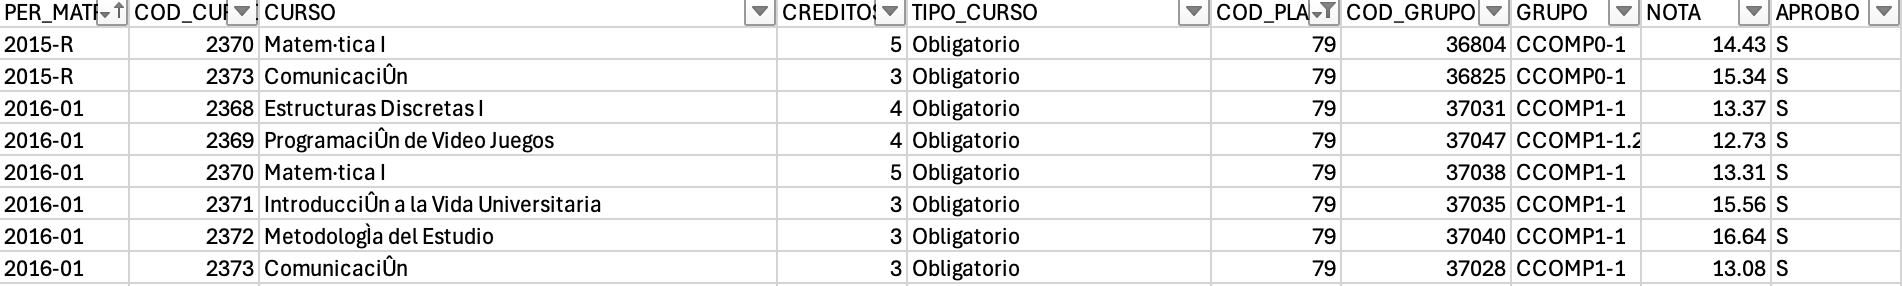

In [176]:
# # eliminar registros con PER_MATRICULA  '2015-R' 
# df_final = df_final[df_final['PER_MATRICULA'] != '2015-R']
# # verificar valores unicos de PER_MATRICULA ordenadas
# uniq_sems = df_final['PER_MATRICULA'].unique()
# uniq_sems.sort()
# print('Valores unicos en PER_MATRICULA despues de la limpieza:', uniq_sems)

In [177]:
# # cambiar valores de PER_MATRICULA de 'XXXX-R' a '(XXXX+1)-00'
# df_final['PER_MATRICULA'] = df_final['PER_MATRICULA'].apply(
#     lambda x: f"{int(x.split('-')[0]) + 1}-00" if isinstance(x, str) and x.endswith('-R') else x
# )
# # verificar valores unicos de PER_MATRICULA ordenadas
# uniq_sems = df_final['PER_MATRICULA'].unique()
# uniq_sems.sort()
# print('Valores unicos en PER_MATRICULA despues de la limpieza:', uniq_sems)


# # extraer tipo de ciclo de PER_MATRICULA y crear nueva columna TIPO_CICLO
# # Si el sufijo es '01' o '02' es Regular, si es '00' es Verano
# # Si es otro valor, asignar 'Cero'

# def determinar_tipo_ciclo(per_matricula):
#     if isinstance(per_matricula, str):
#         sufijo = per_matricula.split('-')[1]
#         if sufijo in ['01', '02']:
#             return 'Regular'
#         elif sufijo == '00':
#             return 'Verano'
#     return 'Cero'

# df_final['TIPO_CICLO'] = df_final['PER_MATRICULA'].apply(determinar_tipo_ciclo)


# # verificar valores unicos de TIPO_CICLO
# uniq_sems = df_final['TIPO_CICLO'].unique()
# print('Valores unicos en TIPO_CICLO despues de la limpieza:', uniq_sems
# )




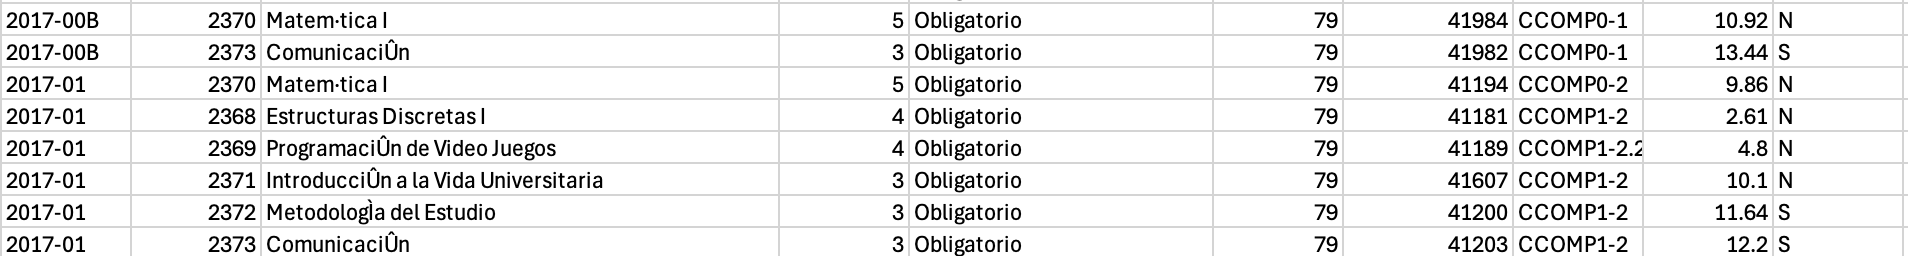

In [178]:
# # Eliminar todo registro con TIPO_CICLO igual a 'Cero'
# df_final = df_final[df_final['TIPO_CICLO'] != 'Cero']

# # verificar valores unicos de TIPO_CICLO
# uniq_sems = df_final['TIPO_CICLO'].unique()
# print('Valores unicos en TIPO_CICLO despues de eliminar Cero:', uniq_sems)

# # verificar valores unicos de PER_MATRICULA ordenadas
# uniq_sems = df_final['PER_MATRICULA'].unique()
# uniq_sems.sort()
# print('Valores unicos en PER_MATRICULA despues de la limpieza:', uniq_sems)

# # valores unicos de PER_INGRESO
# uniq_sems = df_final['PER_INGRESO'].unique()
# uniq_sems.sort()
# print('Valores unicos en PER_INGRESO despues de la limpieza:', uniq_sems)

In [179]:
print('Cantidad de registros antes de eliminar errores:', len(df_final))
# cuantos registros existen que PER_MATRICULA sea menor a PER_INGRESO, para ver si hay errores
errores_fecha = df_final[df_final['PER_MATRICULA'] < df_final['PER_INGRESO']]
print('Cantidad de errores donde PER_MATRICULA es menor a PER_INGRESO:', len(errores_fecha))


# eliminar registros donde PER_MATRICULA sea menor a PER_INGRESO
df_final = df_final[df_final['PER_MATRICULA'] >= df_final['PER_INGRESO']]
print('Cantidad de registros despues de eliminar errores:', len(df_final))


Cantidad de registros antes de eliminar errores: 27266
Cantidad de errores donde PER_MATRICULA es menor a PER_INGRESO: 337
Cantidad de registros despues de eliminar errores: 26929


In [180]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26929 entries, 36921 to 64961
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   COD_PERSONA          26929 non-null  int64         
 1   COD_ALUMNO           26929 non-null  int64         
 2   SEXO                 26929 non-null  object        
 3   PER_INGRESO          26929 non-null  object        
 4   ESTADO_CIVIL         26929 non-null  object        
 5   TIPO_COLEGIO         26929 non-null  object        
 6   PTJE_INGRESO         26929 non-null  float64       
 7   ESTADO               26929 non-null  object        
 8   SEM_ALUMNO           26929 non-null  int64         
 9   SEM_CURSADOS         26929 non-null  int64         
 10  CANT_RESERVAS        26929 non-null  int64         
 11  PER_MATRICULA        26929 non-null  object        
 12  COD_CURSO            26929 non-null  int64         
 13  CURSO                26929 non-n

### Verificacion con los cursos de la malla

In [181]:
# cursos unicos
uniq_sems = df_final['CURSO'].unique()
print('Cantidad de valores unicos en CURSO despues de la limpieza:', len(uniq_sems))
print('Valores unicos en CURSO despues de la limpieza:', uniq_sems)

Cantidad de valores unicos en CURSO despues de la limpieza: 106
Valores unicos en CURSO despues de la limpieza: ['ESTRUCTURAS DISCRETAS I' 'COMUNICACION' 'ALGEBRA Y GEOMETRIA'
 'INTRODUCCION A LA PROGRAMACION' 'METODOLOGIA DEL ESTUDIO'
 'INTRODUCCION A LA VIDA UNIVERSITARIA' 'ANALISIS MATEMATICO II'
 'OBJETOS Y ABSTRACCION DE DATOS' 'BASES DE DATOS I'
 'TEORIA DE LA COMPUTACION' 'ORATORIA Y EXPRESION PERSONAL' 'SOCIOLOGIA'
 'ESTRUCTURAS DISCRETAS II' 'INTRODUCCION A LA FILOSOFIA'
 'APRECIACION DE LA MUSICA' 'ANALISIS MATEMATICO III'
 'FISICA COMPUTACIONAL' 'ANALISIS Y DISENO DE ALGORITMOS'
 'LOGICA COMPUTACIONAL' 'ALGORITMOS Y ESTRUCTURAS DE DATOS'
 'ARQUITECTURA DE COMPUTADORES' 'ESTRUCTURAS DISCRETAS III'
 'INTRODUCCION A INTERNET' 'FORMACION DE EMPRESAS DE BASE TECNOLOGICA I'
 'FUNDAMENTOS ANTROPOLOGICOS DE LA CIENCIA' 'TEATRO'
 'INTRODUCCION A LA PROGRAMACION ORIENTADA A OBJETOS'
 'MATRIMONIO Y FAMILIA' 'INTRODUCCION A LA CIENCIA DE LA COMPUTACION'
 'ETICA' 'ANALISIS MATEMATICO I' 

In [182]:

# --- 1. Transcripción de datos de las imágenes ---
malla_2016 = [
    # Semestre I
    {'SEM': 'I', 'CODIGO': 'CS111', 'CURSO': 'Programación de Video Juegos', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': None},
    {'SEM': 'I', 'CODIGO': 'CS1D1', 'CURSO': 'Estructuras Discretas I', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': None},
    {'SEM': 'I', 'CODIGO': 'FG101', 'CURSO': 'Comunicación', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': None},
    {'SEM': 'I', 'CODIGO': 'FG102', 'CURSO': 'Metodología del Estudio', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': None},
    {'SEM': 'I', 'CODIGO': 'FG103', 'CURSO': 'Introducción a la Vida Universitaria', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': None},
    {'SEM': 'I', 'CODIGO': 'MA100', 'CURSO': 'Matemática I', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 5, 'PREREQUISITO': None},
    
    # Semestre II
    {'SEM': 'II', 'CODIGO': 'CS100', 'CURSO': 'Introducción de Ciencia de la Computación', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': 'Programación de Video Juegos'},
    {'SEM': 'II', 'CODIGO': 'CS112', 'CURSO': 'Ciencia de la Computación I', 'TIPO': 'O', 'HORAS': 8, 'CREDITOS': 5, 'PREREQUISITO': 'Programación de Video Juegos'},
    {'SEM': 'II', 'CODIGO': 'CS1D2', 'CURSO': 'Estructuras Discretas II', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Estructuras Discretas I'},
    {'SEM': 'II', 'CODIGO': 'FG104', 'CURSO': 'Introducción a la Filosofía', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': None},
    {'SEM': 'II', 'CODIGO': 'FG105', 'CURSO': 'Apreciación Musical', 'TIPO': 'EH', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': None},
    {'SEM': 'II', 'CODIGO': 'FG111', 'CURSO': 'Persona, Matrimonio y Familia', 'TIPO': 'EH', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': None},
    {'SEM': 'II', 'CODIGO': 'MA101', 'CURSO': 'Matemática II', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Matemática I'},
    
    # Semestre III
    {'SEM': 'III', 'CODIGO': 'CS113', 'CURSO': 'Ciencia de la Computación II', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Ciencia de la Computación I'},
    {'SEM': 'III', 'CODIGO': 'CS1D3', 'CURSO': 'Álgebra Abstracta', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': 'Ciencia de la Computación I, Estructura Discretas I'},
    {'SEM': 'III', 'CODIGO': 'CS221', 'CURSO': 'Arquitectura de Computadores', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': 'Estructuras Discretas II'},
    {'SEM': 'III', 'CODIGO': 'CS231', 'CURSO': 'Desarrollo Basado en Plataformas', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': 'Ciencia de la Computación I'},
    {'SEM': 'III', 'CODIGO': 'FG107', 'CURSO': 'Antropología Filosófica y Teológica', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': 'Introducción a la Filosofía'},
    {'SEM': 'III', 'CODIGO': 'FG201', 'CURSO': 'Apreciación Artística', 'TIPO': 'EH', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': None},
    {'SEM': 'III', 'CODIGO': 'FG202', 'CURSO': 'Apreciación Literaria', 'TIPO': 'EH', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': None},
    {'SEM': 'III', 'CODIGO': 'MA102', 'CURSO': 'Cálculo I', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Matemática I'},

    # Semestre IV
    {'SEM': 'IV', 'CODIGO': 'CS210', 'CURSO': 'Algoritmos y Estructuras de Datos', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Ciencia de la Computación II, Introducción de Ciencia de la Computación'},
    {'SEM': 'IV', 'CODIGO': 'CS211', 'CURSO': 'Teoría de la Computación', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Estructuras Discretas II'},
    {'SEM': 'IV', 'CODIGO': 'CS271', 'CURSO': 'Bases de Datos I', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Álgebra Abstracta'},
    {'SEM': 'IV', 'CODIGO': 'FG204', 'CURSO': 'Teología', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': 'Antropología Filosófica y Teológica'},
    {'SEM': 'IV', 'CODIGO': 'MA201', 'CURSO': 'Cálculo II', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Cálculo I, Matemática II'},
    {'SEM': 'IV', 'CODIGO': 'MA203', 'CURSO': 'Estadística y Probabilidades', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Cálculo I'},

    # Semestre V
    {'SEM': 'V', 'CODIGO': 'CB111', 'CURSO': 'Física Computacional', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Cálculo I'},
    {'SEM': 'V', 'CODIGO': 'CS212', 'CURSO': 'Análisis y Diseño de Algoritmos', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Algoritmos y Estructuras de Datos'},
    {'SEM': 'V', 'CODIGO': 'CS272', 'CURSO': 'Bases de Datos II', 'TIPO': 'O', 'HORAS': 5, 'CREDITOS': 3, 'PREREQUISITO': 'Bases de Datos I, 300 pts. Ranking de Ingles'},
    {'SEM': 'V', 'CODIGO': 'CS291', 'CURSO': 'Ingeniería de Software I', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Ciencia de la Computación II, Bases de Datos I'},
    {'SEM': 'V', 'CODIGO': 'FG106', 'CURSO': 'Teatro', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': None},
    {'SEM': 'V', 'CODIGO': 'FG210', 'CURSO': 'Moral', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': 'Teología'},
    {'SEM': 'V', 'CODIGO': 'MA306', 'CURSO': 'Análisis Numérico', 'TIPO': 'O', 'HORAS': 5, 'CREDITOS': 3, 'PREREQUISITO': 'Cálculo II'},

    # Semestre VI
    {'SEM': 'VI', 'CODIGO': 'CS292', 'CURSO': 'Ingeniería de Software II', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Ingeniería de Software I'},
    {'SEM': 'VI', 'CODIGO': 'CS251', 'CURSO': 'Sistemas Operativos', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Arquitectura de Computadores'},
    {'SEM': 'VI', 'CODIGO': 'CS311', 'CURSO': 'Programación Competitiva', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Análisis y Diseño de Algoritmos'},
    {'SEM': 'VI', 'CODIGO': 'CS312', 'CURSO': 'Estructuras de Datos Avanzadas', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Análisis y Diseño de Algoritmos'},
    {'SEM': 'VI', 'CODIGO': 'FG203', 'CURSO': 'Oratoria', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': 'Teatro'},
    {'SEM': 'VI', 'CODIGO': 'MA307', 'CURSO': 'Matemática aplicada a la Computación', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Cálculo II'},

    # Semestre VII
    {'SEM': 'VII', 'CODIGO': 'CS331', 'CURSO': 'Redes y Comunicación', 'TIPO': 'O', 'HORAS': 5, 'CREDITOS': 3, 'PREREQUISITO': 'Sistemas Operativos, 400 pts. Ranking de Ingles'},
    {'SEM': 'VII', 'CODIGO': 'CS261', 'CURSO': 'Computación Gráfica', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Estructuras de Datos Avanzadas, Análisis Numérico'},
    {'SEM': 'VII', 'CODIGO': 'CS281', 'CURSO': 'Inteligencia Artificial', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Estadística y Probabilidades'},
    {'SEM': 'VII', 'CODIGO': 'CS341', 'CURSO': 'Lenguajes de Programación', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Teoría de la Computación'},
    {'SEM': 'VII', 'CODIGO': 'CS391', 'CURSO': 'Ingeniería de Software III', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': 'Ingeniería de Software II'},
    {'SEM': 'VII', 'CODIGO': 'ET101', 'CURSO': 'Metodología de la Investigación en Computación', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': 'Análisis y Diseño de Algoritmos, 100 Créditos Aprobados'},
    {'SEM': 'VII', 'CODIGO': 'FG350', 'CURSO': 'Liderazgo', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': 'Oratoria'},

    # Semestre VIII
    {'SEM': 'VIII', 'CODIGO': 'CS201', 'CURSO': 'Computación en la Sociedad', 'TIPO': 'O', 'HORAS': 2, 'CREDITOS': 2, 'PREREQUISITO': 'Moral'},
    {'SEM': 'VIII', 'CODIGO': 'CS2H1', 'CURSO': 'Interacción Humano Computador', 'TIPO': 'O', 'HORAS': 5, 'CREDITOS': 3, 'PREREQUISITO': 'Computación Gráfica'},
    {'SEM': 'VIII', 'CODIGO': 'CS342', 'CURSO': 'Compiladores', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Lenguajes de Programación'},
    {'SEM': 'VIII', 'CODIGO': 'CS351', 'CURSO': 'Seguridad en Computación', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Redes y Comunicación'},
    {'SEM': 'VIII', 'CODIGO': 'CS3P1', 'CURSO': 'Computación Paralela y Distribuida', 'TIPO': 'O', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Redes y Comunicación, Análisis y Diseño de Algoritmos'},
    {'SEM': 'VIII', 'CODIGO': 'CS402', 'CURSO': 'Proyecto Final de Carrera I', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': 'Metodología de la Investigación en Computación'},
    {'SEM': 'VIII', 'CODIGO': 'FG205', 'CURSO': 'Historia de la Cultura', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 3, 'PREREQUISITO': None},

    # Semestre IX
    {'SEM': 'IX', 'CODIGO': 'CB309', 'CURSO': 'Computación Molecular Biológica', 'TIPO': 'EP', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Matemática aplicada a la Computación, Análisis y Diseño de Algoritmos'},
    {'SEM': 'IX', 'CODIGO': 'CS361', 'CURSO': 'Tópicos en Computación Gráfica', 'TIPO': 'EP', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Computación Gráfica'},
    {'SEM': 'IX', 'CODIGO': 'CS381', 'CURSO': 'Tópicos en Inteligencia Artificial', 'TIPO': 'EP', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Inteligencia Artificial'},
    {'SEM': 'IX', 'CODIGO': 'CS370', 'CURSO': 'Big Data', 'TIPO': 'O', 'HORAS': 5, 'CREDITOS': 3, 'PREREQUISITO': 'Computación Paralela y Distribuida, Base de Datos II'},
    {'SEM': 'IX', 'CODIGO': 'CS392', 'CURSO': 'Tópicos Avanzados en Ingeniería de Software', 'TIPO': 'EP', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Ingeniería de Software III'},
    {'SEM': 'IX', 'CODIGO': 'CS403', 'CURSO': 'Proyecto Final de Carrera II', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': 'Proyecto Final de Carrera I'},
    {'SEM': 'IX', 'CODIGO': 'ET201', 'CURSO': 'Formación de Empresas de Base Tecnológica I', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': 'Liderazgo'},
    {'SEM': 'IX', 'CODIGO': 'FG221', 'CURSO': 'Historia de la Ciencia y Tecnología', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 2, 'PREREQUISITO': 'Historia de la Cultura'},
    {'SEM': 'IX', 'CODIGO': 'FG301', 'CURSO': 'Enseñanza Social de la Iglesia', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 3, 'PREREQUISITO': 'Moral'},

    # Semestre X
    {'SEM': 'X', 'CODIGO': 'CS362', 'CURSO': 'Robótica', 'TIPO': 'EP', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Tópicos en Inteligencia Artificial'},
    {'SEM': 'X', 'CODIGO': 'CS393', 'CURSO': 'Sistemas de Información', 'TIPO': 'EP', 'HORAS': 6, 'CREDITOS': 4, 'PREREQUISITO': 'Ingeniería de Software II'},
    {'SEM': 'X', 'CODIGO': 'CS3P2', 'CURSO': 'Cloud Computing', 'TIPO': 'O', 'HORAS': 5, 'CREDITOS': 3, 'PREREQUISITO': 'Big Data'},
    {'SEM': 'X', 'CODIGO': 'CS404', 'CURSO': 'Proyecto Final de Carrera III', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': 'Proyecto Final de Carrera II'},
    {'SEM': 'X', 'CODIGO': 'ET301', 'CURSO': 'Formación de Empresas de Base Tecnológica II', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': 'Formación de Empresas de Base Tecnológica I'},
    {'SEM': 'X', 'CODIGO': 'FG211', 'CURSO': 'Ética Profesional', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 3, 'PREREQUISITO': 'Enseñanza Social de la Iglesia'},
    {'SEM': 'X', 'CODIGO': 'FG220', 'CURSO': 'Análisis de la Realidad Peruana', 'TIPO': 'O', 'HORAS': 3, 'CREDITOS': 3, 'PREREQUISITO': 'Historia de la Ciencia y Tecnología'},
    {'SEM': 'X', 'CODIGO': 'ID101', 'CURSO': 'Inglés Técnico Profesional', 'TIPO': 'O', 'HORAS': 4, 'CREDITOS': 3, 'PREREQUISITO': None},
]

# --- 2. Creación del DataFrame ---
df_malla_curricular_2016 = pd.DataFrame(malla_2016)

# --- 3. Aplicación de las reglas de formato ---
# Aplicar normalización a la columna CURSO
df_malla_curricular_2016['CURSO'] = df_malla_curricular_2016['CURSO'].apply(normalizar_curso)
# Aplicar conversión a lista en la columna PREREQUISITO
df_malla_curricular_2016['PREREQUISITO'] = df_malla_curricular_2016['PREREQUISITO'].apply(convertir_prereq_a_lista)


# --- 4. Verificación del Resultado ---
print("DataFrame creado con cursos de la malla 2016:")
print(df_malla_curricular_2016.info())
print(df_malla_curricular_2016.head(10))


DataFrame creado con cursos de la malla 2016:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SEM           71 non-null     object
 1   CODIGO        71 non-null     object
 2   CURSO         71 non-null     object
 3   TIPO          71 non-null     object
 4   HORAS         71 non-null     int64 
 5   CREDITOS      71 non-null     int64 
 6   PREREQUISITO  71 non-null     object
dtypes: int64(2), object(5)
memory usage: 4.0+ KB
None
  SEM CODIGO                                      CURSO TIPO  HORAS  CREDITOS  \
0   I  CS111               PROGRAMACION DE VIDEO JUEGOS    O      6         4   
1   I  CS1D1                    ESTRUCTURAS DISCRETAS I    O      6         4   
2   I  FG101                               COMUNICACION    O      4         3   
3   I  FG102                    METODOLOGIA DEL ESTUDIO    O      4         3   
4   I  FG103  

In [183]:
# cursos de la malla 2016
cursos_2016 = df_malla_curricular_2016['CURSO'].unique()
print ('Cursos de la malla 2016:', cursos_2016)

Cursos de la malla 2016: ['PROGRAMACION DE VIDEO JUEGOS' 'ESTRUCTURAS DISCRETAS I' 'COMUNICACION'
 'METODOLOGIA DEL ESTUDIO' 'INTRODUCCION A LA VIDA UNIVERSITARIA'
 'MATEMATICA I' 'INTRODUCCION DE CIENCIA DE LA COMPUTACION'
 'CIENCIA DE LA COMPUTACION I' 'ESTRUCTURAS DISCRETAS II'
 'INTRODUCCION A LA FILOSOFIA' 'APRECIACION MUSICAL'
 'PERSONA, MATRIMONIO Y FAMILIA' 'MATEMATICA II'
 'CIENCIA DE LA COMPUTACION II' 'ALGEBRA ABSTRACTA'
 'ARQUITECTURA DE COMPUTADORES' 'DESARROLLO BASADO EN PLATAFORMAS'
 'ANTROPOLOGIA FILOSOFICA Y TEOLOGICA' 'APRECIACION ARTISTICA'
 'APRECIACION LITERARIA' 'CALCULO I' 'ALGORITMOS Y ESTRUCTURAS DE DATOS'
 'TEORIA DE LA COMPUTACION' 'BASES DE DATOS I' 'TEOLOGIA' 'CALCULO II'
 'ESTADISTICA Y PROBABILIDADES' 'FISICA COMPUTACIONAL'
 'ANALISIS Y DISENO DE ALGORITMOS' 'BASES DE DATOS II'
 'INGENIERIA DE SOFTWARE I' 'TEATRO' 'MORAL' 'ANALISIS NUMERICO'
 'INGENIERIA DE SOFTWARE II' 'SISTEMAS OPERATIVOS'
 'PROGRAMACION COMPETITIVA' 'ESTRUCTURAS DE DATOS AVANZADAS' 'OR

In [184]:
# verificar que todos los cursos en df_final estén en la malla curricular
cursos_final = df_final['CURSO'].unique()
cursos_malla = df_malla_curricular_2016['CURSO'].unique()
cursos_no_en_malla = [curso for curso in cursos_final if curso not in cursos_malla]
print("Cursos en df_final que no están en la malla curricular:", cursos_no_en_malla)

Cursos en df_final que no están en la malla curricular: ['ALGEBRA Y GEOMETRIA', 'INTRODUCCION A LA PROGRAMACION', 'ANALISIS MATEMATICO II', 'OBJETOS Y ABSTRACCION DE DATOS', 'ORATORIA Y EXPRESION PERSONAL', 'SOCIOLOGIA', 'APRECIACION DE LA MUSICA', 'ANALISIS MATEMATICO III', 'LOGICA COMPUTACIONAL', 'ESTRUCTURAS DISCRETAS III', 'INTRODUCCION A INTERNET', 'FUNDAMENTOS ANTROPOLOGICOS DE LA CIENCIA', 'INTRODUCCION A LA PROGRAMACION ORIENTADA A OBJETOS', 'MATRIMONIO Y FAMILIA', 'INTRODUCCION A LA CIENCIA DE LA COMPUTACION', 'ETICA', 'ANALISIS MATEMATICO I', 'ARTES PLASTICAS', 'BASE DE DATOS II', 'TEOLOGIA I', 'PSICOLOGIA', 'PROYECTO I', 'ALGORITMOS PARALELOS', 'TEOLOGIA II', 'PROYECTO DE TESIS', 'TOPICOS EN BASES DE DATOS', 'PROYECTO II', 'COMPUTACION CENTRADA EN REDES', 'CALIDAD DE SOFTWARE', 'ASPECTOS SOCIALES Y PROFESIONALES DE LA COMPUTACION', 'SEMINARIO DE TESIS', 'COMPUTACION BIOINSPIRADA', 'METODOS FORMALES', 'LIDERAZGO Y DESEMPENO', 'PROGRAMACION DE DISPOSITIVOS MOVILES']


### Convalidacion (malla 2011 a malla 2016)

In [185]:
# Mapeo de equivalencias de códigos de la Malla 2011 a la Malla 2016
# Clave: Código 2011
# Valor: Código 2016 (o None si no hay un equivalente claro)
mapa_equivalencias_2011_a_2016 = {
    # Semestre I
    'CB101': 'MA100',    # Álgebra y Geometría -> Matemática I
    'FG101': 'FG101',    # Comunicación -> Comunicación (Coincidencia exacta)
    'CS1D01': 'CS1D1',   # Estructuras Discretas I -> Estructuras Discretas I
    'CS1I01F': 'CS112',  # Introducción a la Programación -> Ciencia de la Computación I
    'FG103': 'FG103',    # Introducción a la Vida Universitaria -> Introducción a la Vida Universitaria
    'FG102': 'FG102',    # Metodología del Círculo -> Metodología del Estudio
    
    # Semestre II
    'CB102': 'MA101',    # Análisis Matemático I -> Matemática II
    'FG105': 'FG105',    # Apreciación de la Música -> Apreciación Musical
    'CS1D02': 'CS1D2',   # Estructuras Discretas II -> Estructuras Discretas II
    'CS1I00': 'CS100',   # Introducción a la Ciencia de la Computación -> Introducción de Ciencia de la Computación
    'FG104': 'FG104',    # Introducción a la Filosofía -> Introducción a la Filosofía
    'CS1O10': 'CS113',   # Introducción a la Programación Orientada a Objetos -> Ciencia de la Computación II (Sucesor de CS1)
    'FG112': 'FG111',    # Matrimonio y Familia -> Persona, Matrimonio y Familia
    'FG106': 'FG106',    # Teatro -> Teatro (Coincidencia exacta)
    
    # Semestre III
    'CB103': 'MA102',    # Análisis Matemático II -> Cálculo I
    'FG202': 'FG202',    # Apreciación Literaria -> Apreciación Literaria (Coincidencia exacta)
    'CS220T': 'CS221',   # Arquitectura de Computadores -> Arquitectura de Computadores
    'FG201': 'FG201',    # Artes Plásticas -> Apreciación Artística
    'CS1D7': 'CS1D3',    # Estructuras Discretas III -> Álgebra Abstracta (Evolución curricular común)
    'FG107': 'FG107',    # Fundamentos Antropológicos de la Ciencia -> Antropología Filosófica y Teológica
    'CS1I30': 'CS231',   # Introducción a Internet -> Desarrollo Basado en Plataformas (Consolidación)
    'CS1O20': 'CS210',   # Objetos y Abstracción de Datos -> Algoritmos y Estructuras de Datos
    'FG203': 'FG203',    # Oratoria y Expresión Corporal -> Oratoria
    
    # Semestre IV
    'CS1D30': 'CS210',   # Algoritmos y Estructuras de Datos -> Algoritmos y Estructuras de Datos
    'CB201': 'MA201',    # Análisis Matemático III -> Cálculo II
    'CS270T': 'CS271',   # Bases de Datos I -> Bases de Datos I
    'CB203': 'MA203',    # Estadística y Probabilidades -> Estadística y Probabilidades
    'CS211T': 'CS211',   # Teoría de la Computación -> Teoría de la Computación
    
    # Semestre V
    'CB306': 'MA306',    # Análisis Numérico -> Análisis Numérico
    'CS210T': 'CS212',   # Análisis y Diseño de Algoritmos -> Análisis y Diseño de Algoritmos
    'CS272T': 'CS272',   # Base de Datos II -> Bases de Datos II
    'FG210': 'FG210',    # Ética -> Moral
    'CB111': 'CB111',    # Física Computacional -> Física Computacional (Coincidencia exacta)
    'CS290T': 'CS291',   # Ingeniería de Software I -> Ingeniería de Software I
    'FG209': 'FG106',       # Psicología (EH) -> Sin equivalente
    'FG206': 'FG210',       # Sociología (EH) -> Sin equivalente
    
    # Semestre VI
    'CS315': 'CS312',    # Estructuras de Datos Avanzadas -> Estructuras de Datos Avanzadas
    'CS390': 'CS292',    # Ingeniería de Software II -> Ingeniería de Software II
    'CS281': None,       # Lógica Computacional -> Sin equivalente directo (Absorbido por otras)
    'CB207': 'MA307',    # Matemática Aplicada a la Computación -> Matemática aplicada a la Computación
    'CS225T': 'CS251',   # Sistemas Operativos -> Sistemas Operativos
    'FG204': 'FG204',    # Teología I -> Teología
    
    # Semestre VII
    'CS314': 'CS3P1',    # Algoritmos Paralelos -> Computación Paralela y Distribuida
    'CS261T': 'CS281',   # Inteligencia Artificial -> Inteligencia Artificial
    'CS2S0W': 'CS2H1',   # Interacción Humano Computador -> Interacción Humano Computador
    'CS343': 'CS341',    # Lenguajes de Programación -> Lenguajes de Programación
    'CS401': 'ET101',    # Proyecto I -> Metodología de la Investigación en Computación (Inicio de línea de proyecto)
    'CS336': 'CS351',    # Seguridad en Computación -> Seguridad en Computación
    'FG204A': 'FG301',   # Teología II -> Enseñanza Social de la Iglesia (Sucesor lógico de la línea de teología)
    
    # Semestre VIII
    'CS280T': 'CS201',   # Aspectos Sociales y Profesionales de la Computación -> Computación en la Sociedad
    'CS392': 'CS391',    # Calidad de Software -> Ingeniería de Software III (Absorbido en el curso avanzado)
    'CS340S': 'CS342',   # Compiladores -> Compiladores
    'CS2SOW': 'CS331',   # Computación Centrada en Redes -> Redes y Comunicación
    'CS255': 'CS261',    # Computación Gráfica -> Computación Gráfica
    'FG205': 'FG205',    # Historia de la Cultura -> Historia de la Cultura (Coincidencia exacta)
    'CS402': 'CS402',    # Proyecto II -> Proyecto Final de Carrera I

    # Semestre IX (Mayoría son Electivos - EG)
    'CS360': None,       # Computación Bioinspirada (EG) -> Sin equivalente
    'CB309': 'CB309',    # Computación Molecular Biológica (EG) -> Computación Molecular Biológica (EG)
    'FG301': 'FG301',    # Enseñanza Social de la Iglesia -> Enseñanza Social de la Iglesia
    'EI101': 'ET201',    # Formación de Empresas de Base Tecnológica I -> Formación de Empresas de Base Tecnológica I
    'FG221': 'FG221',    # Historia de la Ciencia y Tecnología -> Historia de la Ciencia y Tecnología
    'CS393': None,       # Métodos Formales (EG) -> Sin equivalente
    'CS400': 'CS403',    # Proyecto de Tesis -> Proyecto Final de Carrera II
    'CS370': 'CS370',    # Tópicos en Bases de Datos (EG) -> Big Data (Evolución del tópico)
    'CS355': 'CS361',    # Tópicos en Computación Gráfica (EG) -> Tópicos en Computación Gráfica (EG)
    'CS361': 'CS381',    # Tópicos en Inteligencia Artificial (EG) -> Tópicos en Inteligencia Artificial (EG)
    
    # Semestre X
    'FG220': 'FG220',    # Análisis de la Realidad Peruana -> Análisis de la Realidad Peruana
    'CS331': 'CS3P2',    # Cloud Computing -> Cloud Computing
    'FG211': 'FG211',    # Ética Profesional -> Ética Profesional
    'EI102': 'ET301',    # Formación de Empresas de Base Tecnológica II -> Formación de Empresas de Base Tecnológica II
    'FG230': 'FG350',    # Liderazgo y Desempeño -> Liderazgo
    'CS232W': 'CS231',   # Programación de Dispositivos Móviles -> Desarrollo Basado en Plataformas (Consolidación)
    'CS356': 'CS111',    # Programación de Video Juegos (EG) -> Programación de Video Juegos (Ahora es curso base)
    'CS367': 'CS362',    # Robótica (EG) -> Robótica (EG)
    'CS404': 'CS404',    # Seminario de Tesis -> Proyecto Final de Carrera III
}

# (Opcional) Contar cuántos cursos se mapearon y cuántos quedaron huérfanos
mapeados = sum(1 for codigo in mapa_equivalencias_2011_a_2016.values() if codigo is not None)
huerfanos = len(mapa_equivalencias_2011_a_2016) - mapeados

print(f"Total de cursos 2011: {len(mapa_equivalencias_2011_a_2016)}")
print(f"Mapeados exitosamente: {mapeados}")
print(f"Cursos sin equivalente (huérfanos): {huerfanos}")

# --- 1. ASUMCIONES INICIALES ---
# Asumo que ya tienes cargados:
# df_malla_curricular_2011: DataFrame con columnas 'CODIGO' y 'CURSO'
# df_malla_curricular_2016: DataFrame con columnas 'CODIGO' y 'CURSO'
# mapa_equivalencias_2011_a_2016: El diccionario { 'CB101': 'MA100', ... }


# --- 2. CREAR MAPAS DE BÚSQUEDA (MUCHO MÁS RÁPIDO) ---
# Esto crea un diccionario como {'CB101': 'Álgebra y Geometría', ...}
mapa_nombres_2011 = pd.Series(
    df_malla_curricular_2011.CURSO.values, 
    index=df_malla_curricular_2011.CODIGO
).to_dict()

mapa_nombres_2016 = pd.Series(
    df_malla_curricular_2016.CURSO.values, 
    index=df_malla_curricular_2016.CODIGO
).to_dict()


# --- 3. CONSTRUIR LA LISTA DE EQUIVALENCIAS (EL ARREGLO) ---
# En lugar de modificar el diccionario original, creamos una lista
lista_equivalencias = []

print("Procesando equivalencias...")
# Iteramos sobre el diccionario de mapeo
for codigo_2011, codigo_2016 in mapa_equivalencias_2011_a_2016.items():
    
    # Buscar el nombre 2011 en nuestro mapa de búsqueda
    nombre_2011 = mapa_nombres_2011.get(codigo_2011)
    
    # Buscar el nombre 2016 (si existe)
    nombre_2016 = None  # Por defecto es None
    if codigo_2016 is not None:
        nombre_2016 = mapa_nombres_2016.get(codigo_2016)
    
    # Añadimos la fila completa (como un diccionario) a nuestra lista
    lista_equivalencias.append({
        'Codigo_2011': codigo_2011,
        'Curso_2011': nombre_2011,
        'Codigo_2016_Equivalente': codigo_2016,
        'Curso_2016_Equivalente': nombre_2016
    })
    
    # El print para verificar
    # print(f"2011: {codigo_2011} - {nombre_2011}  -->  2016: {codigo_2016} - {nombre_2016}")


# --- 4. CREAR EL DATAFRAME Y EXPORTAR ---
# Creamos el DataFrame a partir de la LISTA de diccionarios
df_equivalencias = pd.DataFrame(lista_equivalencias)

# Descargarlo en excel
excel_filename = 'datasets/equivalencias_malla_2011_2016.xlsx'
df_equivalencias.to_excel(excel_filename, index=False, engine='openpyxl')

print(f"\n¡Listo! Archivo guardado como: {excel_filename}")
print(df_equivalencias.head())

Total de cursos 2011: 75
Mapeados exitosamente: 72
Cursos sin equivalente (huérfanos): 3
Procesando equivalencias...

¡Listo! Archivo guardado como: datasets/equivalencias_malla_2011_2016.xlsx
  Codigo_2011                            Curso_2011 Codigo_2016_Equivalente  \
0       CB101                   ALGEBRA Y GEOMETRIA                   MA100   
1       FG101                          COMUNICACION                   FG101   
2      CS1D01               ESTRUCTURAS DISCRETAS I                   CS1D1   
3     CS1I01F        INTRODUCCION A LA PROGRAMACION                   CS112   
4       FG103  INTRODUCCION A LA VIDA UNIVERSITARIA                   FG103   

                 Curso_2016_Equivalente  
0                          MATEMATICA I  
1                          COMUNICACION  
2               ESTRUCTURAS DISCRETAS I  
3           CIENCIA DE LA COMPUTACION I  
4  INTRODUCCION A LA VIDA UNIVERSITARIA  


In [186]:
# eliminar los cursos  df_final con codigo CS393 
df_final = df_final[df_final['CURSO'] != 'LOGICA COMPUTACIONAL']
df_final = df_final[df_final['CURSO'] != 'METODOS FORMALES']
df_final = df_final[df_final['CURSO'] != 'COMPUTACION BIOINSPIRADA']

# valores únicos en la columna 'COD_CURSO' después de la eliminación
codigos_unicos_despues = df_final['COD_CURSO'].unique()
print("Códigos únicos en 'COD_CURSO' después de la eliminación:", codigos_unicos_despues)


Códigos únicos en 'COD_CURSO' después de la eliminación: [1287 1286 1285 1288 1290 1289 1299 1306 1310 1312 1307 1320 1293 1295
 1292 1309 1317 1314 1308 1301 1303 1305 1344 1304 1298 1296 1297 1294
 1316 1291 1325 1322 1313 1302 1315 1326 1324 1318 1319 1354 1328 1331
 1327 1311 1333 1332 1347 1300 1348 1340 1329 1337 1338 1345 1353 1336
 1321 1330 1339 1342 1343 1358 1335 1334 1351 1359 1350 1355 2375 2376
 2422 2423 2379 2380 2427 2382 2372 2377 2425 2374 2370 2371 2373 2368
 2369 2426 2391 2424 2428 2389 2378 2386 2394 2407 1356 1352 2381 2385
 2384 2398 2393 1357 2383 1349 2387 2399 2392 2390 2388 2400 2396 2431
 2432 2395 2401 2397 2403 2412 2430 2405 2434 2413 2402 2420 2410 2414
 2436 2437 2406 2415 2404 2408 2429 2433 2416 2419 2438 2435 2411 2409
 2417 2418 2421]


In [187]:
# df_equivalencias renombrar Codigo_2016_Equivalente a COD_CURSO 
df_equivalencias = df_equivalencias.rename(columns={'Codigo_2016_Equivalente': 'COD_CURSO'})
df_equivalencias = df_equivalencias.rename(columns={'Curso_2016_Equivalente': 'CURSO'})

df_equivalencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Codigo_2011  75 non-null     object
 1   Curso_2011   75 non-null     object
 2   COD_CURSO    72 non-null     object
 3   CURSO        72 non-null     object
dtypes: object(4)
memory usage: 2.5+ KB


In [188]:

# 1. Preparar el DataFrame de equivalencias (el "mapa")
#    Eliminamos filas donde los nuevos códigos o cursos sean nulos.
df_map = df_equivalencias.dropna(subset=['COD_CURSO', 'CURSO']).copy()

# 2. Corregir tipos de datos (¡El paso clave!)
#    Ya que la columna 'COD_CURSO' en equivalencias es 'object',
#    la trataremos como texto. Convertimos explícitamente a string
#    para asegurar que todos los valores (números, texto, etc.) 
#    se traten como texto.
df_map['COD_CURSO'] = df_map['COD_CURSO'].astype(str)

# 3. Crear los diccionarios de mapeo
#    Mapa 1: Nombre_Viejo -> Nombre_Nuevo
map_nombres = pd.Series(df_map['CURSO'].values, 
                        index=df_map['Curso_2011']).to_dict()

#    Mapa 2: Nombre_Viejo -> Codigo_Nuevo (ahora como string)
map_codigos = pd.Series(df_map['COD_CURSO'].values, 
                        index=df_map['Curso_2011']).to_dict()

# 4. Identificar las filas en df_final que necesitan actualización
filas_a_actualizar = df_final['CURSO'].isin(map_nombres.keys())

# 5. Realizar la actualización usando .loc y .map
if filas_a_actualizar.any():
    # Guardamos los nombres originales ANTES de modificarlos
    nombres_originales = df_final.loc[filas_a_actualizar, 'CURSO']
    
    # Actualizamos el COD_CURSO usando el mapa de códigos (texto)
    df_final.loc[filas_a_actualizar, 'COD_CURSO'] = nombres_originales.map(map_codigos)
    
    # Actualizamos el CURSO (nombre) usando el mapa de nombres
    df_final.loc[filas_a_actualizar, 'CURSO'] = nombres_originales.map(map_nombres)

    print(f"Se actualizaron {filas_a_actualizar.sum()} filas en df_final.")
    
    # NOTA IMPORTANTE:
    # Al asignar códigos de texto ('object') a la columna 'COD_CURSO'
    # (que era 'int64'), Pandas automáticamente convertirá
    # TODA esa columna a 'object' para evitar pérdida de datos.
    print("La columna 'COD_CURSO' en df_final ahora es de tipo 'object'.")

else:
    print("No se encontraron cursos para actualizar.")

# Verificamos el cambio de tipo en df_final
# print(df_final.info())

Se actualizaron 20671 filas en df_final.
La columna 'COD_CURSO' en df_final ahora es de tipo 'object'.


/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_83302/2440984546.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['CS1D1' 'FG101' 'CS1D1' ... 'CS351' 'CS231' 'CS1D2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_final.loc[filas_a_actualizar, 'COD_CURSO'] = nombres_originales.map(map_codigos)


In [189]:
# cod_curso valores unicos en df_final despues del mapeo
uniq_sems = df_final['COD_CURSO'].unique()
print('Valores unicos en COD_CURSO despues del mapeo:', uniq_sems)
# la cantidad de cursos en df_final debe ser 68
print("Cantidad de cursos en df_final despues del mapeo:", len(uniq_sems))




Valores unicos en COD_CURSO despues del mapeo: ['CS1D1' 'FG101' 'MA100' 'CS112' 1290 'FG103' 'MA102' 'CS210' 'CS271'
 'CS211' 'FG203' 'FG210' 'CS1D2' 'FG104' 'FG105' 'MA201' 'CB111' 'CS212'
 'CS221' 'CS1D3' 'CS231' 'ET201' 'FG107' 'FG106' 'CS113' 'FG111' 'CS100'
 'MA101' 'CS251' 'CS292' 'MA306' 'FG201' 'CS272' 'FG204' 'MA307' 'CS291'
 'ET301' 'CS281' 'ET101' 'CS3P1' 'MA203' 'FG301' 'CS351' 'CS403' 'FG202'
 'CS370' 'CS402' 'CS2H1' 'CS331' 'CS261' 'FG221' 'FG211' 'CS342' 'CS312'
 'CS341' 'FG205' 'CB309' 'CS362' 'CS391' 'CS201' 'FG220' 'CS404' 'CS381'
 'FG350' 2375 2422 2423 2380 2427 2372 2377 2425 2370 'CS111' 2426 2424
 2428 2378 'CS3P2' 2381 2393 'CS361' 2387 2399 2390 2431 2432 2403 2430
 2434 2436 2437 2406 2408 2429 2433 2416 2438 2417]
Cantidad de cursos en df_final despues del mapeo: 99


In [190]:
# cambiaremos los cod_curso de df_final por los codigos de la malla curricular
mapeo_codigos = dict(zip(df_malla_curricular_2016['CURSO'], df_malla_curricular_2016['CODIGO']))
df_final['COD_CURSO'] = df_final['CURSO'].map(mapeo_codigos)


# cambiamos los HORAS y CREDITOS de df_final por los de la malla curricular
mapeo_horas = dict(zip(df_malla_curricular_2016['CURSO'], df_malla_curricular_2016['HORAS']))
df_final['HRS_CURSO'] = df_final['CURSO'].map(mapeo_horas)

mapeo_creditos = dict(zip(df_malla_curricular_2016['CURSO'], df_malla_curricular_2016['CREDITOS']))
df_final['CREDITOS'] = df_final['CURSO'].map(mapeo_creditos)

mapeo_creditos = dict(zip(df_malla_curricular_2016['CURSO'], df_malla_curricular_2016['TIPO']))
df_final['TIPO_CURSO'] = df_final['CURSO'].map(mapeo_creditos)

# se le agrega una nueva columna de NIVEL_CURSO basada en semestre hecho nuemero
def semestre_a_nivel(semestre):
    mapping = {
        'I': 1,
        'II': 2,
        'III': 3,
        'IV': 4,
        'V': 5,
        'VI': 6,
        'VII': 7,
        'VIII': 8,
        'IX': 9,
        'X': 10
    }
    return mapping.get(semestre, None)
# Modificar los valores SEM de df_malla_curricular con semestre_a_nivel
df_malla_curricular_2016['SEM'] = df_malla_curricular_2016['SEM'].apply(semestre_a_nivel)

# generar FAMILIA en la malla curricular partiendo el CODIGO por los dos primeros caracteres
df_malla_curricular_2016['FAMILIA'] = df_malla_curricular_2016['CODIGO'].str[:2]



df_final = df_final.merge(
    df_malla_curricular_2016[['CODIGO', 'SEM']],
    left_on='COD_CURSO',
    right_on='CODIGO',
    how='left'
)

# cod_curso de df_final  con el cod_curso de la malla curricular le añadimos la columna SEM como NIVEL_CURSO , df_final no tiene SEM
df_final['NIVEL_CURSO'] = df_final['COD_CURSO'].map(df_malla_curricular_2016.set_index('CODIGO')['SEM'])

# renombrar CORDIGO a COD_CURSO
df_malla_curricular_2016 = df_malla_curricular_2016.rename(columns={'CODIGO': 'COD_CURSO'})
# renombrar SEM a NIVEL_CURSO
df_malla_curricular_2016 = df_malla_curricular_2016.rename(columns={'SEM': 'NIVEL_CURSO'})
# RENOMBRAR HORAS a HRS_CURSO
df_malla_curricular_2016 = df_malla_curricular_2016.rename(columns={'HORAS': 'HRS_CURSO'})
# RENOMBRAR TIPO a TIPO_CURSO
df_malla_curricular_2016 = df_malla_curricular_2016.rename(columns={'TIPO': 'TIPO_CURSO'})
df_malla_curricular_2016.info()

# VALORES UNICOS DE TIPO_CURSO
uniq_sems = df_malla_curricular_2016['TIPO_CURSO'].unique()
print('Valores unicos en TIPO_CURSO:', uniq_sems)


# eliminar PREREQUISITO de df_malla_curricular
df_curso_original = df_malla_curricular_2016.drop(columns=['PREREQUISITO'], errors='ignore')
df_curso_original.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   NIVEL_CURSO   71 non-null     int64 
 1   COD_CURSO     71 non-null     object
 2   CURSO         71 non-null     object
 3   TIPO_CURSO    71 non-null     object
 4   HRS_CURSO     71 non-null     int64 
 5   CREDITOS      71 non-null     int64 
 6   PREREQUISITO  71 non-null     object
 7   FAMILIA       71 non-null     object
dtypes: int64(3), object(5)
memory usage: 4.6+ KB
Valores unicos en TIPO_CURSO: ['O' 'EH' 'EP']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   NIVEL_CURSO  71 non-null     int64 
 1   COD_CURSO    71 non-null     object
 2   CURSO        71 non-null     object
 3   TIPO_CURSO   71 non-null     object
 4   HRS_CURSO    71 non-null     

In [191]:
# cantidad de valores unicos de los cursos despues del mapeo
uniq_sems = df_final['CURSO'].unique()
print('Cantidad de valores unicos en CURSO despues del mapeo:', len(uniq_sems))

Cantidad de valores unicos en CURSO despues del mapeo: 71


In [192]:
# generar un nuevo feature llamado 'FAMILIA' que extraiga los 3 primeros caracteres de COD_CURSO
df_final['FAMILIA'] = df_final['COD_CURSO'].str[:2]
# valores unicos de FAMILIA
uniq_sems = df_final['FAMILIA'].unique()
print('Valores unicos en FAMILIA:', uniq_sems)

Valores unicos en FAMILIA: ['CS' 'FG' 'MA' 'CB' 'ET' 'ID']


In [193]:
# valores unicos de TIPO_CURSO
uniq_sems = df_final['TIPO_CURSO'].unique()
print('Valores unicos en TIPO_CURSO:', uniq_sems)


Valores unicos en TIPO_CURSO: ['O' 'EH' 'EP']


In [194]:
# eliminar a alumnos_pa_cero
df_final = df_final[~df_final['COD_PERSONA'].isin([38219])]

In [195]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26665 entries, 0 to 26670
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   COD_PERSONA          26665 non-null  int64         
 1   COD_ALUMNO           26665 non-null  int64         
 2   SEXO                 26665 non-null  object        
 3   PER_INGRESO          26665 non-null  object        
 4   ESTADO_CIVIL         26665 non-null  object        
 5   TIPO_COLEGIO         26665 non-null  object        
 6   PTJE_INGRESO         26665 non-null  float64       
 7   ESTADO               26665 non-null  object        
 8   SEM_ALUMNO           26665 non-null  int64         
 9   SEM_CURSADOS         26665 non-null  int64         
 10  CANT_RESERVAS        26665 non-null  int64         
 11  PER_MATRICULA        26665 non-null  object        
 12  COD_CURSO            26665 non-null  object        
 13  CURSO                26665 non-null 

In [196]:
# VALORES DE codigo en df_final
codigos_unicos = df_final['CODIGO'].unique()
print("Códigos únicos en 'CODIGO':", codigos_unicos)
print("cantidad únicos en 'CODIGO':", len(codigos_unicos))


Códigos únicos en 'CODIGO': ['CS1D1' 'FG101' 'MA100' 'CS112' 'FG102' 'FG103' 'MA102' 'CS210' 'CS271'
 'CS211' 'FG203' 'FG210' 'CS1D2' 'FG104' 'FG105' 'MA201' 'CB111' 'CS212'
 'CS221' 'CS1D3' 'CS231' 'ET201' 'FG107' 'FG106' 'CS113' 'FG111' 'CS100'
 'MA101' 'CS251' 'CS292' 'MA306' 'FG201' 'CS272' 'FG204' 'MA307' 'CS291'
 'ET301' 'CS281' 'ET101' 'CS3P1' 'MA203' 'FG301' 'CS351' 'CS403' 'FG202'
 'CS370' 'CS402' 'CS2H1' 'CS331' 'CS261' 'FG221' 'FG211' 'CS342' 'CS312'
 'CS341' 'FG205' 'CB309' 'CS362' 'CS391' 'CS201' 'FG220' 'CS404' 'CS381'
 'FG350' 'CS111' 'CS3P2' 'CS361' 'CS392' 'CS311' 'ID101' 'CS393']
cantidad únicos en 'CODIGO': 71


In [197]:
# dataset con datos limpios sin nulos 
df_clean = df_final.copy()
# df_clean sin NOTA_ENCUESTA_DOC_GRUPO
df_clean = df_clean.drop(columns=['NOTA_ENCUESTA_DOC_GRUPO'], errors='ignore')
# imputar PTJE_INGRESO con la mediana
mediana_ptje_ingreso = df_clean['PTJE_INGRESO'].median()
df_clean['PTJE_INGRESO'] = df_clean['PTJE_INGRESO'].fillna(mediana_ptje_ingreso)
# eliminar todos los nulos
df_clean = df_clean.dropna()
# eliminar todo de ubicaciones departamento provincias y distritos
df_clean = df_clean.drop(columns=['PROCEDENCIA','RESIDENCIA', 'SEM_ALUMNO'], errors='ignore')
print("Dimensiones de df_clean (sin nulos):", df_clean.shape)

df_clean.info()

Dimensiones de df_clean (sin nulos): (26665, 34)
<class 'pandas.core.frame.DataFrame'>
Index: 26665 entries, 0 to 26670
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   COD_PERSONA          26665 non-null  int64         
 1   COD_ALUMNO           26665 non-null  int64         
 2   SEXO                 26665 non-null  object        
 3   PER_INGRESO          26665 non-null  object        
 4   ESTADO_CIVIL         26665 non-null  object        
 5   TIPO_COLEGIO         26665 non-null  object        
 6   PTJE_INGRESO         26665 non-null  float64       
 7   ESTADO               26665 non-null  object        
 8   SEM_CURSADOS         26665 non-null  int64         
 9   CANT_RESERVAS        26665 non-null  int64         
 10  PER_MATRICULA        26665 non-null  object        
 11  COD_CURSO            26665 non-null  object        
 12  CURSO                26665 non-null  object 

In [198]:
print("--- Limpieza de Matrículas Duplicadas (Mismo Alumno, Curso, Periodo) ---")

# 1. Contar filas originales para el reporte
filas_originales = len(df_clean)
print(f"Filas totales antes de la limpieza: {filas_originales}")

# (Opcional) Contar cuántas filas están implicadas en duplicados antes de hacer nada
duplicados_implicados = df_clean.duplicated(subset=['COD_PERSONA', 'COD_CURSO', 'PER_MATRICULA'], keep=False)
print(f"Cantidad de filas que son parte de un duplicado: {duplicados_implicados.sum()}")

# 2. Ordenar el DataFrame por NOTA
#    La clave aquí es ordenar por las notas de forma DESCENDENTE (ascending=False).
#    De esta forma, la fila con la nota más alta aparecerá PRIMERO en cualquier grupo de duplicados.
df_ordenado = df_clean.sort_values(by='NOTA', ascending=False)

# 3. Eliminar duplicados, conservando la primera fila
#    Usamos 'keep="first"'
#    Como el DataFrame está ordenado por nota descendente, la 'primera' fila
#    será siempre la que tiene la nota más alta.
df_clean_limpio = df_ordenado.drop_duplicates(
    subset=['COD_PERSONA', 'COD_CURSO', 'PER_MATRICULA'],
    keep='first'
)

# 4. Reportar los resultados
filas_nuevas = len(df_clean_limpio)
filas_eliminadas = filas_originales - filas_nuevas

print(f"\nFilas eliminadas después de la limpieza: {filas_eliminadas}")
print(f"Filas restantes en el DataFrame: {filas_nuevas}")

# 5. (Opcional) Restaurar el orden original del DataFrame
#    drop_duplicates() mantiene el orden del df_ordenado.
#    Si prefieres tener el DataFrame en su orden original (por índice),
#    puedes usar .sort_index()
df_clean = df_clean_limpio
print("DataFrame limpio y re-ordenado por su índice original.")

# Ahora 'df_final' contiene solo una entrada por (alumno, curso, periodo),
# y esa entrada es la que tiene la nota más alta.

--- Limpieza de Matrículas Duplicadas (Mismo Alumno, Curso, Periodo) ---
Filas totales antes de la limpieza: 26665
Cantidad de filas que son parte de un duplicado: 412

Filas eliminadas después de la limpieza: 206
Filas restantes en el DataFrame: 26459
DataFrame limpio y re-ordenado por su índice original.


## Normalizacion

In [199]:
# Eliminar weas en pro de la normalizacion del dataset

# los COD_PERSONA que tengan mas de un per_ingreso , predominara el mas antiguo y se sobreescribira en los demas registros
def obtener_per_ingreso_mas_antiguo(cod_persona):
    registros_alumno = df_clean[df_clean['COD_PERSONA'] == cod_persona]
    per_ingreso_mas_antiguo = registros_alumno['PER_INGRESO'].min()
    return per_ingreso_mas_antiguo
cod_personas_unicos = df_clean['COD_PERSONA'].unique()
for cod_persona in cod_personas_unicos:
    per_ingreso_antiguo = obtener_per_ingreso_mas_antiguo(cod_persona)
    df_clean.loc[df_clean['COD_PERSONA'] == cod_persona, 'PER_INGRESO'] = per_ingreso_antiguo

# los COD_PERSONA que tengan mas de un PTJE_INGRESO, predominara el ultimo valor registrado y se sobreescribira en los demas registros
def obtener_ptje_ingreso_mas_reciente(cod_persona):
    registros_alumno = df_clean[df_clean['COD_PERSONA'] == cod_persona]
    # el ultimo registrado en funcion al PER_INGRESO
    per_ingreso_ordenado = registros_alumno.sort_values(by='PER_INGRESO', ascending=False)
    ptje_ingreso_reciente = per_ingreso_ordenado.iloc[0]['PTJE_INGRESO']
    return ptje_ingreso_reciente
for cod_persona in cod_personas_unicos:
    ptje_ingreso_reciente = obtener_ptje_ingreso_mas_reciente(cod_persona)
    df_clean.loc[df_clean['COD_PERSONA'] == cod_persona, 'PTJE_INGRESO'] = ptje_ingreso_reciente

# los cod_persona que tengan varios cant_reservas, nos quedaremos con las suma de cant_reservas por distintos cod_alumno de un mismo cod_persona
# def sumar_cant_reservas_por_cod_persona(cod_persona):
#     registros_alumno = df_clean[df_clean['COD_PERSONA'] == cod_persona]
#     df_cleaning = registros_alumno.groupby('COD_ALUMNO')['CANT_RESERVAS'].sum().reset_index()
#     total_reservas = df_cleaning['CANT_RESERVAS'].sum()
#     return total_reservas
# for cod_persona in cod_personas_unicos:
#     total_reservas = sumar_cant_reservas_por_cod_persona(cod_persona)
#     df_clean.loc[df_clean['COD_PERSONA'] == cod_persona, 'CANT_RESERVAS'] = total_reservas

# cod_persona debe ser string 
df_clean['COD_PERSONA'] = df_clean['COD_PERSONA'].astype(str)

/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_83302/2309411301.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['COD_PERSONA'] = df_clean['COD_PERSONA'].astype(str)


In [200]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26459 entries, 9856 to 16364
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   COD_PERSONA          26459 non-null  object        
 1   COD_ALUMNO           26459 non-null  int64         
 2   SEXO                 26459 non-null  object        
 3   PER_INGRESO          26459 non-null  object        
 4   ESTADO_CIVIL         26459 non-null  object        
 5   TIPO_COLEGIO         26459 non-null  object        
 6   PTJE_INGRESO         26459 non-null  float64       
 7   ESTADO               26459 non-null  object        
 8   SEM_CURSADOS         26459 non-null  int64         
 9   CANT_RESERVAS        26459 non-null  int64         
 10  PER_MATRICULA        26459 non-null  object        
 11  COD_CURSO            26459 non-null  object        
 12  CURSO                26459 non-null  object        
 13  CREDITOS             26459 non-nu

In [201]:
# eliminar toda per_matricula > 2019-01
df_clean = df_clean[df_clean['PER_MATRICULA'] <= '2019-02']

In [202]:
def verificar_consistencia_funcional(df, key_cols, features_a_verificar):
    """
    Verifica si una clave (key_cols) determina funcionalmente a una lista
    de atributos (features_a_verificar) en un DataFrame.
    
    Devuelve True si es consistente, False si hay errores.
    """
    
    alumnos_con_problemas = set()
    problemas_encontrados = False

    for feature in features_a_verificar:
        # No tiene sentido verificarse a sí mismo si ya está en la clave
        if feature in key_cols and len(features_a_verificar) > len(key_cols):
             if feature == features_a_verificar[0]: # Solo imprimir una vez
                pass
        
        df_check = df[key_cols + [feature]].drop_duplicates()
        
        inconsistencias = df_check[df_check.duplicated(subset=key_cols, keep=False)]
        
        if inconsistencias.empty:
            print(f"✅ Atributo '{feature}': Consistente.")
        else:
            problemas_encontrados = True
            alumnos_afectados = 0
            if 'COD_PERSONA' in inconsistencias.columns:
                alumnos_afectados = inconsistencias['COD_PERSONA'].nunique()
                alumnos_con_problemas.update(inconsistencias['COD_PERSONA'].unique())
            
            print(f"❌ Atributo '{feature}': ¡ERROR DE CONSISTENCIA!")
            print(inconsistencias.sort_values(by=key_cols).head(4))
    return not problemas_encontrados


df_clean['CONTRASENIA'] = 'DPD_' + df_clean['COD_PERSONA'].astype(str)

key_estudiantes = ['COD_PERSONA']
features_estudiantes = ['SEXO', 'PER_INGRESO' , 'ESTADO_CIVIL','TIPO_COLEGIO','PTJE_INGRESO', 
                        'BECA_VIGENTE', 'FECHA_NACIMIENTO', 'CONTRASENIA']

print(len(features_estudiantes))

key_cursos = ['COD_CURSO']
features_cursos = ['CURSO', 'HRS_CURSO', 'CREDITOS', 'TIPO_CURSO', 'NIVEL_CURSO', 'FAMILIA']

print(len(features_cursos))

key_matriculas = ['COD_PERSONA', 'COD_CURSO', 'PER_MATRICULA']
features_matriculas = ['NOTA', 'HRS_INASISTENCIA']

print(len(features_matriculas))

# NORMALIZACION 
if verificar_consistencia_funcional(df_clean, key_estudiantes, features_estudiantes):
    df_estudiantes = df_clean[key_estudiantes + features_estudiantes].drop_duplicates()
    df_estudiantes.to_csv('datasets/df_estudiante.csv', index=False)
    print(f"\nDimensiones de df_estudiantes: {df_estudiantes.shape}")
else:
    print("¡Error de consistencia en datos de estudiantes! Revisa los mensajes anteriores.")
if verificar_consistencia_funcional(df_clean, key_cursos, features_cursos):
    df_cursos = df_clean[key_cursos + features_cursos].drop_duplicates()
    df_cursos.to_csv('datasets/df_curso.csv', index=False)
    print(f"\nDimensiones de df_cursos: {df_cursos.shape}")
else:
    print("¡Error de consistencia en datos de cursos! Revisa los mensajes anteriores.")
if verificar_consistencia_funcional(df_clean, key_matriculas, features_matriculas):
    df_matriculas = df_clean[key_matriculas + features_matriculas].drop_duplicates()
    df_matriculas.to_csv('datasets/df_matricula.csv', index=False)
    print(f"\nDimensiones de df_matriculas: {df_matriculas.shape}")
else:
    print("¡Error de consistencia en datos de matrículas! Revisa los mensajes anteriores.")

8
6
2
✅ Atributo 'SEXO': Consistente.
✅ Atributo 'PER_INGRESO': Consistente.
✅ Atributo 'ESTADO_CIVIL': Consistente.
✅ Atributo 'TIPO_COLEGIO': Consistente.
✅ Atributo 'PTJE_INGRESO': Consistente.
✅ Atributo 'BECA_VIGENTE': Consistente.
✅ Atributo 'FECHA_NACIMIENTO': Consistente.
✅ Atributo 'CONTRASENIA': Consistente.

Dimensiones de df_estudiantes: (958, 9)
✅ Atributo 'CURSO': Consistente.
✅ Atributo 'HRS_CURSO': Consistente.
✅ Atributo 'CREDITOS': Consistente.
✅ Atributo 'TIPO_CURSO': Consistente.
✅ Atributo 'NIVEL_CURSO': Consistente.
✅ Atributo 'FAMILIA': Consistente.

Dimensiones de df_cursos: (68, 7)
✅ Atributo 'NOTA': Consistente.
✅ Atributo 'HRS_INASISTENCIA': Consistente.

Dimensiones de df_matriculas: (22793, 5)


/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_83302/1681171489.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['CONTRASENIA'] = 'DPD_' + df_clean['COD_PERSONA'].astype(str)


## Generar Df_clean

In [ ]:
columnas_df_clean = [
    'COD_PERSONA', 'SEXO', 'PER_INGRESO' , 'ESTADO_CIVIL','TIPO_COLEGIO','PTJE_INGRESO', 
    'BECA_VIGENTE', 'FECHA_NACIMIENTO', 'CONTRASENIA', 
    'COD_CURSO', 'CURSO', 'HRS_CURSO', 'CREDITOS', 'TIPO_CURSO', 'NIVEL_CURSO', 'FAMILIA',
    'PER_MATRICULA', 'NOTA', 'HRS_INASISTENCIA'
]
df_clean_export = df_clean[columnas_df_clean]

In [103]:
df_clean_export.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21207 entries, 9856 to 16364
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   COD_PERSONA       21207 non-null  object        
 1   SEXO              21207 non-null  object        
 2   PER_INGRESO       21207 non-null  object        
 3   ESTADO_CIVIL      21207 non-null  object        
 4   TIPO_COLEGIO      21207 non-null  object        
 5   PTJE_INGRESO      21207 non-null  float64       
 6   BECA_VIGENTE      21207 non-null  int64         
 7   FECHA_NACIMIENTO  21207 non-null  datetime64[ns]
 8   COD_CURSO         21207 non-null  object        
 9   CURSO             21207 non-null  object        
 10  HRS_CURSO         21207 non-null  int64         
 11  CREDITOS          21207 non-null  int64         
 12  TIPO_CURSO        21207 non-null  object        
 13  NIVEL_CURSO       21207 non-null  int64         
 14  FAMILIA           21207 

In [104]:
# df_clean_export.to_csv('datasets/df_clean.csv', index=False)

In [105]:
# valores_unicos_object_columns(df_clean)
# summary_numeric_columns(df_clean)

## Analisis Multivariado 

Recordar que la meta es predecir la nota por lo que el analisis gira en torno a ello

In [106]:
# funcion para sacar los valores unicos de todos los objects columns en df_final
def valores_unicos_object_columns(df):
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        uniq_vals = df[col].unique()
        print(f'Valores unicos en {col}: {uniq_vals}')
        print(f'Cantidad de valores unicos en {col}: {len(uniq_vals)}\n')

In [107]:
# funcion para sacar el summary de todas las numeric columns en df_final
def summary_numeric_columns(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        print(f'Summary de {col}:')
        print(df[col].describe())
        print('\n')

In [108]:
# eliminar cod_alumno
df_clean = df_clean.drop(columns=['COD_ALUMNO'], errors='ignore')


### Curso

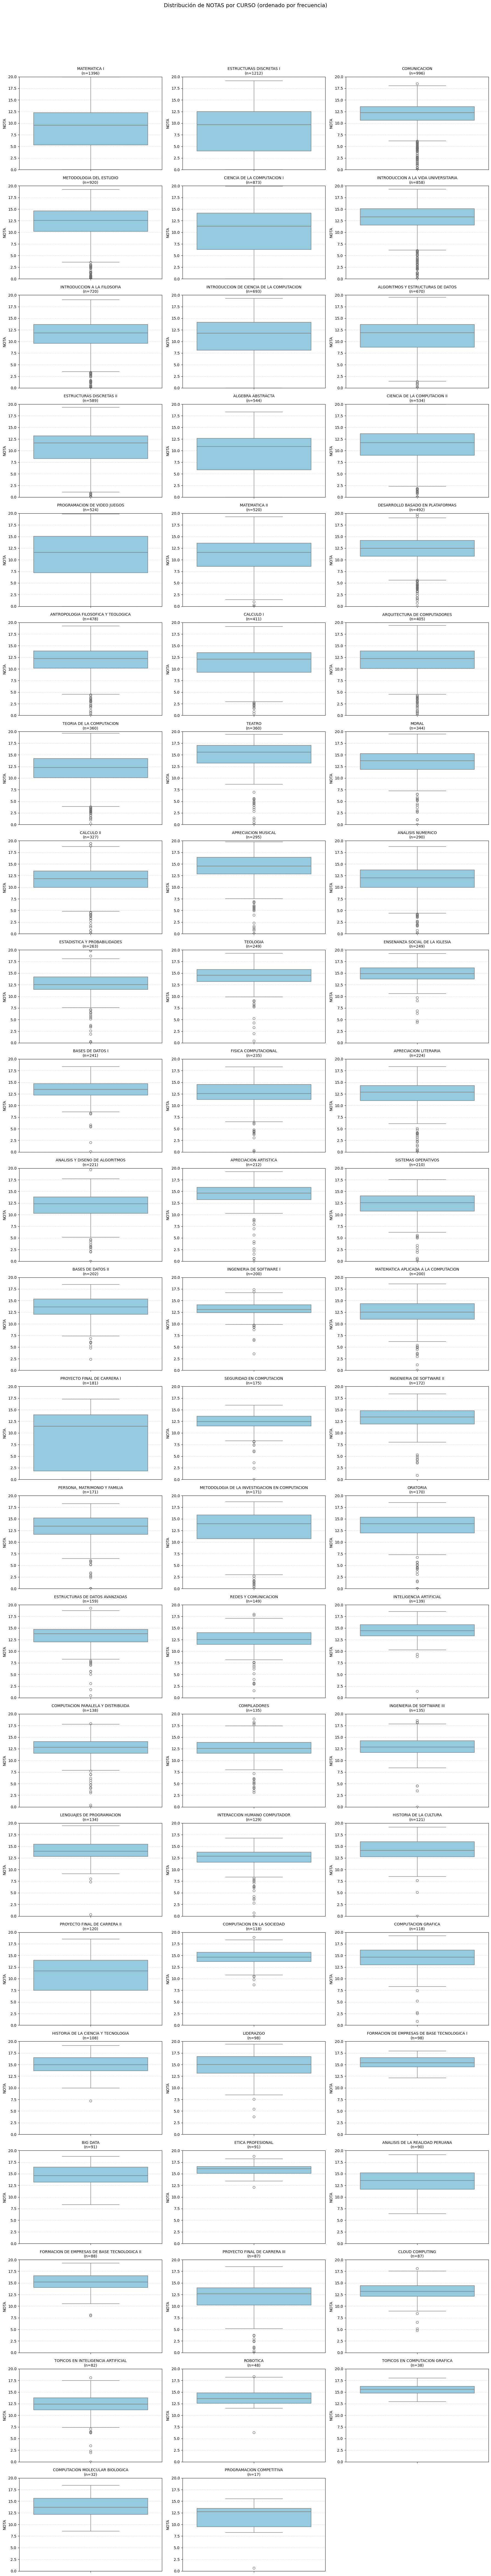

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 1️⃣ Contar frecuencia por curso correctamente
conteo_cursos = (
    df_clean['CURSO']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'CURSO', 'CURSO': 'FRECUENCIA'})
)

# A veces la columna se llama 'count' si el rename no aplica correctamente
if 'CURSO' not in conteo_cursos.columns:
    conteo_cursos.columns = ['CURSO', 'FRECUENCIA']

# ✅ 2️⃣ Obtener lista ordenada
cursos_ordenados = conteo_cursos['CURSO'].tolist()
n_cursos = len(cursos_ordenados)

# ✅ 3️⃣ Crear grilla (3 columnas)
n_cols = 3
n_rows = -(-n_cursos // n_cols)  # división entera hacia arriba

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# ✅ 4️⃣ Generar boxplot por curso
for i, curso in enumerate(cursos_ordenados):
    data_curso = df_clean[df_clean['CURSO'] == curso]
    sns.boxplot(ax=axes[i], data=data_curso, y='NOTA', color='skyblue')
    axes[i].set_title(f"{curso}\n(n={len(data_curso)})", fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("NOTA")
    axes[i].set_ylim(0, 20)  # eje Y fijo entre 0 y 20
    axes[i].grid(axis='y', linestyle='--', alpha=0.4)

# ✅ 5️⃣ Eliminar ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribución de NOTAS por CURSO (ordenado por frecuencia)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


### personas con solo un ciclo...

total de registros inicial: 21207
 cantidad de COD_PERSONA únicos: 936
Cantidad de COD_PERSONA con solo una PER_MATRICULA: 298
Cantidad de registros a eliminar: 1698


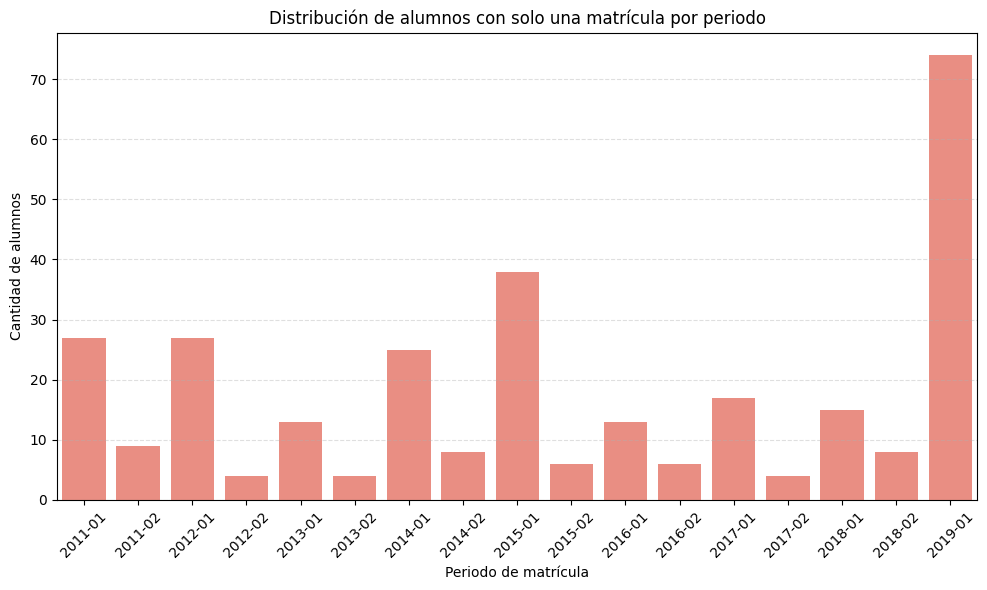

total de registros después de eliminar: 19509


In [110]:
print('total de registros inicial:', len(df_clean))
print(' cantidad de COD_PERSONA únicos:', df_clean['COD_PERSONA'].nunique())
# 1️⃣ Agrupar por persona y contar sus periodos únicos
matriculas_por_persona = df_clean.groupby('COD_PERSONA')['PER_MATRICULA'].nunique()

# 2️⃣ Filtrar los que solo tienen un periodo
personas_una_matricula = matriculas_por_persona[matriculas_por_persona == 1]
print("Cantidad de COD_PERSONA con solo una PER_MATRICULA:", len(personas_una_matricula))
print('Cantidad de registros a eliminar:', df_clean['COD_PERSONA'].isin(personas_una_matricula.index).sum())

# 3️⃣ Obtener los registros correspondientes antes de eliminarlos
eliminados = df_clean[df_clean['COD_PERSONA'].isin(personas_una_matricula.index)]
eliminados_para_el_barplot = df_clean[df_clean['COD_PERSONA'].isin(personas_una_matricula.index)][['COD_PERSONA','PER_MATRICULA']].drop_duplicates()
# 4️⃣ Visualizar a qué periodos pertenecen esos alumnos
plt.figure(figsize=(10,6))
sns.countplot(
    data=eliminados_para_el_barplot,
    x='PER_MATRICULA',
    order=sorted(eliminados_para_el_barplot['PER_MATRICULA'].unique()),
    color='salmon'
)
plt.title('Distribución de alumnos con solo una matrícula por periodo')
plt.xlabel('Periodo de matrícula')
plt.ylabel('Cantidad de alumnos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 5️⃣ Finalmente eliminar del dataframe principal
df_clean = df_clean[~df_clean['COD_PERSONA'].isin(personas_una_matricula.index)]

print('total de registros después de eliminar:', len(df_clean))

Columnas disponibles en 'eliminados':
['COD_PERSONA', 'SEXO', 'PER_INGRESO', 'ESTADO_CIVIL', 'TIPO_COLEGIO', 'PTJE_INGRESO', 'ESTADO', 'SEM_CURSADOS', 'CANT_RESERVAS', 'PER_MATRICULA', 'COD_CURSO', 'CURSO', 'CREDITOS', 'TIPO_CURSO', 'COD_PLAN', 'COD_GRUPO', 'GRUPO', 'NOTA', 'APROBO', 'HRS_INASISTENCIA', 'HRS_CURSO', 'PRCTJE_INASISTENCIA', 'PONDERADO', 'CRED_GRADUACION', 'BECA_VIGENTE', 'POBREZA_RES', 'POBREZA_PRO', 'FECHA_NACIMIENTO', 'TIPO_CICLO', 'CODIGO', 'SEM', 'NIVEL_CURSO', 'FAMILIA']

Cantidad de cursos únicos entre los eliminados: 25
                                       CURSO  CANTIDAD
0                               COMUNICACION       278
1       INTRODUCCION A LA VIDA UNIVERSITARIA       277
2                               MATEMATICA I       276
3                    METODOLOGIA DEL ESTUDIO       275
4                    ESTRUCTURAS DISCRETAS I       267
5                CIENCIA DE LA COMPUTACION I       138
6               PROGRAMACION DE VIDEO JUEGOS       134
7  INTRODUCC

/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_66129/1104492310.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


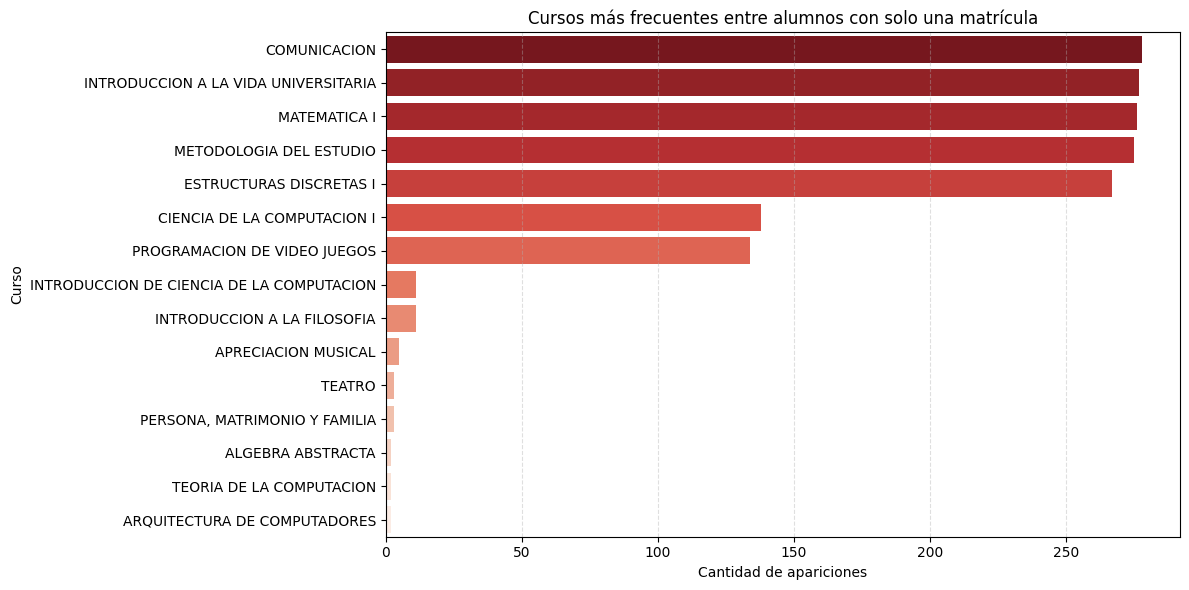

In [111]:
# Verificar las columnas reales en 'eliminados'
print("Columnas disponibles en 'eliminados':")
print(eliminados.columns.tolist())

# Si existe una columna con el nombre correcto (puede ser 'curso', 'Curso', etc.)
col_curso = None
for col in eliminados.columns:
    if col.strip().lower() == 'curso':
        col_curso = col
        break

if col_curso is None:
    raise KeyError("❌ No se encontró ninguna columna llamada 'CURSO' (ni variantes como 'curso' o 'Curso').")

# 1️⃣ Contar cuántas veces aparece cada curso
top_cursos = (
    eliminados[col_curso]
    .value_counts()
    .reset_index()
)

# Renombrar las columnas de forma genérica (sin depender de los nombres exactos)
top_cursos.columns = ['CURSO', 'CANTIDAD']

# 2️⃣ Mostrar resumen
print(f"\nCantidad de cursos únicos entre los eliminados: {top_cursos['CURSO'].nunique()}")
print(top_cursos.head(10))

# 3️⃣ Graficar los cursos más frecuentes
plt.figure(figsize=(12,6))
sns.barplot(
    data=top_cursos.head(15),
    x='CANTIDAD',
    y='CURSO',
    palette='Reds_r'
)
plt.title('Cursos más frecuentes entre alumnos con solo una matrícula')
plt.xlabel('Cantidad de apariciones')
plt.ylabel('Curso')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Se analiza nota por ciclos

In [112]:
# Generar Promedio Ponderado por Alumno (por ciclo)
# primerio debe agrupar por COD_PERSONA y PER_MATRICULA
df_clean['PROMEDIO_PONDERADO'] = (
    df_clean.groupby(['COD_PERSONA', 'PER_MATRICULA'])
    .apply(lambda g: np.sum(g['NOTA'] * g['CREDITOS']) / np.sum(g['CREDITOS']))
    .reindex(df_clean.set_index(['COD_PERSONA', 'PER_MATRICULA']).index)
    .values
)


/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_66129/1714555611.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.sum(g['NOTA'] * g['CREDITOS']) / np.sum(g['CREDITOS']))


Summary de PROMEDIO_PONDERADO:
count    19509.000000
mean        11.713124
std          3.115347
min          0.000000
25%          9.980000
50%         12.137000
75%         13.850000
max         19.490000
Name: PROMEDIO_PONDERADO, dtype: float64


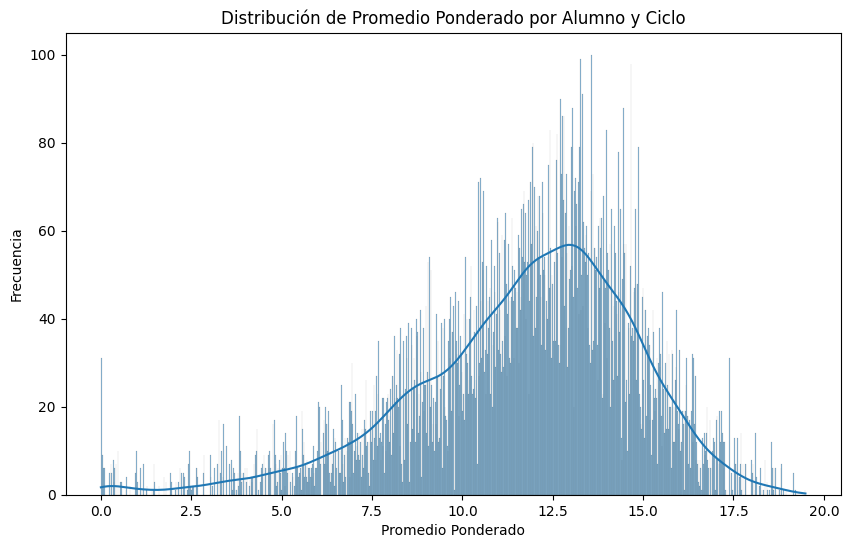

In [113]:
# frecuencia de PROMEDIO_PONDERADO agrupado por alumno y per_matricula
print("Summary de PROMEDIO_PONDERADO:")
print(df_clean['PROMEDIO_PONDERADO'].describe())

# distribución de PROMEDIO_PONDERADO
plt.figure(figsize=(10,6))
sns.histplot(df_clean['PROMEDIO_PONDERADO'], bins=1000, kde=True)
plt.title('Distribución de Promedio Ponderado por Alumno y Ciclo')
plt.xlabel('Promedio Ponderado')
plt.ylabel('Frecuencia')
plt.show()

hablando de promedio es demasiado raro que se logre tener promedio 0, y promedio 20,  sin embargo el promedio 0, genera una leve elavacion a la distribucion natural, sin embargo esta es una distribucion por registros y no por ciclos, teniendo en cuenta que el promedio ponderado es por ciclo, mejor se hara una distribucion en funcion de ella, y si sigue asi se tomara la desicion de eliminar

estos casos probablemente es un alumno que ya tenia planeado abandonar la U y no hizo minimo esfuerzo por cumplir las expetativas academicas, por lo tanto al ser un caso anormal(EL CUAL NO BUSCAMOS PREDECIR) se prodecedera eliminar en caso se mantenda en la distribucion por la agrupacion de cod_alumno y per_matricula

In [114]:
# cantidad de registros en df_clean con PROMEDIO_PONDERADO <0.1
limit = 2.5
registros_bajo = df_clean[df_clean['PROMEDIO_PONDERADO'] < limit]
print(f"Registros en df_clean con PROMEDIO_PONDERADO < {limit}: {len(registros_bajo)}")

# cuantos de ellos son en el ultimo ciclo academico del estudiante
ultimo_ciclo = df_clean.groupby('COD_PERSONA')['PER_MATRICULA'].max().reset_index()
registros_ultimo_ciclo = registros_bajo.merge(ultimo_ciclo, on=['COD_PERSONA', 'PER_MATRICULA'])
print(f"Registros en df_clean con PROMEDIO_PONDERADO < {limit} en el último ciclo académico: {len(registros_ultimo_ciclo)}")


registros_bajo['NOTA'].describe()

Registros en df_clean con PROMEDIO_PONDERADO < 2.5: 231
Registros en df_clean con PROMEDIO_PONDERADO < 2.5 en el último ciclo académico: 141


count    231.000000
mean       0.997229
std        1.503963
min        0.000000
25%        0.000000
50%        0.260000
75%        1.405000
max        7.370000
Name: NOTA, dtype: float64

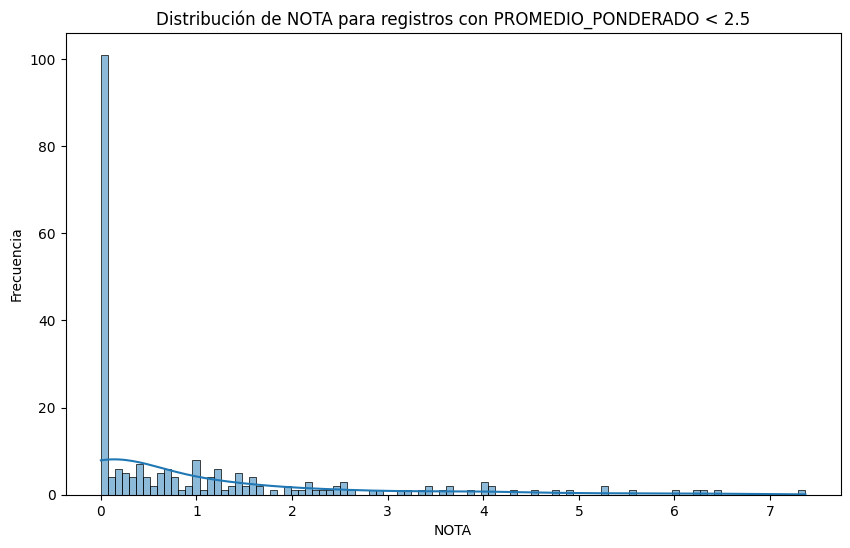

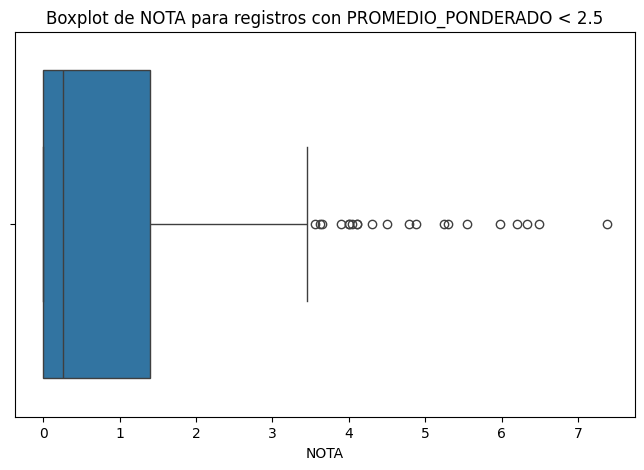

In [115]:

# barplot de NOTA de registros_bajo
plt.figure(figsize=(10,6))
sns.histplot(registros_bajo['NOTA'], bins=100, kde=True)
plt.title(f'Distribución de NOTA para registros con PROMEDIO_PONDERADO < {limit}')
plt.xlabel('NOTA')
plt.ylabel('Frecuencia')
plt.show()

# boxplot de NOTA de registros_bajo
plt.figure(figsize=(8,5))
sns.boxplot(x=registros_bajo['NOTA'])
plt.title(f'Boxplot de NOTA para registros con PROMEDIO_PONDERADO < {limit}')
plt.xlabel('NOTA')
plt.show()

  COD_PERSONA PER_MATRICULA  PROMEDIO_PONDERADO
0       10275       2014-02           13.563500
1       10275       2015-01           13.099375
2       10275       2015-02           13.400000
3       10460       2011-02           15.635000
4       10460       2012-01            9.048750


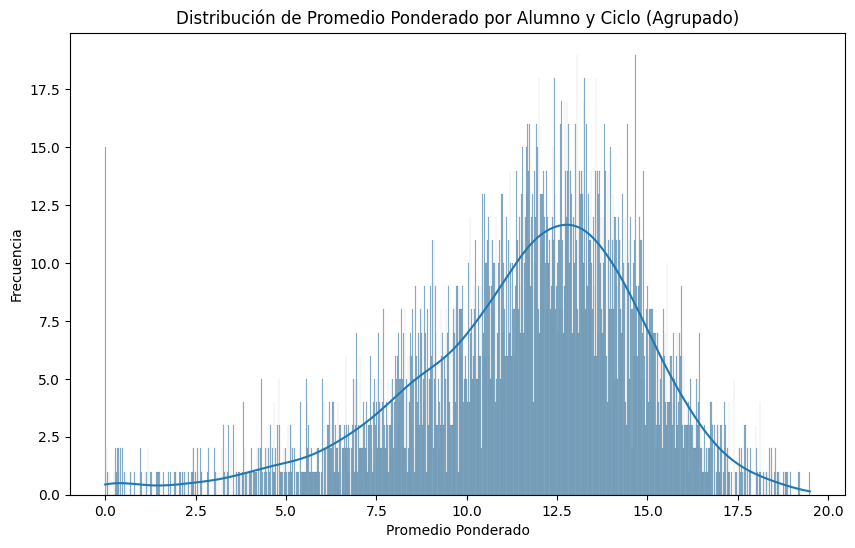

In [116]:
grupo_por_periodo = (
    df_clean.groupby(['COD_PERSONA', 'PER_MATRICULA'], as_index=False)
    .agg({'PROMEDIO_PONDERADO': 'first'}) 
) 
print(grupo_por_periodo.head())

# distribucion de PROMEDIO_PONDERADO 

plt.figure(figsize=(10,6))
sns.histplot(grupo_por_periodo['PROMEDIO_PONDERADO'], bins=1000, kde=True)
plt.title('Distribución de Promedio Ponderado por Alumno y Ciclo (Agrupado)')
plt.xlabel('Promedio Ponderado')
plt.ylabel('Frecuencia')
plt.show()




In [117]:
# cantidad de agrupaciones únicas de COD_PERSONA y PER_MATRICULA con PROMEDIO_PONDERADO < 0.01
limit = 2.5
agrupaciones_bajo = grupo_por_periodo[grupo_por_periodo['PROMEDIO_PONDERADO'] < limit]
print(f"Agrupaciones únicas con PROMEDIO_PONDERADO < {limit}: {len(agrupaciones_bajo)}")

# cuantos de esos fenomenos ocurren en el ultimo ciclo academico del estudiante
ultimo_ciclo_agrupado = grupo_por_periodo.groupby('COD_PERSONA')['PER_MATRICULA'].max().reset_index()
agrupaciones_ultimo_ciclo = agrupaciones_bajo.merge(ultimo_ciclo_agrupado, on=['COD_PERSONA', 'PER_MATRICULA'])
print(f"Agrupaciones únicas con PROMEDIO_PONDERADO < {limit} en el último ciclo académico: {len(agrupaciones_ultimo_ciclo)}")

agrupaciones_ultimo_ciclo.info()
# cuantos registros serian en df_clean
print(f"Registros en df_clean correspondientes a esas agrupaciones únicas: {len(df_clean.merge(agrupaciones_ultimo_ciclo, on=['COD_PERSONA', 'PER_MATRICULA']))}")



Agrupaciones únicas con PROMEDIO_PONDERADO < 2.5: 72
Agrupaciones únicas con PROMEDIO_PONDERADO < 2.5 en el último ciclo académico: 39
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   COD_PERSONA         39 non-null     object 
 1   PER_MATRICULA       39 non-null     object 
 2   PROMEDIO_PONDERADO  39 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.0+ KB
Registros en df_clean correspondientes a esas agrupaciones únicas: 141


In [118]:
print('total de registros:', len(df_clean))
agrupaciones_ultimo_ciclo = agrupaciones_ultimo_ciclo.drop(columns=['PROMEDIO_PONDERADO'], errors='ignore')
df_clean = df_clean.merge(agrupaciones_ultimo_ciclo, on=['COD_PERSONA', 'PER_MATRICULA'], how='left', indicator=True)
df_clean = df_clean[df_clean['_merge'] == 'left_only']
df_clean = df_clean.drop(columns=['_merge'])

print('total de registros:', len(df_clean))



total de registros: 19509
total de registros: 19368


  COD_PERSONA PER_MATRICULA  PROMEDIO_PONDERADO
0       10275       2014-02           13.563500
1       10275       2015-01           13.099375
2       10275       2015-02           13.400000
3       10460       2011-02           15.635000
4       10460       2012-01            9.048750


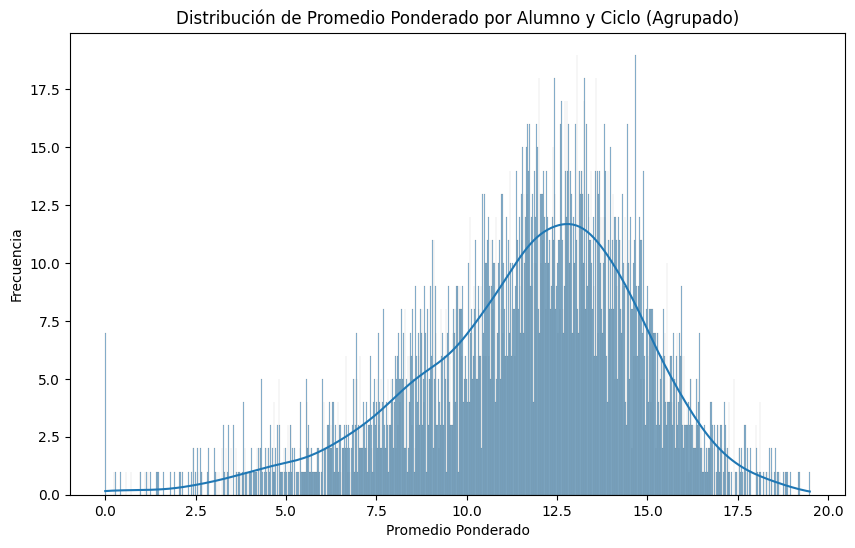

In [119]:
grupo_por_periodo = (
    df_clean.groupby(['COD_PERSONA', 'PER_MATRICULA'], as_index=False)
    .agg({'PROMEDIO_PONDERADO': 'first'}) 
) 
print(grupo_por_periodo.head())

# distribucion de PROMEDIO_PONDERADO 

plt.figure(figsize=(10,6))
sns.histplot(grupo_por_periodo['PROMEDIO_PONDERADO'], bins=1000, kde=True)
plt.title('Distribución de Promedio Ponderado por Alumno y Ciclo (Agrupado)')
plt.xlabel('Promedio Ponderado')
plt.ylabel('Frecuencia')
plt.show()




  COD_PERSONA PER_MATRICULA  PROMEDIO_PONDERADO
0       10275       2014-02           13.563500
1       10275       2015-01           13.099375
2       10275       2015-02           13.400000
3       10460       2011-02           15.635000
4       10460       2012-01            9.048750


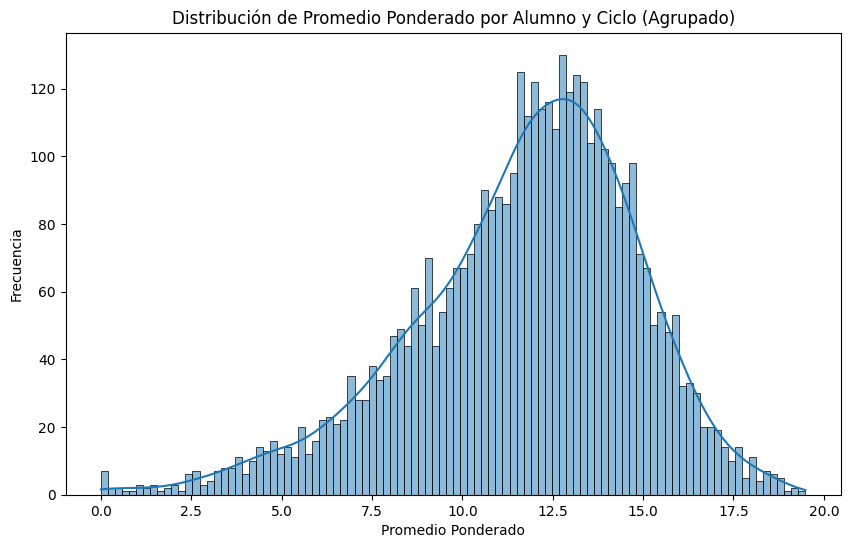

In [120]:
grupo_por_periodo = (
    df_clean.groupby(['COD_PERSONA', 'PER_MATRICULA'], as_index=False)
    .agg({'PROMEDIO_PONDERADO': 'first'}) 
) 
print(grupo_por_periodo.head())

# distribucion de PROMEDIO_PONDERADO 

plt.figure(figsize=(10,6))
sns.histplot(grupo_por_periodo['PROMEDIO_PONDERADO'], bins=100, kde=True)
plt.title('Distribución de Promedio Ponderado por Alumno y Ciclo (Agrupado)')
plt.xlabel('Promedio Ponderado')
plt.ylabel('Frecuencia')
plt.show()




1. seguimos viendo cierta elevacion en 0, pero nada que nos motive a eliminar, sigue todavia la tendencia de la distribución
2. ya que terminamos de ver los ponderados por ciclo, dejamos ese apartado y vemos la distribucion de NOTA

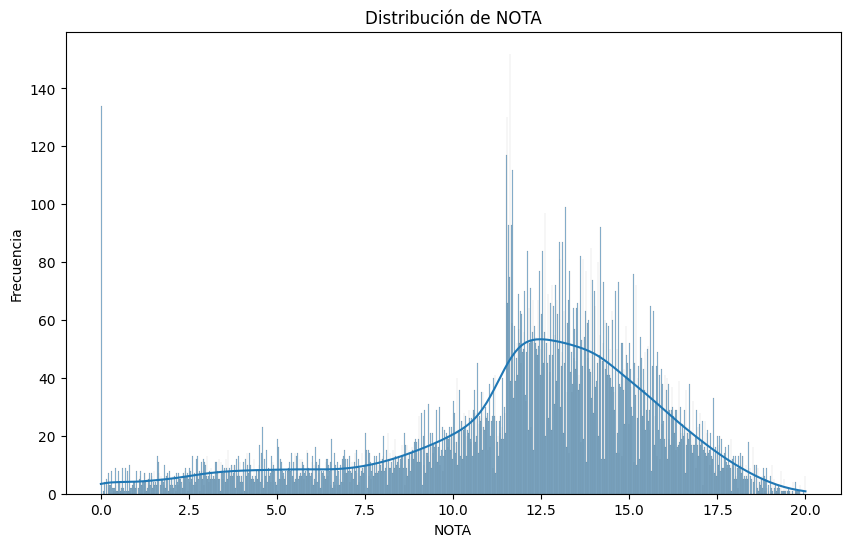

In [121]:
plt.figure(figsize=(10,6))
sns.histplot(df_clean['NOTA'], bins=1000, kde=True)
plt.title('Distribución de NOTA')
plt.xlabel('NOTA')
plt.ylabel('Frecuencia')
plt.show()

Total de registros: 19368
Cantidad total de registros con NOTA == 0: 134
Cursos con alumnos que obtuvieron 0 en la nota:
                                             CURSO  count
0                      PROYECTO FINAL DE CARRERA I     11
1                     PROYECTO FINAL DE CARRERA II     10
2                                     COMUNICACION     10
3                ALGORITMOS Y ESTRUCTURAS DE DATOS      9
4                                     MATEMATICA I      7
5                                         ORATORIA      6
6                      INTRODUCCION A LA FILOSOFIA      6
7                      CIENCIA DE LA COMPUTACION I      5
8        INTRODUCCION DE CIENCIA DE LA COMPUTACION      5
9                            APRECIACION LITERARIA      5
10  METODOLOGIA DE LA INVESTIGACION EN COMPUTACION      5
11                         ESTRUCTURAS DISCRETAS I      5
12                             APRECIACION MUSICAL      4
13                               ALGEBRA ABSTRACTA      4
14       

/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_66129/732367270.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


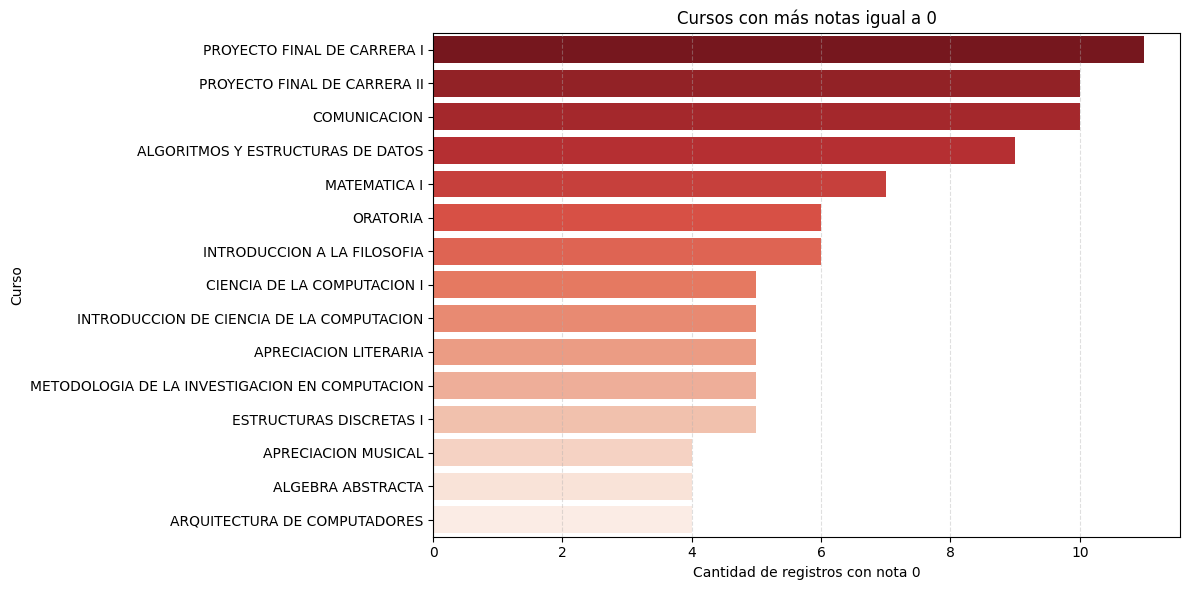

In [122]:
print("Total de registros:", df_clean.shape[0])

# 1️⃣ Filtrar solo los registros con nota 0
cursos_con_nota_cero = df_clean[df_clean['NOTA'] == 0]

# 2️⃣ Contar cuántas veces aparece cada curso con nota 0
conteo_cursos_nota_cero = (
    cursos_con_nota_cero['CURSO']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'CURSO', 'CURSO': 'CURSO'})
)

# 3️⃣ Mostrar resumen
print(f"Cantidad total de registros con NOTA == 0: {cursos_con_nota_cero.shape[0]}")
print("Cursos con alumnos que obtuvieron 0 en la nota:")
print(conteo_cursos_nota_cero.head(15))  # puedes ajustar el número

# 4️⃣ Visualización
plt.figure(figsize=(12,6))
sns.barplot(
    data=conteo_cursos_nota_cero.head(15),  # top 15
    x='count',
    y='CURSO',
    palette='Reds_r'
)
plt.title('Cursos con más notas igual a 0')
plt.xlabel('Cantidad de registros con nota 0')
plt.ylabel('Curso')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [123]:
print("total de registros:", df_clean.shape[0])
# cantidad de registros con nota == 0
cantidad_nota_cero = df_clean[df_clean['NOTA'] == 0].shape[0]
print("Cantidad de registros con NOTA == 0:", cantidad_nota_cero)
print("Porcentaje de registros con NOTA == 0: {:.2f}%".format((cantidad_nota_cero / df_clean.shape[0]) * 100))

total de registros: 19368
Cantidad de registros con NOTA == 0: 134
Porcentaje de registros con NOTA == 0: 0.69%


1. Muchas notas en 0 frente a las demas notas, es un fenomeno extremadamente inusual, la idea es predecir la nota de un estudiante, esos registros terminan siendo solo ruido, en caso quisieramos.
2. existe una perturbavion alrededor de la nota 11.5(casualmente el limite de aprobacion); la distribucion claramente sigue un tendencia, pero tal fenomeno no debe ser casualidad, se visualizara si justamente es con 11.5 o es en otro punto

In [124]:
# eliminar registros con NOTA == 0
df_clean = df_clean[df_clean['NOTA'] > 0]
print("total de registros:", df_clean.shape[0])

total de registros: 19234


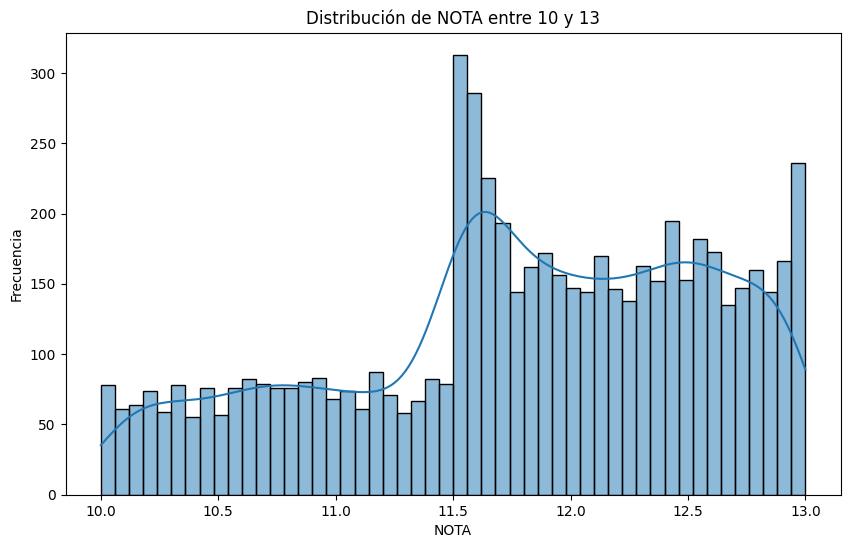

In [125]:
# ver districucion de las notes entre 10 y 13
plt.figure(figsize=(10,6))
sns.histplot(df_clean[(df_clean['NOTA'] >= 10) & (df_clean['NOTA'] <= 13)]['NOTA'], bins=50, kde=True)
plt.title('Distribución de NOTA entre 10 y 13')
plt.xlabel('NOTA')
plt.ylabel('Frecuencia')
plt.show()

en efecto... pareceria que los docentes les da 'pena' jalarlos, cuando estan tan cerca a la nota y decide darle los 'puntitos' que lefalta para que pasen a las justas, ciertamente ello genera ruido, esperemos que no el suficiente, ya que eliminar mas seria perfudicial

  COD_PERSONA PER_MATRICULA  PROMEDIO_PONDERADO
0       10275       2014-02           13.563500
1       10275       2015-01           13.099375
2       10275       2015-02           13.400000
3       10460       2011-02           15.635000
4       10460       2012-01            9.048750


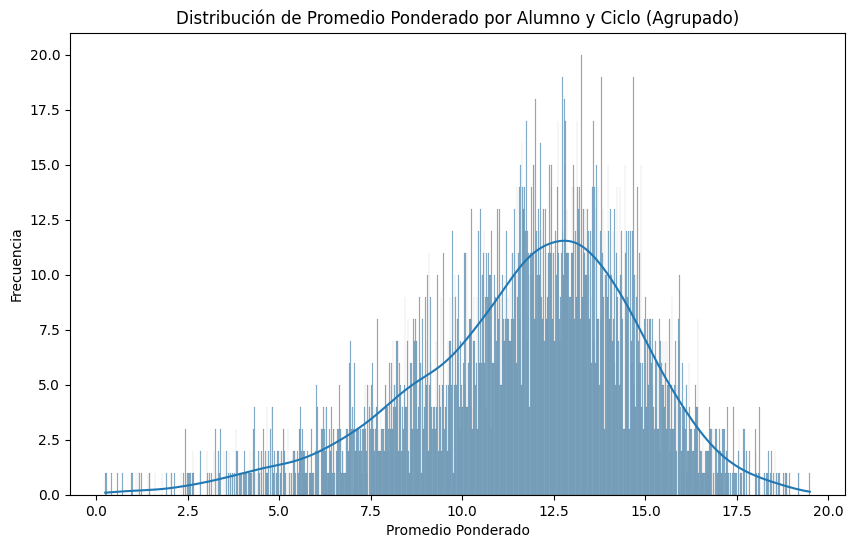

total de registros: 19234


In [126]:
grupo_por_periodo = (
    df_clean.groupby(['COD_PERSONA', 'PER_MATRICULA'], as_index=False)
    .agg({'PROMEDIO_PONDERADO': 'first'}) 
) 
print(grupo_por_periodo.head())

# distribucion de PROMEDIO_PONDERADO 

plt.figure(figsize=(10,6))
sns.histplot(grupo_por_periodo['PROMEDIO_PONDERADO'], bins=1000, kde=True)
plt.title('Distribución de Promedio Ponderado por Alumno y Ciclo (Agrupado)')
plt.xlabel('Promedio Ponderado')
plt.ylabel('Frecuencia')
plt.show()


print("total de registros:", df_clean.shape[0])

aparentemente las notas y el promedio siguen la distribucion despues de eliminar las notas == 0 :D

In [127]:
df_clean['PROMEDIO_PONDERADO'] = (
    df_clean.groupby(['COD_PERSONA', 'PER_MATRICULA'])
    .apply(lambda g: np.sum(g['NOTA'] * g['CREDITOS']) / np.sum(g['CREDITOS']))
    .reindex(df_clean.set_index(['COD_PERSONA', 'PER_MATRICULA']).index)
    .values
)
print("total de registros:", df_clean.shape[0])

total de registros: 19234


/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_66129/3551129449.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.sum(g['NOTA'] * g['CREDITOS']) / np.sum(g['CREDITOS']))


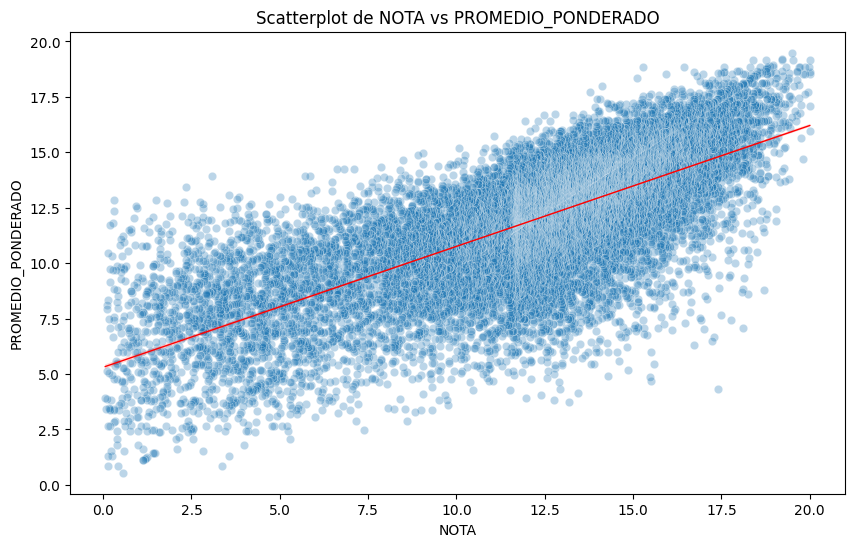

In [128]:
# scatterplot de NOTA vs PROMEDIO_PONDERADO
plt.figure(figsize=(10,6))
sns.scatterplot(x='NOTA', y='PROMEDIO_PONDERADO', data=df_clean, alpha=0.3)
sns.regplot(x='NOTA', y='PROMEDIO_PONDERADO', data=df_clean, scatter=False, color='red', line_kws={'linewidth':1})
plt.title('Scatterplot de NOTA vs PROMEDIO_PONDERADO')
plt.xlabel('NOTA')
plt.ylabel('PROMEDIO_PONDERADO')
plt.show()

In [129]:
df_periodos = (
    df_clean.groupby(['COD_PERSONA', 'PER_MATRICULA'], as_index=False)
    .agg({'PROMEDIO_PONDERADO': 'first'})
)
df_periodos = df_periodos.sort_values(['COD_PERSONA', 'PER_MATRICULA'])
df_periodos['PROMEDIO_PONDERADO_CP'] = (
    df_periodos.groupby('COD_PERSONA')['PROMEDIO_PONDERADO'].shift(1)
)
df_clean = df_clean.merge(df_periodos[['COD_PERSONA', 'PER_MATRICULA', 'PROMEDIO_PONDERADO_CP']],
                          on=['COD_PERSONA', 'PER_MATRICULA'], how='left')

print("total de registros:", df_clean.shape[0])

total de registros: 19234


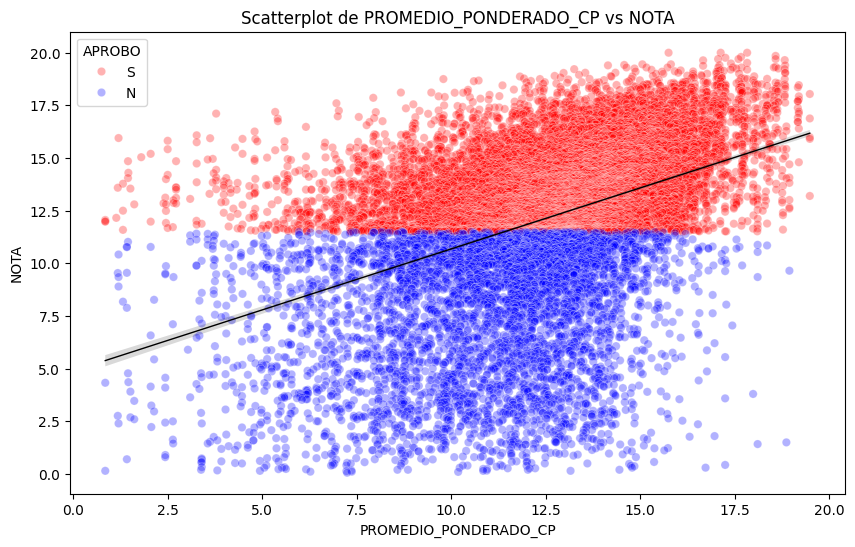

In [130]:
# scatterplot de PROMEDIO_PONDERADO_CP vs NOTA # añadir color de 'APROBO' segun si NOTA >= 11.5
plt.figure(figsize=(10,6))
sns.scatterplot(x='PROMEDIO_PONDERADO_CP', y='NOTA', data=df_clean, alpha=0.3, hue='APROBO', palette={'S': 'red', 'N': 'blue'})
sns.regplot(x='PROMEDIO_PONDERADO_CP', y='NOTA', data=df_clean, scatter=False, color='black', line_kws={'linewidth':1})
plt.title('Scatterplot de PROMEDIO_PONDERADO_CP vs NOTA')
plt.xlabel('PROMEDIO_PONDERADO_CP')
plt.ylabel('NOTA')
plt.show()

### Hrs_curso

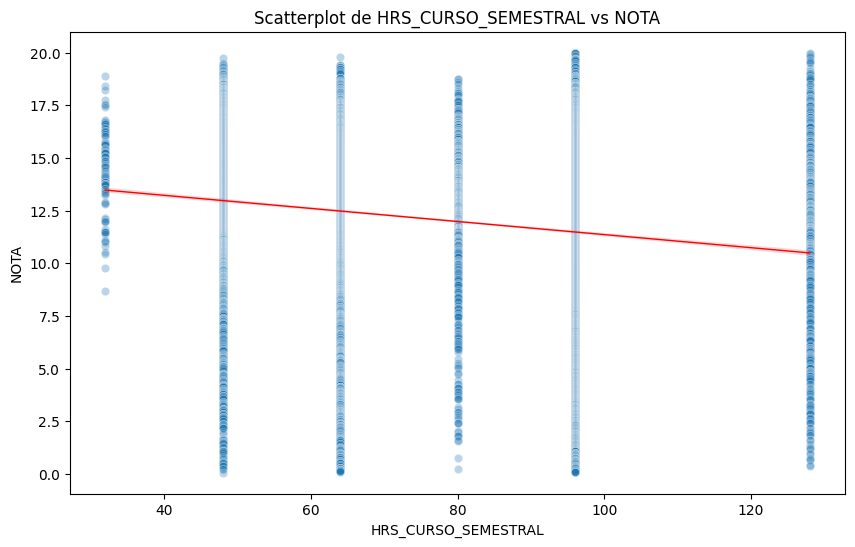

In [131]:
# generar HRS_CURSO_SEMESTRAL
df_clean['HRS_CURSO_SEMESTRAL'] = df_clean['HRS_CURSO'] * 16

# scatterplot de HRS_CURSO_SEMESTRAL vs NOTA
plt.figure(figsize=(10,6))
sns.scatterplot(x='HRS_CURSO_SEMESTRAL', y='NOTA', data=df_clean, alpha=0.3)
sns.regplot(x='HRS_CURSO_SEMESTRAL', y='NOTA', data=df_clean, scatter=False, color='red', line_kws={'linewidth':1})
plt.title('Scatterplot de HRS_CURSO_SEMESTRAL vs NOTA')
plt.xlabel('HRS_CURSO_SEMESTRAL')
plt.ylabel('NOTA')
plt.show()

### PRCTJE_INASISTENCIA

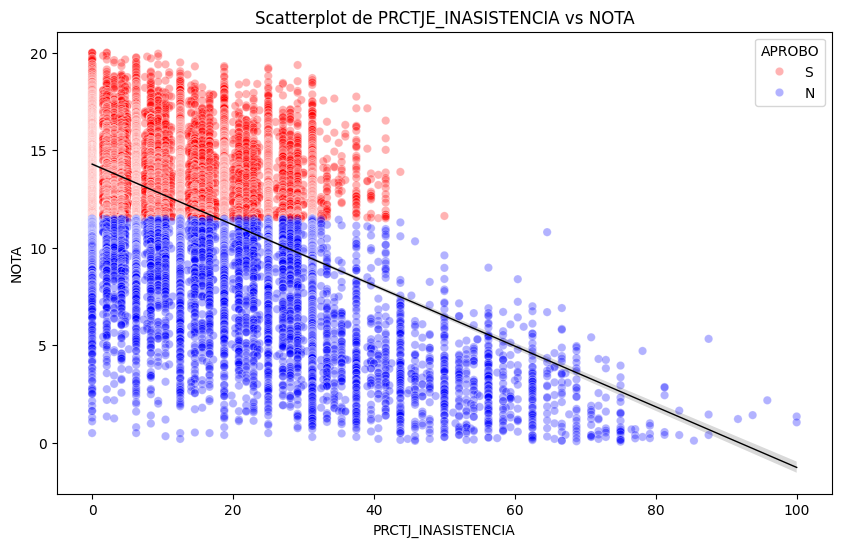

In [132]:
df_clean['PRCTJE_INASISTENCIA'] = df_clean['HRS_INASISTENCIA'] / df_clean['HRS_CURSO_SEMESTRAL'] * 100
# scatterplot de PRCTJE_INASISTENCIA vs NOTA
plt.figure(figsize=(10,6))
sns.scatterplot(x='PRCTJE_INASISTENCIA', y='NOTA', data=df_clean,alpha=0.3, hue='APROBO', palette={'S': 'red', 'N': 'blue'})
sns.regplot(x='PRCTJE_INASISTENCIA', y='NOTA', data=df_clean, scatter=False, color='black', line_kws={'linewidth':1})
plt.title('Scatterplot de PRCTJE_INASISTENCIA vs NOTA')
plt.xlabel('PRCTJ_INASISTENCIA')
plt.ylabel('NOTA')
plt.show()


### PRCTJ_INASISTENCIA_GLOBAL (hasta el ciclo pasado del registro)

In [133]:
cols = ['COD_PERSONA', 'PER_MATRICULA', 'HRS_INASISTENCIA', 'HRS_CURSO_SEMESTRAL']
df_aux = df_clean[cols].copy()

# --- Ordenar por persona y ciclo ---
df_aux = df_aux.sort_values(['COD_PERSONA', 'PER_MATRICULA'])

# --- Calcular sumas acumuladas por alumno ---
df_aux['SUM_INASISTENCIA_ACUM'] = (
    df_aux.groupby('COD_PERSONA')['HRS_INASISTENCIA'].cumsum().shift(1)
)
df_aux['SUM_HRS_TOTALES_ACUM'] = (
    df_aux.groupby('COD_PERSONA')['HRS_CURSO_SEMESTRAL'].cumsum().shift(1)
)

# --- Calcular porcentaje acumulado hasta el ciclo anterior ---
df_aux['PRCTJ_INASISTENCIA_GLOBAL'] = (
    df_aux['SUM_INASISTENCIA_ACUM'] / df_aux['SUM_HRS_TOTALES_ACUM'] * 100
)

# --- Asegurar una fila única por persona y periodo ---
df_aux_final = df_aux.drop_duplicates(subset=['COD_PERSONA', 'PER_MATRICULA'])

# --- Hacer el merge limpio ---
df_clean = df_clean.merge(
    df_aux_final[['COD_PERSONA', 'PER_MATRICULA', 'PRCTJ_INASISTENCIA_GLOBAL']],
    on=['COD_PERSONA', 'PER_MATRICULA'],
    how='left'
)

print("total de registros:", df_clean.shape[0])

total de registros: 19234


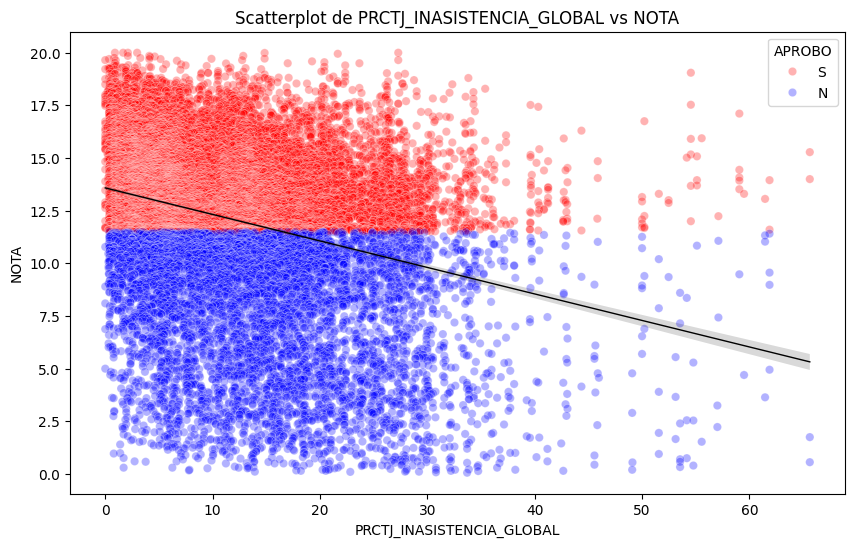

In [134]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='PRCTJ_INASISTENCIA_GLOBAL', y='NOTA', data=df_clean,alpha=0.3, hue='APROBO', palette={'S': 'red', 'N': 'blue'})
sns.regplot(x='PRCTJ_INASISTENCIA_GLOBAL', y='NOTA', data=df_clean, scatter=False, color='black', line_kws={'linewidth':1})
plt.title('Scatterplot de PRCTJ_INASISTENCIA_GLOBAL vs NOTA')
plt.xlabel('PRCTJ_INASISTENCIA_GLOBAL')
plt.ylabel('NOTA')
plt.show()


### PNTJ_INGRESO

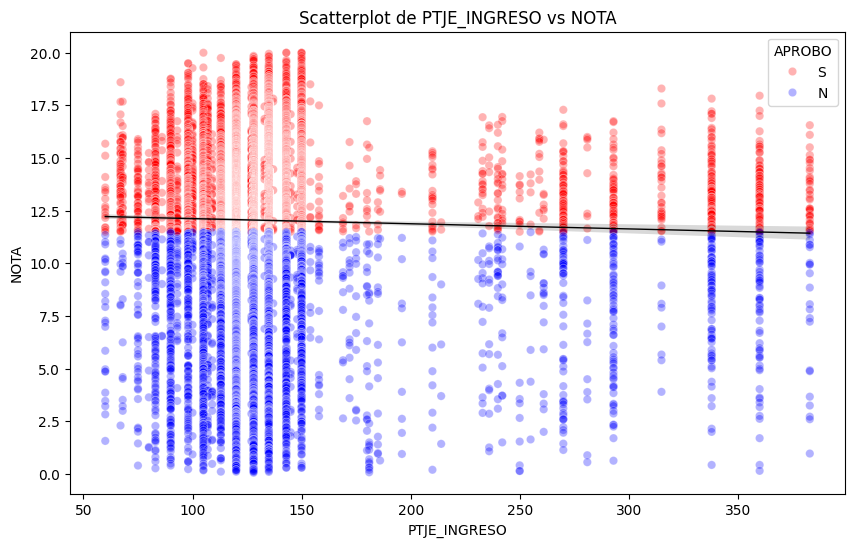

In [135]:
# scatterplot de PTJE_INGRESO vs NOTA
plt.figure(figsize=(10,6))
sns.scatterplot(x='PTJE_INGRESO', y='NOTA', data=df_clean, alpha=0.3, hue='APROBO', palette={'S': 'red', 'N': 'blue'})
sns.regplot(x='PTJE_INGRESO', y='NOTA', data=df_clean, scatter=False, color='black', line_kws={'linewidth':1})
plt.title('Scatterplot de PTJE_INGRESO vs NOTA')
plt.xlabel('PTJE_INGRESO')
plt.ylabel('NOTA')
plt.show()

Es muy lijera su ayuda

### PER_INGRESO

/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_66129/1868706187.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PER_INGRESO', y='NOTA', data=df_clean, order=orden_periodos, palette='pastel')


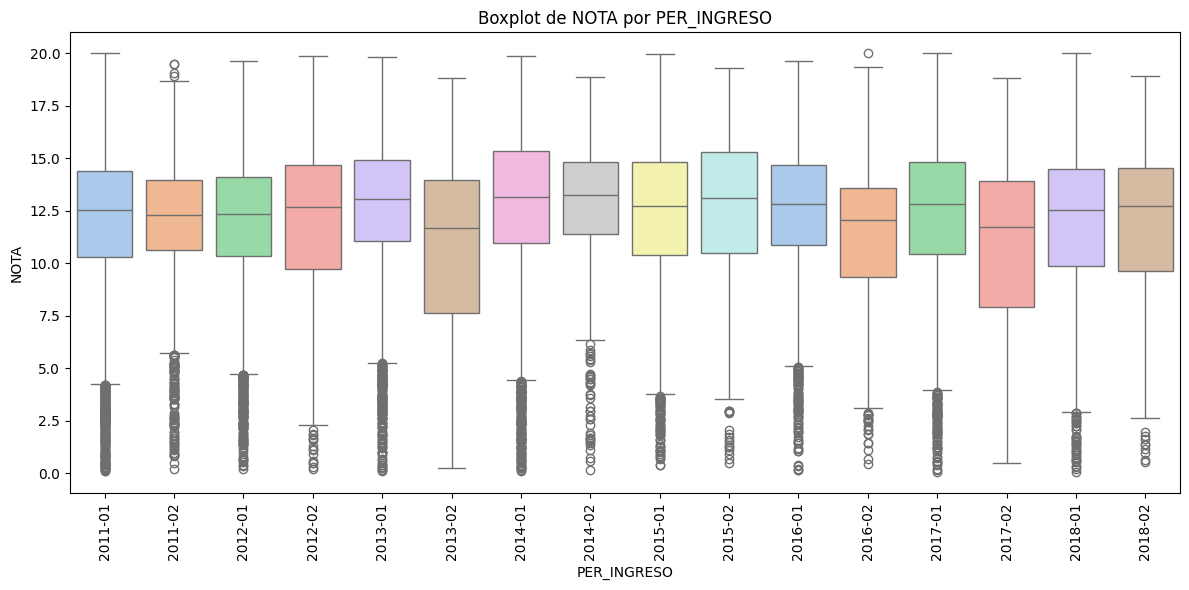

In [136]:
orden_periodos = sorted(df_clean['PER_INGRESO'].unique())

plt.figure(figsize=(12, 6))
sns.boxplot(x='PER_INGRESO', y='NOTA', data=df_clean, order=orden_periodos, palette='pastel')

plt.title('Boxplot de NOTA por PER_INGRESO')
plt.xlabel('PER_INGRESO')
plt.ylabel('NOTA')

# 🔹 Rotar etiquetas del eje X para mejor lectura
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Analizamos diferencias entre ingresantes de ciclos terminados en "-01" y "-02"

/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_66129/567105433.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TIPO_PERIODO', y='NOTA', data=df_violin, palette='pastel')


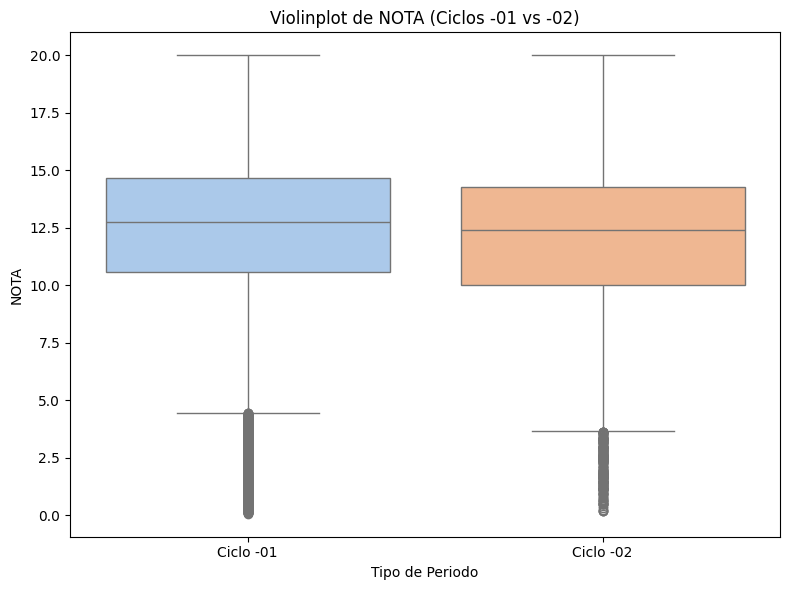

Estadísticas de NOTA para Ciclos de Ingreso -01 y -02:
              Promedio (Media)  Mediana
TIPO_PERIODO                           
Ciclo -01            12.124647    12.77
Ciclo -02            11.726180    12.41


In [137]:
df_plot = df_clean.copy()

# 2. Aseguramos que PER_INGRESO sea de tipo string 
#    para poder usar la función .str.endswith()
df_plot['PER_INGRESO_STR'] = df_plot['PER_INGRESO'].astype(str)

# 3. Creamos la nueva columna 'TIPO_PERIODO'
#    Usamos np.where anidado para asignar la categoría
df_plot['TIPO_PERIODO'] = np.where(
    df_plot['PER_INGRESO_STR'].str.endswith('-01'),  # Condición 1
    'Ciclo -01',                                    # Valor si Condición 1 es Verdadera
    np.where(
        df_plot['PER_INGRESO_STR'].str.endswith('-02'), # Condición 2
        'Ciclo -02',                                    # Valor si Condición 2 es Verdadera
        'Otro'                                          # Valor si ambas son Falsas
    )
)

# 4. Filtramos el DataFrame para quedarnos solo con los dos grupos de interés
#    (Excluimos los valores 'Otro', si es que existen)
df_violin = df_plot[df_plot['TIPO_PERIODO'].isin(['Ciclo -01', 'Ciclo -02'])]

# 5. Creamos el Violinplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='TIPO_PERIODO', y='NOTA', data=df_violin, palette='pastel')

plt.title('Violinplot de NOTA (Ciclos -01 vs -02)')
plt.xlabel('Tipo de Periodo')
plt.ylabel('NOTA')
plt.tight_layout()
plt.show()


estadisticas_ingreso = df_violin.groupby('TIPO_PERIODO')['NOTA'].agg(['mean', 'median'])

# 4. (Opcional) Renombramos las columnas para mayor claridad
estadisticas_ingreso.columns = ['Promedio (Media)', 'Mediana']

# 5. Imprimimos el resultado
print("Estadísticas de NOTA para Ciclos de Ingreso -01 y -02:")
print(estadisticas_ingreso)

In [138]:
import scipy.stats as stats

df_test = df_clean.copy()

# Aseguramos que PER_INGRESO sea string
df_test['PER_INGRESO_STR'] = df_test['PER_INGRESO'].astype(str)

# Creamos la columna 'TIPO_PERIODO'
df_test['TIPO_PERIODO'] = np.where(
    df_test['PER_INGRESO_STR'].str.endswith('-01'), 'Ciclo -01',
    np.where(
        df_test['PER_INGRESO_STR'].str.endswith('-02'), 'Ciclo -02', 
        'Otro'
    )
)

# Filtramos solo los dos grupos de interés
df_filtered = df_test[df_test['TIPO_PERIODO'].isin(['Ciclo -01', 'Ciclo -02'])]

# Creamos dos series separadas con las notas de cada grupo
notas_01 = df_filtered[df_filtered['TIPO_PERIODO'] == 'Ciclo -01']['NOTA']
notas_02 = df_filtered[df_filtered['TIPO_PERIODO'] == 'Ciclo -02']['NOTA']

# --- 2. Ejecutar las Pruebas de Significación ---

print("Resultados de las Pruebas de Significación:")
print("-" * 40)

# --- Prueba T (T-test) para comparar medias ---
# Usamos equal_var=False (Test de Welch), que es más seguro
# y no asume que las varianzas de los dos grupos son iguales.
# Usamos nan_policy='omit' para ignorar valores NaN.
t_stat, p_value_t = stats.ttest_ind(
    notas_01, 
    notas_02, 
    equal_var=False, 
    nan_policy='omit'
)

print(f"📊 PRUEBA T (Comparación de Promedios):")
print(f"   Estadístico T = {t_stat:.4f}")
print(f"   P-value       = {p_value_t}")


# --- Prueba U de Mann-Whitney para comparar medianas/distribuciones ---
# Es una prueba no paramétrica, buena para datos no normales.
u_stat, p_value_u = stats.mannwhitneyu(
    notas_01, 
    notas_02, 
    alternative='two-sided', 
    nan_policy='omit'
)

print(f"\n📈 TEST DE MANN-WHITNEY U (Comparación de Distribuciones):")
print(f"   Estadístico U = {u_stat:.4f}")
print(f"   P-value       = {p_value_u}")

print("-" * 40)

Resultados de las Pruebas de Significación:
----------------------------------------
📊 PRUEBA T (Comparación de Promedios):
   Estadístico T = 5.7588
   P-value       = 8.898427044199036e-09

📈 TEST DE MANN-WHITNEY U (Comparación de Distribuciones):
   Estadístico U = 31736133.5000
   P-value       = 3.6907678889298984e-11
----------------------------------------


En resumen, los estudiantes que ingresaron en periodos terminados en -01 tienen un rendimiento académico estadísticamente superior al de los que ingresaron en periodos terminados en -02. El hecho de que ambas pruebas (paramétrica y no paramétrica) coincidan da una robustez muy fuerte a esta conclusión.

# Feature enginneering

## Cluster

In [139]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19234 entries, 0 to 19233
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   COD_PERSONA                19234 non-null  object        
 1   SEXO                       19234 non-null  object        
 2   PER_INGRESO                19234 non-null  object        
 3   ESTADO_CIVIL               19234 non-null  object        
 4   TIPO_COLEGIO               19234 non-null  object        
 5   PTJE_INGRESO               19234 non-null  float64       
 6   ESTADO                     19234 non-null  object        
 7   SEM_CURSADOS               19234 non-null  int64         
 8   CANT_RESERVAS              19234 non-null  int64         
 9   PER_MATRICULA              19234 non-null  object        
 10  COD_CURSO                  19234 non-null  object        
 11  CURSO                      19234 non-null  object        
 12  CRED

📊 Resumen por clúster de dificultad:
                    PROM_NOTA  PRCTJ_APROB  CREDITOS  NIVEL_CURSO
CLUSTER_DIFICULTAD                                               
7                        9.50        52.66      3.00         8.00
5                        9.68        43.78      4.00         1.67
0                       11.26        58.45      4.00         2.70
6                       11.93        68.08      2.57         2.86
3                       12.05        72.72      3.71         7.07
4                       13.57        83.58      2.30         3.60
1                       13.59        88.60      3.75         7.33
2                       14.99        95.05      2.73         8.45

🧩 CLÚSTER 0 (10 cursos):
ALGORITMOS Y ESTRUCTURAS DE DATOS, CALCULO I, CALCULO II, CIENCIA DE LA COMPUTACION I, CIENCIA DE LA COMPUTACION II, ESTRUCTURAS DISCRETAS II, INTRODUCCION DE CIENCIA DE LA COMPUTACION, MATEMATICA II, PROGRAMACION DE VIDEO JUEGOS, TEORIA DE LA COMPUTACION

🧩 CLÚSTER 1 (12 curs

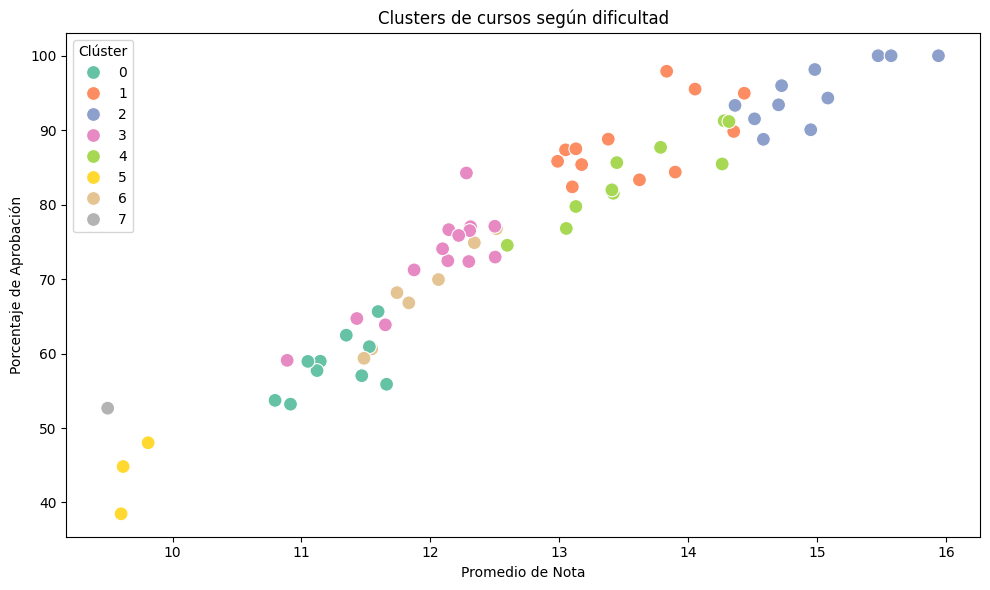

/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_66129/906735940.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


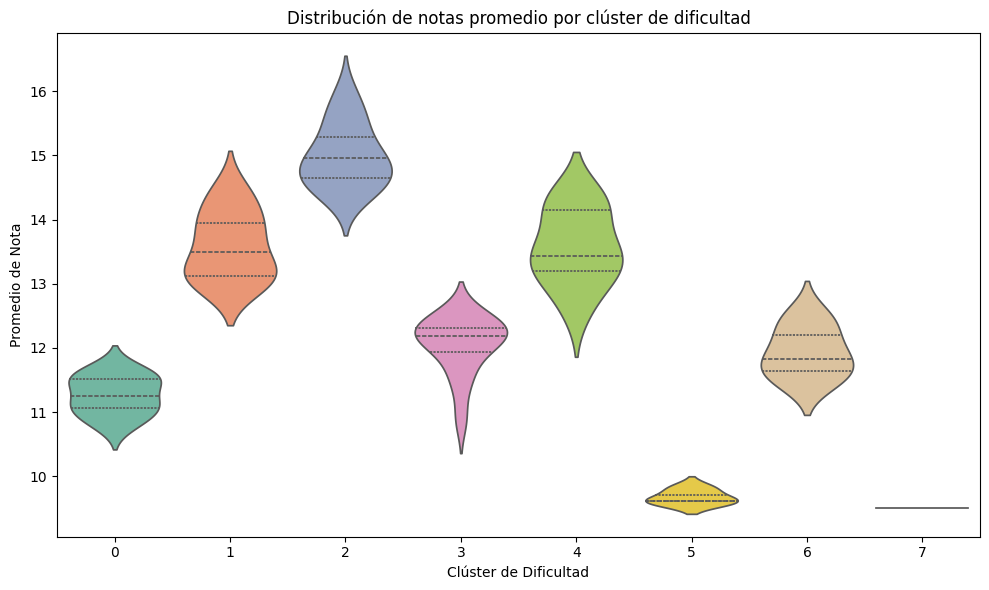

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- 1. Agrupar por curso con estadísticas detalladas ---
df_dif = (
    df_clean.groupby('CURSO')
    .agg(
        PROM_NOTA=('NOTA', 'mean'),
        Q1_NOTA=('NOTA', lambda x: x.quantile(0.25)),
        MEDIANA_NOTA=('NOTA', 'median'),
        Q3_NOTA=('NOTA', lambda x: x.quantile(0.75)),
        IQR_NOTA=('NOTA', lambda x: x.quantile(0.75) - x.quantile(0.25)),
        MIN_NOTA=('NOTA', 'min'),
        MAX_NOTA=('NOTA', 'max'),
        PRCTJ_APROB=('APROBO', lambda x: (x == 'S').mean() * 100),
        CREDITOS=('CREDITOS', 'mean'),
        NIVEL_CURSO=('NIVEL_CURSO', 'mean'),
        N_ESTUDIANTES=('NOTA', 'count')
    )
    .reset_index()
)

# --- 2. Rellenar posibles NaN ---
df_dif = df_dif.fillna(0)

# --- 3. Seleccionar columnas numéricas para clustering ---
X = df_dif[[
    'PROM_NOTA', 'Q1_NOTA', 'MEDIANA_NOTA', 'Q3_NOTA', 'IQR_NOTA',
    'PRCTJ_APROB', 'CREDITOS', 'NIVEL_CURSO'
]]

# --- 4. Normalizar ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 5. Aplicar KMeans ---
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
df_dif['CLUSTER_DIFICULTAD'] = kmeans.fit_predict(X_scaled)

# --- 6. Crear resumen por clúster ---
resumen_clusters = (
    df_dif
    .groupby('CLUSTER_DIFICULTAD')[[
        'PROM_NOTA', 'PRCTJ_APROB', 'CREDITOS', 'NIVEL_CURSO'
    ]]
    .mean()
    .round(2)
    .sort_values('PROM_NOTA')
)

print("📊 Resumen por clúster de dificultad:")
print(resumen_clusters)

# --- 7. Mostrar lista de cursos por clúster ---
for cluster in sorted(df_dif['CLUSTER_DIFICULTAD'].unique()):
    cursos = df_dif.loc[df_dif['CLUSTER_DIFICULTAD'] == cluster, 'CURSO'].tolist()
    print(f"\n🧩 CLÚSTER {cluster} ({len(cursos)} cursos):")
    print(", ".join(cursos))

# --- 8. Visualización de clústeres ---
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_dif,
    x='PROM_NOTA', y='PRCTJ_APROB',
    hue='CLUSTER_DIFICULTAD', palette='Set2', s=100
)
plt.title('Clusters de cursos según dificultad')
plt.xlabel('Promedio de Nota')
plt.ylabel('Porcentaje de Aprobación')
plt.legend(title='Clúster')
plt.tight_layout()
plt.show()

# --- 9. Visualización de la distribución promedio por clúster (violinplot) ---
plt.figure(figsize=(10,6))
sns.violinplot(
    data=df_dif,
    x='CLUSTER_DIFICULTAD',
    y='PROM_NOTA',
    palette='Set2',
    inner='quartile'
)
plt.title('Distribución de notas promedio por clúster de dificultad')
plt.xlabel('Clúster de Dificultad')
plt.ylabel('Promedio de Nota')
plt.tight_layout()
plt.show()



📊 Tabla de evaluación de número de clústeres:

 k  Inercia (Elbow Method)  Silhouette Score
 2                294.9873            0.3690
 3                217.1051            0.2897
 4                175.4709            0.3156
 5                145.3636            0.2993
 6                126.2062            0.3000
 7                111.2261            0.2858
 8                 94.3464            0.2988
 9                 87.5988            0.2840
10                 78.8624            0.2851
11                 73.2011            0.2914
12                 64.4924            0.3108
13                 61.2809            0.2739
14                 56.3312            0.2887


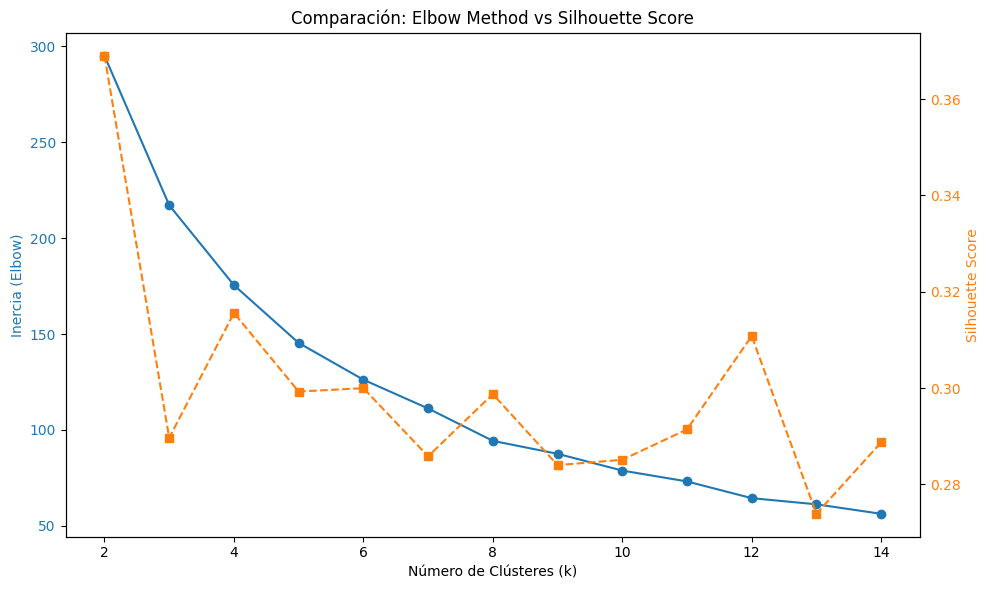


🔍 El mejor número de clústeres según Silhouette Score es: k = 2

📊 Resumen final por clúster de dificultad:

                    PROM_NOTA  Q1_NOTA  MEDIANA_NOTA  Q3_NOTA  IQR_NOTA  \
CLUSTER_DIFICULTAD                                                        
1                       11.47     9.65         12.14    13.88      4.23   
0                       13.95    12.77         14.20    15.61      2.84   

                    PRCTJ_APROB  CREDITOS  NIVEL_CURSO  
CLUSTER_DIFICULTAD                                      
1                         63.70      3.64         4.48  
0                         88.73      2.94         6.51  

🧩 CLÚSTER 0 (35 cursos):
ANALISIS DE LA REALIDAD PERUANA, APRECIACION ARTISTICA, APRECIACION LITERARIA, APRECIACION MUSICAL, BASES DE DATOS I, BASES DE DATOS II, BIG DATA, CLOUD COMPUTING, COMPUTACION EN LA SOCIEDAD, COMPUTACION GRAFICA, COMPUTACION MOLECULAR BIOLOGICA, ENSENANZA SOCIAL DE LA IGLESIA, ESTRUCTURAS DE DATOS AVANZADAS, ETICA PROFESIONAL, FORMAC

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- 1. Agrupar por curso con estadísticas extendidas ---
df_dif = (
    df_clean.groupby('CURSO')
    .agg(
        PROM_NOTA=('NOTA', 'mean'),
        Q1_NOTA=('NOTA', lambda x: x.quantile(0.25)),
        MEDIANA_NOTA=('NOTA', 'median'),
        Q3_NOTA=('NOTA', lambda x: x.quantile(0.75)),
        IQR_NOTA=('NOTA', lambda x: x.quantile(0.75) - x.quantile(0.25)),
        MIN_NOTA=('NOTA', 'min'),
        MAX_NOTA=('NOTA', 'max'),
        PRCTJ_APROB=('APROBO', lambda x: (x == 'S').mean() * 100),
        CREDITOS=('CREDITOS', 'mean'),
        NIVEL_CURSO=('NIVEL_CURSO', 'mean'),
        N_ESTUDIANTES=('NOTA', 'count')
    )
    .reset_index()
)

df_dif = df_dif.fillna(0)

# --- 2. Seleccionar features numéricos ---
X = df_dif[[
    'PROM_NOTA', 'Q1_NOTA', 'MEDIANA_NOTA', 'Q3_NOTA', 'IQR_NOTA',
    'PRCTJ_APROB', 'CREDITOS', 'NIVEL_CURSO'
]]

# --- 3. Normalizar ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4. Evaluación de KMeans con diferentes k ---
K_range = range(2, 15)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# --- 5. Crear tabla resumen ---
tabla_scores = pd.DataFrame({
    'k': K_range,
    'Inercia (Elbow Method)': inertias,
    'Silhouette Score': silhouette_scores
})

print("\n📊 Tabla de evaluación de número de clústeres:\n")
print(tabla_scores.round(4).to_string(index=False))

# --- 6. Graficar comparación ---
fig, ax1 = plt.subplots(figsize=(10,6))

color1 = 'tab:blue'
ax1.set_xlabel('Número de Clústeres (k)')
ax1.set_ylabel('Inercia (Elbow)', color=color1)
ax1.plot(tabla_scores['k'], tabla_scores['Inercia (Elbow Method)'], 'o-', color=color1, label='Elbow')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(tabla_scores['k'], tabla_scores['Silhouette Score'], 's--', color=color2, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Comparación: Elbow Method vs Silhouette Score")
fig.tight_layout()
plt.show()

# --- 7. Seleccionar el mejor número de clústeres según silhouette ---
best_k = tabla_scores.loc[tabla_scores['Silhouette Score'].idxmax(), 'k']
print(f"\n🔍 El mejor número de clústeres según Silhouette Score es: k = {best_k}")

# --- 8. Aplicar KMeans final con el mejor k ---
kmeans_final = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
df_dif['CLUSTER_DIFICULTAD'] = kmeans_final.fit_predict(X_scaled)

# --- 9. Resumen por clúster ---
resumen_clusters = (
    df_dif.groupby('CLUSTER_DIFICULTAD')[[
        'PROM_NOTA', 'Q1_NOTA', 'MEDIANA_NOTA', 'Q3_NOTA',
        'IQR_NOTA', 'PRCTJ_APROB', 'CREDITOS', 'NIVEL_CURSO'
    ]]
    .mean()
    .round(2)
    .sort_values('PROM_NOTA')
)

print("\n📊 Resumen final por clúster de dificultad:\n")
print(resumen_clusters)

# --- 10. Listar cursos por clúster ---
for cluster in sorted(df_dif['CLUSTER_DIFICULTAD'].unique()):
    cursos = df_dif.loc[df_dif['CLUSTER_DIFICULTAD'] == cluster, 'CURSO'].tolist()
    print(f"\n🧩 CLÚSTER {cluster} ({len(cursos)} cursos):")
    print(", ".join(cursos))


Columnas numéricas en df_dif para correlación:
['PROM_NOTA', 'Q1_NOTA', 'MEDIANA_NOTA', 'Q3_NOTA', 'IQR_NOTA', 'MIN_NOTA', 'MAX_NOTA', 'PRCTJ_APROB', 'CREDITOS', 'NIVEL_CURSO', 'N_ESTUDIANTES', 'CLUSTER_DIFICULTAD']


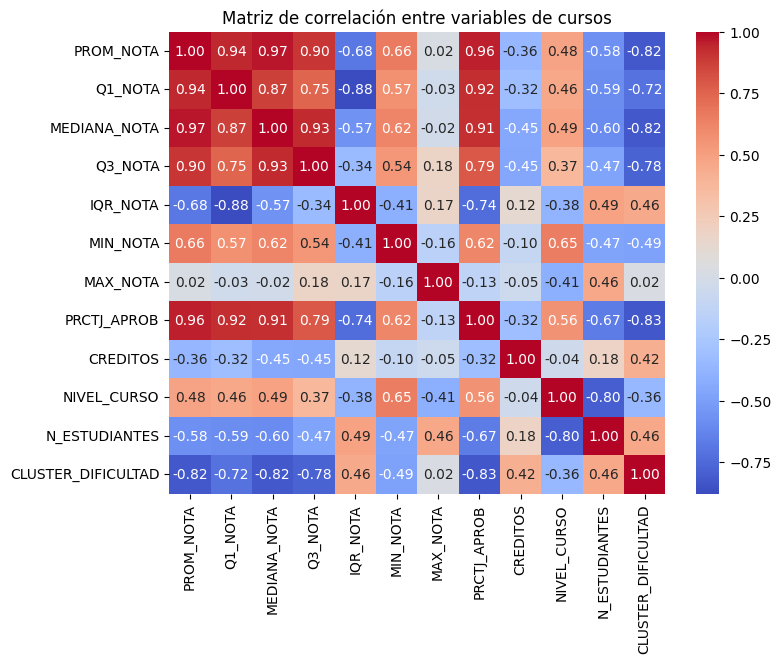

                    PROM_NOTA   Q1_NOTA  MEDIANA_NOTA   Q3_NOTA  IQR_NOTA  \
PROM_NOTA            1.000000  0.938174      0.967106  0.898788 -0.682296   
Q1_NOTA              0.938174  1.000000      0.872981  0.749224 -0.878099   
MEDIANA_NOTA         0.967106  0.872981      1.000000  0.932882 -0.565133   
Q3_NOTA              0.898788  0.749224      0.932882  1.000000 -0.340989   
IQR_NOTA            -0.682296 -0.878099     -0.565133 -0.340989  1.000000   
MIN_NOTA             0.662482  0.567404      0.622630  0.541322 -0.414284   
MAX_NOTA             0.020986 -0.029908     -0.021367  0.175170  0.168999   
PRCTJ_APROB          0.955229  0.923589      0.912634  0.793226 -0.737856   
CREDITOS            -0.357837 -0.319064     -0.448277 -0.454408  0.124588   
NIVEL_CURSO          0.480420  0.458782      0.491767  0.369619 -0.384153   
N_ESTUDIANTES       -0.577047 -0.586269     -0.596925 -0.473467  0.490081   
CLUSTER_DIFICULTAD  -0.820122 -0.716474     -0.820076 -0.777418  0.455304   

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# numericas columnas de df_dif
numerical_cols = df_dif.select_dtypes(include=['number']).columns
print("Columnas numéricas en df_dif para correlación:")
print(numerical_cols.tolist())
plt.figure(figsize=(8,6))
sns.heatmap(df_dif[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables de cursos")
plt.show()

print(df_dif[numerical_cols].corr())


📊 Evaluación de número de clústeres:
 k  Inercia (Elbow)  Silhouette Score
 2         173.0269            0.3284
 3         119.6432            0.3555
 4          95.5584            0.3186
 5          77.2671            0.3364
 6          67.2040            0.3109
 7          58.4043            0.2797
 8          50.5750            0.3113
 9          47.1553            0.3138
10          41.4010            0.2911
11          38.8557            0.2894
12          34.3974            0.3100
13          30.7947            0.3104
14          28.0854            0.3336


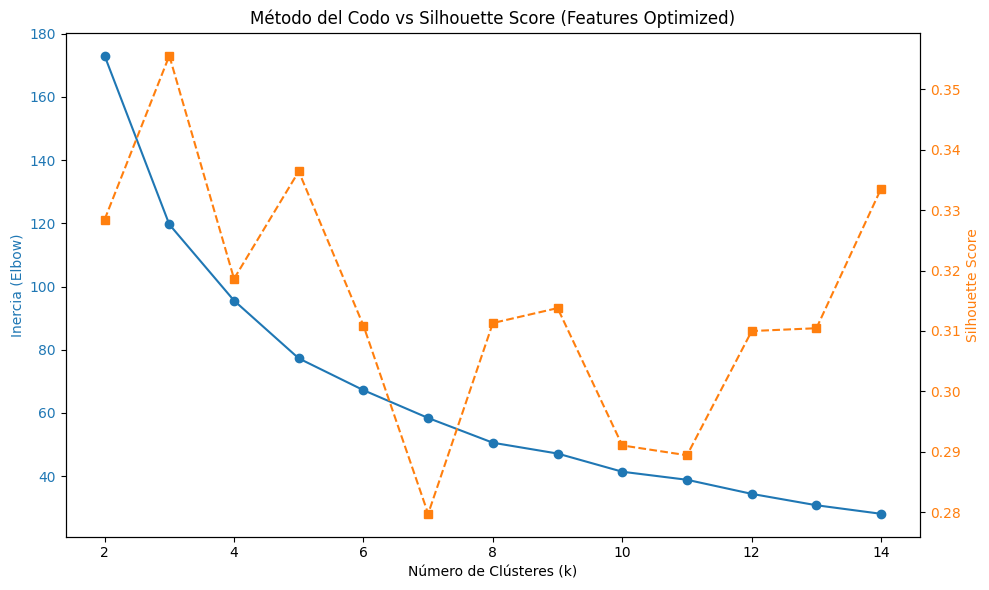


🔍 Mejor número de clústeres según Silhouette Score: k = 3

📊 Resumen final por clúster (versión optimizada):

                    PROM_NOTA  IQR_NOTA  PRCTJ_APROB  CREDITOS  NIVEL_CURSO
CLUSTER_DIFICULTAD                                                         
1                       10.84      5.59        55.54      3.93         3.07
2                       13.09      3.37        78.49      2.37         3.58
0                       13.40      2.68        84.80      3.50         7.71

🧩 CLÚSTER 0 (34 cursos):
ANALISIS DE LA REALIDAD PERUANA, ANALISIS Y DISENO DE ALGORITMOS, BASES DE DATOS I, BIG DATA, CLOUD COMPUTING, COMPILADORES, COMPUTACION EN LA SOCIEDAD, COMPUTACION GRAFICA, COMPUTACION MOLECULAR BIOLOGICA, COMPUTACION PARALELA Y DISTRIBUIDA, ENSENANZA SOCIAL DE LA IGLESIA, ESTADISTICA Y PROBABILIDADES, ESTRUCTURAS DE DATOS AVANZADAS, ETICA PROFESIONAL, FISICA COMPUTACIONAL, FORMACION DE EMPRESAS DE BASE TECNOLOGICA I, FORMACION DE EMPRESAS DE BASE TECNOLOGICA II, HISTORIA DE LA

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- 1. Agrupar por curso con estadísticas relevantes ---
df_dif = (
    df_clean.groupby('CURSO')
    .agg(
        PROM_NOTA=('NOTA', 'mean'),
        Q1_NOTA=('NOTA', lambda x: x.quantile(0.25)),
        Q3_NOTA=('NOTA', lambda x: x.quantile(0.75)),
        IQR_NOTA=('NOTA', lambda x: x.quantile(0.75) - x.quantile(0.25)),
        PRCTJ_APROB=('APROBO', lambda x: (x == 'S').mean() * 100),
        CREDITOS=('CREDITOS', 'mean'),
        NIVEL_CURSO=('NIVEL_CURSO', 'mean'),
        N_ESTUDIANTES=('NOTA', 'count')
    )
    .reset_index()
)

df_dif = df_dif.fillna(0)

# --- 2. Selección de features optimizados ---
# Eliminamos variables altamente correlacionadas (como MEDIANA_NOTA o MAX/MIN_NOTA)
# y aquellas que añaden poco valor explicativo.
X = df_dif[[
    # 'PROM_NOTA',        # Representa la tendencia central del rendimiento
    'IQR_NOTA',         # Refleja la dispersión o dificultad interna del curso
    'PRCTJ_APROB',      # Mide la tasa de aprobación
    'CREDITOS',         # Peso académico
    'NIVEL_CURSO'       # Dificultad esperada según nivel
]]

# --- 3. Normalización ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4. Evaluación de KMeans con diferentes k ---
K_range = range(2, 15)
inertias, silhouette_scores = [], []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# --- 5. Tabla comparativa ---
tabla_scores = pd.DataFrame({
    'k': K_range,
    'Inercia (Elbow)': inertias,
    'Silhouette Score': silhouette_scores
})
print("\n📊 Evaluación de número de clústeres:")
print(tabla_scores.round(4).to_string(index=False))

# --- 6. Visualización ---
fig, ax1 = plt.subplots(figsize=(10,6))

color1 = 'tab:blue'
ax1.set_xlabel('Número de Clústeres (k)')
ax1.set_ylabel('Inercia (Elbow)', color=color1)
ax1.plot(tabla_scores['k'], tabla_scores['Inercia (Elbow)'], 'o-', color=color1, label='Elbow')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(tabla_scores['k'], tabla_scores['Silhouette Score'], 's--', color=color2, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Método del Codo vs Silhouette Score (Features Optimized)")
fig.tight_layout()
plt.show()

# --- 7. Seleccionar mejor k según Silhouette ---
best_k = tabla_scores.loc[tabla_scores['Silhouette Score'].idxmax(), 'k']
print(f"\n🔍 Mejor número de clústeres según Silhouette Score: k = {best_k}")

# --- 8. KMeans final ---
kmeans_final = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
df_dif['CLUSTER_DIFICULTAD'] = kmeans_final.fit_predict(X_scaled)

# --- 9. Resumen por clúster ---
resumen_clusters = (
    df_dif.groupby('CLUSTER_DIFICULTAD')[[
        'PROM_NOTA', 'IQR_NOTA', 'PRCTJ_APROB', 'CREDITOS', 'NIVEL_CURSO'
    ]]
    .mean()
    .round(2)
    .sort_values('PROM_NOTA')
)

print("\n📊 Resumen final por clúster (versión optimizada):\n")
print(resumen_clusters)

# --- 10. Cursos por clúster ---
for cluster in sorted(df_dif['CLUSTER_DIFICULTAD'].unique()):
    cursos = df_dif.loc[df_dif['CLUSTER_DIFICULTAD'] == cluster, 'CURSO'].tolist()
    print(f"\n🧩 CLÚSTER {cluster} ({len(cursos)} cursos):")
    print(", ".join(cursos))


In [144]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19234 entries, 0 to 19233
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   COD_PERSONA                19234 non-null  object        
 1   SEXO                       19234 non-null  object        
 2   PER_INGRESO                19234 non-null  object        
 3   ESTADO_CIVIL               19234 non-null  object        
 4   TIPO_COLEGIO               19234 non-null  object        
 5   PTJE_INGRESO               19234 non-null  float64       
 6   ESTADO                     19234 non-null  object        
 7   SEM_CURSADOS               19234 non-null  int64         
 8   CANT_RESERVAS              19234 non-null  int64         
 9   PER_MATRICULA              19234 non-null  object        
 10  COD_CURSO                  19234 non-null  object        
 11  CURSO                      19234 non-null  object        
 12  CRED

In [145]:
df_clean['CURSO'].nunique()

68


📊 Evaluación de número de clústeres:
 k  Inercia (Elbow)  Silhouette Score
 2         157.2389            0.3436
 3         117.6492            0.3303
 4          88.5955            0.3264
 5          74.5755            0.3302
 6          62.9770            0.3424
 7          56.3333            0.3327
 8          49.0344            0.3399
 9          44.5727            0.3280
10          39.1503            0.3381
11          35.8810            0.3288
12          31.7175            0.3438
13          28.9557            0.3537
14          25.5731            0.3688
15          24.0368            0.3696
16          22.2028            0.3702
17          19.8402            0.3806
18          18.7678            0.3575
19          16.4166            0.4012
20          14.8067            0.4073
21          13.7746            0.4028
22          12.5632            0.4000
23          11.3513            0.3927
24          10.9827            0.3902
25          10.0102            0.3992
26          

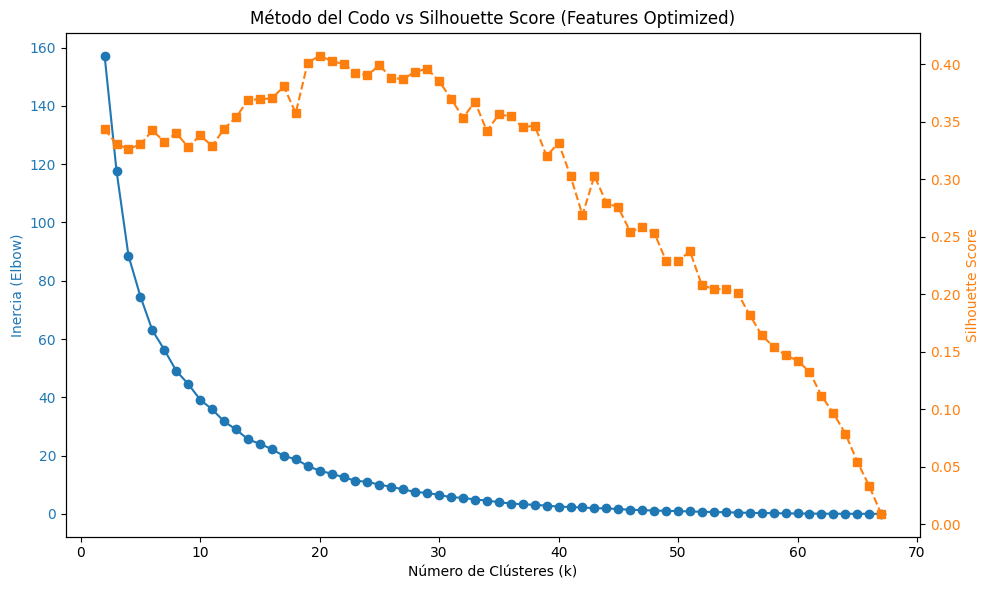


🔍 Mejor número de clústeres según Silhouette Score: k = 20

📊 Resumen final por clúster (versión optimizada):

                    PROM_NOTA  IQR_NOTA  PRCTJ_APROB  CREDITOS  NIVEL_CURSO
CLUSTER_DIFICULTAD                                                         
2                        9.61      6.74        58.35       4.5         1.00
12                      10.43      5.81        46.52       3.0         2.50
8                       10.68      6.46        41.46       3.0         9.00
4                       11.22      4.77        42.45       4.0         2.71
18                      11.47      6.05        42.98       5.0         2.00
11                      11.66      3.70        36.91       2.0         2.50
7                       11.78      3.54        33.75       3.0         3.67
0                       12.05      3.35        29.08       4.0         5.14
6                       12.19      2.40        24.10       4.0         8.25
9                       12.75      2.61        16.94

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# solo periodos menor a 2019-02
df_clean = df_clean[df_clean['PER_MATRICULA'] < '2019-02']
# # eliminar los tipo_ciclo == 'VERANO'
# df_clean = df_clean[df_clean['TIPO_CICLO'] != 'VERANO']


# --- 1. Agrupar por curso con estadísticas relevantes ---
df_dif = (
    df_clean.groupby('CURSO')
    .agg(
        PROM_NOTA=('NOTA', 'mean'),
        Q1_NOTA=('NOTA', lambda x: x.quantile(0.25)),
        Q3_NOTA=('NOTA', lambda x: x.quantile(0.75)),
        IQR_NOTA=('NOTA', lambda x: x.quantile(0.75) - x.quantile(0.25)),
        PRCTJ_APROB=('APROBO', lambda x: (x == 'N').mean() * 100),
        CREDITOS=('CREDITOS', 'mean'),
        NIVEL_CURSO=('NIVEL_CURSO', 'mean'),
        N_ESTUDIANTES=('NOTA', 'count'),
        DIFERENCIA_Q1_PROM=('NOTA', lambda x: x.quantile(0.25) - x.mean()),
    )
    .reset_index()
)

df_dif = df_dif.fillna(0)

# --- 2. Selección de features optimizados ---
# Eliminamos variables altamente correlacionadas (como MEDIANA_NOTA o MAX/MIN_NOTA)
# y aquellas que añaden poco valor explicativo.
X = df_dif[[
    'PROM_NOTA',        # Representa la tendencia central del rendimiento
    # 'IQR_NOTA',         # Refleja la dispersión o dificultad interna del curso
    'PRCTJ_APROB',      # Mide la tasa de aprobación
    'CREDITOS',         # Peso académico
    'NIVEL_CURSO'      # Dificultad esperada según nivel
]]

# --- 3. Normalización ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4. Evaluación de KMeans con diferentes k ---
K_range = range(2, 68)
inertias, silhouette_scores = [], []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# --- 5. Tabla comparativa ---
tabla_scores = pd.DataFrame({
    'k': K_range,
    'Inercia (Elbow)': inertias,
    'Silhouette Score': silhouette_scores
})
print("\n📊 Evaluación de número de clústeres:")
print(tabla_scores.round(4).to_string(index=False))

# --- 6. Visualización ---
fig, ax1 = plt.subplots(figsize=(10,6))

color1 = 'tab:blue'
ax1.set_xlabel('Número de Clústeres (k)')
ax1.set_ylabel('Inercia (Elbow)', color=color1)
ax1.plot(tabla_scores['k'], tabla_scores['Inercia (Elbow)'], 'o-', color=color1, label='Elbow')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(tabla_scores['k'], tabla_scores['Silhouette Score'], 's--', color=color2, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Método del Codo vs Silhouette Score (Features Optimized)")
fig.tight_layout()
plt.show()

# --- 7. Seleccionar mejor k según Silhouette ---

best_k = tabla_scores.loc[tabla_scores['Silhouette Score'].idxmax(), 'k']

print(f"\n🔍 Mejor número de clústeres según Silhouette Score: k = {best_k}")

# --- 8. KMeans final ---
kmeans_final = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
df_dif['CLUSTER_DIFICULTAD'] = kmeans_final.fit_predict(X_scaled)

# --- 9. Resumen por clúster ---
resumen_clusters = (
    df_dif.groupby('CLUSTER_DIFICULTAD')[[
        'PROM_NOTA', 'IQR_NOTA', 'PRCTJ_APROB', 'CREDITOS', 'NIVEL_CURSO'
    ]]
    .mean()
    .round(2)
    .sort_values('PROM_NOTA')
)

print("\n📊 Resumen final por clúster (versión optimizada):\n")
print(resumen_clusters)

# --- 10. Cursos por clúster ---
for cluster in sorted(df_dif['CLUSTER_DIFICULTAD'].unique()):
    cursos = df_dif.loc[df_dif['CLUSTER_DIFICULTAD'] == cluster, 'CURSO'].tolist()
    print(f"\n🧩 CLÚSTER {cluster} ({len(cursos)} cursos):")
    print(", ".join(cursos))


Columnas numéricas en df_dif para correlación:
['PROM_NOTA', 'IQR_NOTA', 'PRCTJ_APROB', 'CREDITOS', 'NIVEL_CURSO', 'DIFERENCIA_Q1_PROM']


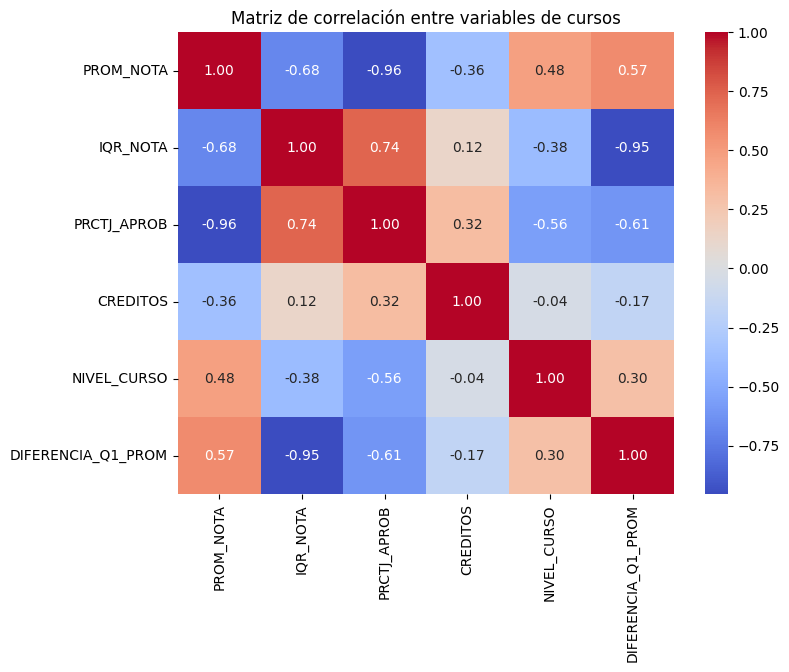

                    PROM_NOTA  IQR_NOTA  PRCTJ_APROB  CREDITOS  NIVEL_CURSO  \
PROM_NOTA            1.000000 -0.682296    -0.955229 -0.357837     0.480420   
IQR_NOTA            -0.682296  1.000000     0.737856  0.124588    -0.384153   
PRCTJ_APROB         -0.955229  0.737856     1.000000  0.317063    -0.560439   
CREDITOS            -0.357837  0.124588     0.317063  1.000000    -0.038118   
NIVEL_CURSO          0.480420 -0.384153    -0.560439 -0.038118     1.000000   
DIFERENCIA_Q1_PROM   0.574960 -0.954790    -0.614023 -0.166390     0.295282   

                    DIFERENCIA_Q1_PROM  
PROM_NOTA                     0.574960  
IQR_NOTA                     -0.954790  
PRCTJ_APROB                  -0.614023  
CREDITOS                     -0.166390  
NIVEL_CURSO                   0.295282  
DIFERENCIA_Q1_PROM            1.000000  


In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

# numericas columnas de df_dif
numerical_cols = df_dif.select_dtypes(include=['number']).columns
# quitar 'Q1_NOTA', 'MEDIANA_NOTA', 'Q3_NOTA', 'N_ESTUDIANTES' , 'CLUSTER_DIFICULTAD'
numerical_cols = numerical_cols.drop(['Q1_NOTA', 'MEDIANA_NOTA', 'Q3_NOTA', 'N_ESTUDIANTES', 'CLUSTER_DIFICULTAD'], errors='ignore')
print("Columnas numéricas en df_dif para correlación:")
print(numerical_cols.tolist())
plt.figure(figsize=(8,6))
sns.heatmap(df_dif[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables de cursos")
plt.show()

print(df_dif[numerical_cols].corr())

## Normalizacion

In [148]:
# # los COD_PERSONA que tengan mas de un per_ingreso , predominara el mas antiguo y se sobreescribira en los demas registros
# def obtener_per_ingreso_mas_antiguo(cod_persona):
#     registros_alumno = df_clean[df_clean['COD_PERSONA'] == cod_persona]
#     per_ingreso_mas_antiguo = registros_alumno['PER_INGRESO'].min()
#     return per_ingreso_mas_antiguo
# cod_personas_unicos = df_clean['COD_PERSONA'].unique()
# for cod_persona in cod_personas_unicos:
#     per_ingreso_antiguo = obtener_per_ingreso_mas_antiguo(cod_persona)
#     df_clean.loc[df_clean['COD_PERSONA'] == cod_persona, 'PER_INGRESO'] = per_ingreso_antiguo

# # los COD_PERSONA que tengan mas de un PTJE_INGRESO, predominara el ultimo valor registrado y se sobreescribira en los demas registros
# def obtener_ptje_ingreso_mas_reciente(cod_persona):
#     registros_alumno = df_clean[df_clean['COD_PERSONA'] == cod_persona]
#     # el ultimo registrado en funcion al PER_INGRESO
#     per_ingreso_ordenado = registros_alumno.sort_values(by='PER_INGRESO', ascending=False)
#     ptje_ingreso_reciente = per_ingreso_ordenado.iloc[0]['PTJE_INGRESO']
#     return ptje_ingreso_reciente
# for cod_persona in cod_personas_unicos:
#     ptje_ingreso_reciente = obtener_ptje_ingreso_mas_reciente(cod_persona)
#     df_clean.loc[df_clean['COD_PERSONA'] == cod_persona, 'PTJE_INGRESO'] = ptje_ingreso_reciente

# # los cod_persona que tengan varios cant_reservas, nos quedaremos con las suma de cant_reservas por distintos cod_alumno de un mismo cod_persona
# def sumar_cant_reservas_por_cod_persona(cod_persona):
#     registros_alumno = df_clean[df_clean['COD_PERSONA'] == cod_persona]
#     df_cleaning = registros_alumno.groupby('COD_ALUMNO')['CANT_RESERVAS'].sum().reset_index()
#     total_reservas = df_cleaning['CANT_RESERVAS'].sum()
#     return total_reservas
# for cod_persona in cod_personas_unicos:
#     total_reservas = sumar_cant_reservas_por_cod_persona(cod_persona)
#     df_clean.loc[df_clean['COD_PERSONA'] == cod_persona, 'CANT_RESERVAS'] = total_reservas

In [149]:
def verificar_consistencia_funcional(df, key_cols, features_a_verificar):
    """
    Verifica si una clave (key_cols) determina funcionalmente a una lista
    de atributos (features_a_verificar) en un DataFrame.
    
    Devuelve True si es consistente, False si hay errores.
    """
    
    alumnos_con_problemas = set()
    problemas_encontrados = False

    for feature in features_a_verificar:
        # No tiene sentido verificarse a sí mismo si ya está en la clave
        if feature in key_cols and len(features_a_verificar) > len(key_cols):
             if feature == features_a_verificar[0]: # Solo imprimir una vez
                pass
        
        df_check = df[key_cols + [feature]].drop_duplicates()
        
        inconsistencias = df_check[df_check.duplicated(subset=key_cols, keep=False)]
        
        if inconsistencias.empty:
            print(f"✅ Atributo '{feature}': Consistente.")
        else:
            problemas_encontrados = True
            alumnos_afectados = 0
            if 'COD_PERSONA' in inconsistencias.columns:
                alumnos_afectados = inconsistencias['COD_PERSONA'].nunique()
                alumnos_con_problemas.update(inconsistencias['COD_PERSONA'].unique())
            
            print(f"❌ Atributo '{feature}': ¡ERROR DE CONSISTENCIA!")
            print(inconsistencias.sort_values(by=key_cols).head(4))
    return not problemas_encontrados

